# Project Overview

> This is an in-depth notebook which explores the Austin Housing Dataset through several different models. The notebook includes a thorough EDA and cleaning section, natural language processing on text descriptions, exploration of different models using different categorical methods (one-hot encoding vs target encoding) with extensive parameter tuning, an evaluation of the final model, and visualizations.

* **Business Objective**


* **Notebook Preparation**
    * Importing our Modules


* **Preprocessing**
    * EDA and Cleaning
        * Scaling target value for Time Series
        * Duplicates
        * Outlier Detection
        * Missing Data
        * Binary Data
        * Studying our Target Variable
    * Natural Language Processing
    * Create Holdout Set
    * Feature Engineering
    * Correlations and Multicollinearity
    * EDA & Process Train Set
        * Categoricals
        * Continuous
            * Standardize Continuous Data
            * Find Interactions
            * Adding Polynomial Features
        * NLP
    * Process Test Set
        * Categoricals
        * Continuous
        * NLP
    * Create Train/Test Final


* **Model Explorations**
    * Picking our Base Features
    * Linear Regressions
        * Basic LR with Top Features One-Hot Encoded
        * Basic LR with Top Features Target Encoded
        * LR with ALL model features
        * Linear Regression with various Feature Selection Methods
            * Permutation Importance
            * Forward-Backward Selector
            * RFECV
    * K-Nearest Neighbors
    * Support Vector Regression
    * Decision Tree Models
        * Decision Tree - One Hot Encoded
            * Random Forest Regressor
            * XGBoost
        * Decision Tree - Target Encoded
            * Random Forest Regressor
            * XGBoost



* **Regression Results and Model Selection**
    * Evaluate results of all attempted models and choose best model


* **Final Model**
    * Process and train final model on data
    * Saving model assets for later use
    * Evaluating final model stats


* Making Predictions with New Data
    * Making new predictions on one entry and imported csv


* Visualizations
    * Feature visualizations


> Analysis
* Statistical analysis and explanations

> Conclusions and Recommendations
* Answers to business questions

> Future Work

> Explanation of Attempts - Feature Engineering/Selection


# Objective

Build a model that accurately predicts house prices in Austin

# Notebook Preparation

In [62]:
# data processing tools
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from math import sqrt
import itertools
from collections import Counter

# model tools
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import neighbors
import xgboost as xgb

# NLP tools
import spacy
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Visualization tools
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

# Preprocessing

In [63]:
# load and look at our austin housing data
df = pd.read_pickle('listings_cleaned_na.pkl')
df.head()

,address,zipcode,description,homeStatus,latitude,longitude,price,propertyTaxRate,appliances1,appliances2,appliances3,appliances4,architectural,Lot_size,Basement_type,cityRegion,hasAttachedProperty,hasCooling,hasFireplace,hasHeating,hasPrivatePool,hasView,homeType,specialroom1,specialroom2,stories,style,annualtax,zoning,school_distance,school_rating,students_per_teacher,school_size,school1,school2,school3,sqft,price_changes,initial_list_price,initial_time,sale_time
0,2715 Netherland Ave,10463.0,\n,SOLD,40.880135,-73.914337,800000.0,0.95,Dryer,Washer,NaN,NaN,NaN,"7,501 sqft",NaN,Bronx,0,1.0,NaN,1.0,NaN,0,Single Family,WalkInCloset,NaN,2.0,Tudor,12667.0,NaN,0.45,7.5,16.0,1212.0,Ps 24 Spuyten Duyvil,Riverdale Kingsbridge Academy (Ms High School ...,NaN,3285.0,2,1295000.0,1.519258e+12,1.547510e+12
1,2760 Arlington Ave,10463.0,Price Reduced - 4-Bd. House w/ Patio & Backyar...,SOLD,40.880951,-73.914017,997500.0,0.95,NaN,NaN,NaN,NaN,NaN,"5,250 sqft",NaN,Bronx,0,1.0,1.0,0.0,NaN,0,Single Family,NaN,NaN,2.0,NaN,7962.0,NaN,0.40,7.5,16.0,1212.0,Ps 24 Spuyten Duyvil,Riverdale Kingsbridge Academy (Ms High School ...,NaN,2134.0,2,1275000.0,1.494893e+12,1.532477e+12
2,4645 Dodgewood Rd,10471.0,"4645 Dodgewood Rd, Bronx, NY 10471 is a single...",SOLD,40.893726,-73.910774,1600000.0,0.95,Dryer,Washer,NaN,NaN,NaN,0.32 Acres,NaN,Bronx,0,1.0,0.0,1.0,0.0,0,Single Family,NaN,NaN,1.0,NaN,21068.0,NaN,0.55,6.0,14.0,1120.0,Ps 81 Robert J Christen,Riverdale Kingsbridge Academy (Ms High School ...,NaN,4036.0,8,2595000.0,1.487290e+12,1.543968e+12
3,2716-2720 Arlington Ave,10463.0,NEW TO MARKET: Modern 5-Bd. Colonial w/ Beauti...,SOLD,40.880440,-73.914597,1510000.0,0.95,Dishwasher,NaN,NaN,NaN,NaN,"8,625 sqft",NaN,Bronx,0,1.0,NaN,0.0,NaN,0,Single Family,NaN,NaN,2.0,NaN,13274.0,NaN,0.45,7.5,16.0,1212.0,Ps 24 Spuyten Duyvil,Riverdale Kingsbridge Academy (Ms High School ...,NaN,3256.0,0,1650000.0,1.488931e+12,1.518048e+12
4,2741 Edgehill Ave,10463.0,"Unique Arts & Crafts home, circa 1909, offers ...",SOLD,40.879894,-73.913315,1555000.0,0.95,Dishwasher,Dryer,Microwave,Range / Oven,NaN,"7,990 sqft",Partially finished,Bronx,0,1.0,1.0,1.0,0.0,1,Single Family,BreakfastNook,FamilyRoom,3.0,Craftsman,10079.0,NaN,0.50,7.5,16.0,1212.0,Ps 24 Spuyten Duyvil,Riverdale Kingsbridge Academy (Ms High School ...,NaN,3226.0,0,1600000.0,1.534205e+12,1.545178e+12


In [64]:
df.dtypes

address                  object
zipcode                 float64
description              object
homeStatus               object
latitude                float64
longitude               float64
price                   float64
propertyTaxRate         float64
appliances1              object
appliances2              object
appliances3              object
appliances4              object
architectural            object
Lot_size                 object
Basement_type            object
cityRegion               object
hasAttachedProperty       int64
hasCooling              float64
hasFireplace            float64
hasHeating              float64
hasPrivatePool          float64
hasView                   int64
homeType                 object
specialroom1             object
specialroom2             object
stories                 float64
style                    object
annualtax               float64
zoning                   object
school_distance         float64
school_rating           float64
students

In [65]:
df.isna().sum()

address                     0
zipcode                     0
description              2177
homeStatus                  0
latitude                    0
longitude                   0
price                       0
propertyTaxRate             3
appliances1              8122
appliances2             11605
appliances3             14669
appliances4             19761
architectural           19983
Lot_size                 4169
Basement_type           13810
cityRegion                  0
hasAttachedProperty         0
hasCooling                120
hasFireplace            17963
hasHeating                 28
hasPrivatePool          14662
hasView                     0
homeType                    0
specialroom1            10856
specialroom2            19276
stories                  8881
style                   17015
annualtax                3000
zoning                  19224
school_distance            41
school_rating              67
students_per_teacher      113
school_size               101
school1   

In [66]:
df.describe()

,zipcode,latitude,longitude,price,propertyTaxRate,hasAttachedProperty,hasCooling,hasFireplace,hasHeating,hasPrivatePool,hasView,stories,annualtax,school_distance,school_rating,students_per_teacher,school_size,sqft,price_changes,initial_list_price,initial_time,sale_time
count,26887.000000,26887.000000,26887.000000,2.688700e+04,26884.000000,26887.000000,26767.000000,8924.000000,26859.000000,12225.000000,26887.000000,18006.000000,2.388700e+04,26846.000000,26820.000000,26774.000000,26786.000000,26887.000000,26887.000000,2.135000e+04,2.146600e+04,2.688700e+04
mean,10805.353926,40.678239,-73.957923,8.340393e+05,0.840608,0.093614,0.482086,0.431085,0.569157,0.187648,0.093726,2.436299,1.484821e+04,0.845386,5.397662,15.100545,1262.482006,2544.720497,0.840034,9.612497e+05,1.541281e+12,1.564155e+12
std,533.815563,0.101582,0.154742,1.217286e+06,0.084944,0.291296,0.499688,0.495256,0.495203,0.390447,0.291452,2.282133,1.349810e+05,0.450169,1.409790,1.587232,558.553569,15311.706198,1.579821,1.768450e+06,4.470713e+10,2.743638e+10
min,148.000000,40.498634,-74.253983,1.000000e+05,0.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,1.000000,7.000000,115.000000,1.000000,0.000000,1.750000e+02,1.192234e+12,1.516579e+12
25%,10309.000000,40.594479,-74.112816,4.750000e+05,0.840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.164000e+03,0.500000,4.300000,14.000000,776.000000,1200.000000,0.000000,5.099990e+05,1.522973e+12,1.540253e+12
50%,10469.000000,40.663563,-73.931953,6.150000e+05,0.870000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,5.365000e+03,0.770000,5.300000,15.000000,1274.000000,1536.000000,0.000000,6.500000e+05,1.545350e+12,1.563926e+12
75%,11365.000000,40.746590,-73.829689,8.400000e+05,0.870000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000,7.056000e+03,1.100000,6.300000,16.000000,1702.000000,2090.000000,1.000000,8.999000e+05,1.568592e+12,1.586779e+12
max,13277.000000,40.911961,-73.700432,6.546053e+07,2.210000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,112.000000,7.123810e+06,6.630000,10.000000,20.000000,3288.000000,986641.000000,25.000000,6.990000e+07,1.610669e+12,1.611187e+12


## EDA and Cleaning

### Scale Time Series

We need to bring all of our home sale prices to the same time scale. It's easy to ignore that these homes were sold over the space of many years, but a year is a long time for real estate. We'll need to appreciate all sale prices into our most recent time series, using months.

In [67]:
df['sale_time_scaled'] = round(df['sale_time']/5000000000, 0)

rangex = df['sale_time_scaled'].max() - df['sale_time_scaled'].min()
rangex

19.0

In [68]:
df['sale_time_scaled'].nunique()

20

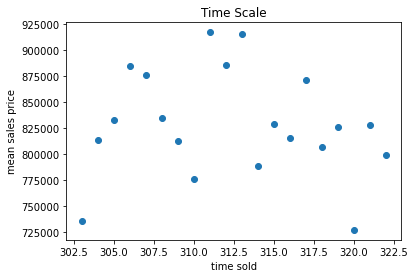

In [69]:
# Checking out our mean sales price for year built scattered versus price shows a polynomial relationship

yearly_prices = df.groupby(['sale_time_scaled'])['price'].mean()

plt.scatter(yearly_prices.index, yearly_prices)
plt.title("Time Scale")
plt.xlabel('time sold')
plt.ylabel('mean sales price')
plt.show()

In [70]:
df['first_listed_scaled'] = round(df['initial_time']/5000000000, 0)
df['time_to_sell'] = df['sale_time_scaled'] - df['first_listed_scaled']
df['price_change_abs'] = df['price'] - df['initial_list_price']
df['price_change_prct'] = (df['price'] - df['initial_list_price']) / df['price']
df['reduc_per_price_change'] = df['price_change_prct'] / df['price_changes']

In [71]:
df.loc[(df.reduc_per_price_change == -np.inf) | (df.reduc_per_price_change == np.inf) | (df.reduc_per_price_change.isna()),'reduc_per_price_change']= 0

In [72]:
df.drop(['initial_time', 'sale_time'], axis=1, inplace=True)

In [73]:
df

,address,zipcode,description,homeStatus,latitude,longitude,price,propertyTaxRate,appliances1,appliances2,appliances3,appliances4,architectural,Lot_size,Basement_type,cityRegion,hasAttachedProperty,hasCooling,hasFireplace,hasHeating,hasPrivatePool,hasView,homeType,specialroom1,specialroom2,stories,style,annualtax,zoning,school_distance,school_rating,students_per_teacher,school_size,school1,school2,school3,sqft,price_changes,initial_list_price,sale_time_scaled,first_listed_scaled,time_to_sell,price_change_abs,price_change_prct,reduc_per_price_change
0,2715 Netherland Ave,10463.0,\n,SOLD,40.880135,-73.914337,800000.0,0.95,Dryer,Washer,NaN,NaN,NaN,"7,501 sqft",NaN,Bronx,0,1.0,NaN,1.0,NaN,0,Single Family,WalkInCloset,NaN,2.0,Tudor,12667.0,NaN,0.45,7.5,16.0,1212.0,Ps 24 Spuyten Duyvil,Riverdale Kingsbridge Academy (Ms High School ...,NaN,3285.0,2,1295000.0,310.0,304.0,6.0,-495000.0,-0.618750,-0.309375
1,2760 Arlington Ave,10463.0,Price Reduced - 4-Bd. House w/ Patio & Backyar...,SOLD,40.880951,-73.914017,997500.0,0.95,NaN,NaN,NaN,NaN,NaN,"5,250 sqft",NaN,Bronx,0,1.0,1.0,0.0,NaN,0,Single Family,NaN,NaN,2.0,NaN,7962.0,NaN,0.40,7.5,16.0,1212.0,Ps 24 Spuyten Duyvil,Riverdale Kingsbridge Academy (Ms High School ...,NaN,2134.0,2,1275000.0,306.0,299.0,7.0,-277500.0,-0.278195,-0.139098
2,4645 Dodgewood Rd,10471.0,"4645 Dodgewood Rd, Bronx, NY 10471 is a single...",SOLD,40.893726,-73.910774,1600000.0,0.95,Dryer,Washer,NaN,NaN,NaN,0.32 Acres,NaN,Bronx,0,1.0,0.0,1.0,0.0,0,Single Family,NaN,NaN,1.0,NaN,21068.0,NaN,0.55,6.0,14.0,1120.0,Ps 81 Robert J Christen,Riverdale Kingsbridge Academy (Ms High School ...,NaN,4036.0,8,2595000.0,309.0,297.0,12.0,-995000.0,-0.621875,-0.077734
3,2716-2720 Arlington Ave,10463.0,NEW TO MARKET: Modern 5-Bd. Colonial w/ Beauti...,SOLD,40.880440,-73.914597,1510000.0,0.95,Dishwasher,NaN,NaN,NaN,NaN,"8,625 sqft",NaN,Bronx,0,1.0,NaN,0.0,NaN,0,Single Family,NaN,NaN,2.0,NaN,13274.0,NaN,0.45,7.5,16.0,1212.0,Ps 24 Spuyten Duyvil,Riverdale Kingsbridge Academy (Ms High School ...,NaN,3256.0,0,1650000.0,304.0,298.0,6.0,-140000.0,-0.092715,0.000000
4,2741 Edgehill Ave,10463.0,"Unique Arts & Crafts home, circa 1909, offers ...",SOLD,40.879894,-73.913315,1555000.0,0.95,Dishwasher,Dryer,Microwave,Range / Oven,NaN,"7,990 sqft",Partially finished,Bronx,0,1.0,1.0,1.0,0.0,1,Single Family,BreakfastNook,FamilyRoom,3.0,Craftsman,10079.0,NaN,0.50,7.5,16.0,1212.0,Ps 24 Spuyten Duyvil,Riverdale Kingsbridge Academy (Ms High School ...,NaN,3226.0,0,1600000.0,309.0,307.0,2.0,-45000.0,-0.028939,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26882,93-19 71st Ave,11375.0,This house is a rare combination of superb loc...,SOLD,40.712009,-73.850281,1255000.0,0.84,Dishwasher,Dryer,Washer,NaN,NaN,"2,500 sqft",NaN,Forest Hills,0,0.0,NaN,0.0,NaN,0,Single Family,DiningRoom,NaN,NaN,Loft,7129.0,NaN,0.43,7.0,15.0,1012.0,Ps 144 Col Jeromus Remsen,Jhs 190 Russell Sage,Queens Metropolitan High School,2200.0,0,1249000.0,306.0,304.0,2.0,6000.0,0.004781,0.000000
26883,6829 Manse St,11375.0,Wonderful 1 Family Home. First Floor Features ...,SOLD,40.714203,-73.855263,825000.0,0.84,NaN,NaN,NaN,NaN,NaN,"2,417 sqft",NaN,Flushing,0,0.0,NaN,1.0,NaN,0,Single Family,DiningRoom,NaN,2.0,NaN,6447.0,NaN,0.40,7.0,15.0,1012.0,Ps 144 Col Jeromus Remsen,Jhs 190 Russell Sage,Queens Metropolitan High School,2417.0,0,868000.0,307.0,304.0,3.0,-43000.0,-0.052121,0.000000
26884,82 Greenway Ter,11375.0,"""DISTINQUISHED FIELDSTONE TOWNHOUSE TREASURE""\...",SOLD,40.717163,-73.843124,2704000.0,0.84,NaN,NaN,NaN,NaN,NaN,"3,255 sqft",NaN,Forest Hills Gardens,0,0.0,0.0,0.0,0.0,0,Townhouse,NaN,NaN,2.0,NaN,18430.0,NaN,0.60,7.3,15.0,932.0,Ps 101 School In The Gardens,Jhs 190 Russell Sage,Queens Metropolitan High School,6085.0,0,2599000.0,312.0,311.0,1.0,105000.0,0.038831,0.000000
26885,86 Greenway Ter,11375.0,EXCLUSIVE LISTING OF TERRACE SOTHEBY'S INTERN

### Checking homeType

In [74]:
# what are the homeTypes?

df['homeType'].value_counts(normalize=True)

Single Family    0.535872
Residential      0.285082
Condo            0.115409
Townhouse        0.063637
Name: homeType, dtype: float64

### Duplicate Data

In [75]:
# check for duplicate data

df[df.duplicated(subset=['latitude','longitude'], keep=False)].sort_values('latitude')


,address,zipcode,description,homeStatus,latitude,longitude,price,propertyTaxRate,appliances1,appliances2,appliances3,appliances4,architectural,Lot_size,Basement_type,cityRegion,hasAttachedProperty,hasCooling,hasFireplace,hasHeating,hasPrivatePool,hasView,homeType,specialroom1,specialroom2,stories,style,annualtax,zoning,school_distance,school_rating,students_per_teacher,school_size,school1,school2,school3,sqft,price_changes,initial_list_price,sale_time_scaled,first_listed_scaled,time_to_sell,price_change_abs,price_change_prct,reduc_per_price_change
20309,81 Billop Ave,10307.0,Totally renovated home with beautiful oak floo...,SOLD,40.500145,-74.239487,499000.0,0.87,NaN,NaN,NaN,NaN,NaN,"2,474 sqft",NaN,Staten Island,0,1.0,NaN,1.0,NaN,0,Single Family,DiningRoom,NaN,2.0,NaN,4196.0,R3A,1.50,8.0,15.0,1786.0,Ps 1 Tottenville,Is 34 Tottenville,Tottenville High School,1360.0,0,499900.0,305.0,304.0,1.0,-900.0,-0.001804,0.000000
11735,81 Billop Ave,10307.0,Totally renovated home with beautiful oak floo...,SOLD,40.500145,-74.239487,499000.0,0.87,NaN,NaN,NaN,NaN,NaN,"2,474 sqft",NaN,Staten Island,0,1.0,NaN,1.0,NaN,0,Single Family,DiningRoom,NaN,2.0,NaN,4196.0,R3A,1.50,8.0,15.0,1786.0,Ps 1 Tottenville,Is 34 Tottenville,Tottenville High School,1360.0,0,499900.0,305.0,304.0,1.0,-900.0,-0.001804,0.000000
11923,37 Sea Breeze Ln,10307.0,Come and enjoy this little oasis in historic T...,RECENTLY_SOLD,40.500793,-74.237473,360000.0,0.87,Dishwasher,Dryer,Refrigerator,Washer,NaN,$215/mo,None,Staten Island,1,1.0,NaN,1.0,1.0,1,Residential,Bathroom,Kitchen,2.0,Townhouse,3505.0,R3-2,1.53,7.3,15.0,1811.0,Ps 6 Cpl Allan F Kivlehan School,Is 34 Tottenville,Tottenville High School,720.0,0,375000.0,321.0,319.0,2.0,-15000.0,-0.041667,0.000000
20195,37 Sea Breeze Ln,10307.0,Come and enjoy this little oasis in historic T...,RECENTLY_SOLD,40.500793,-74.237473,360000.0,0.87,Dishwasher,Dryer,Refrigerator,Washer,NaN,$215/mo,None,Staten Island,1,1.0,NaN,1.0,1.0,1,Residential,Bathroom,Kitchen,2.0,Townhouse,3505.0,R3-2,1.53,7.3,15.0,1811.0,Ps 6 Cpl Allan F Kivlehan School,Is 34 Tottenville,Tottenville High School,720.0,0,375000.0,321.0,319.0,2.0,-15000.0,-0.041667,0.000000
20217,45 Sea Breeze Ln,10307.0,"Beautiful and super clean, large and extra wid...",SOLD,40.500809,-74.237663,406000.0,0.87,Microwave,NaN,NaN,NaN,NaN,$215/mo,None,Staten Island,1,1.0,NaN,1.0,0.0,0,Residential,Bathroom,Kitchen,2.0,Townhouse,3865.0,R3-2,1.53,7.3,15.0,1811.0,Ps 6 Cpl Allan F Kivlehan School,Is 34 Tottenville,Tottenville High School,1500.0,1,449000.0,313.0,311.0,2.0,-43000.0,-0.105911,-0.105911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,359 W 262nd St,10471.0,NaN,RECENTLY_SOLD,40.911335,-73.899666,540000.0,0.95,NaN,NaN,NaN,NaN,Colonial,0.06 Acres,"Full,Unfinished",Bronx,0,1.0,NaN,1.0,NaN,0,Residential,NaN,NaN,NaN,NaN,6073.0,NaN,1.15,6.0,14.0,1120.0,Ps 81 Robert J Christen,Riverdale Kingsbridge Academy (Ms High School ...,NaN,1386.0,1,595000.0,316.0,313.0,3.0,-55000.0,-0.101852,-0.101852
16262,359 W 262nd St,10471.0,NaN,RECENTLY_SOLD,40.911335,-73.899666,540000.0,0.95,NaN,NaN,NaN,NaN,Colonial,0.06 Acres,"Full,Unfinished",Bronx,0,1.0,NaN,1.0,NaN,0,Residential,NaN,NaN,NaN,NaN,6073.0,NaN,1.15,6.0,14.0,1120.0,Ps 81 Robert J Christen,Riverdale Kingsbridge Academy (Ms High School ...,NaN,1386.0,1,595000.0,316.0,313.0,3.0,-55000.0,-0.101852,-0.101852
16236,258 Spencer Pl,10471.0,"258 Spencer Pl, Bronx, NY 10471 is a single fa...",SOLD,40.911526,-73.897636,250000.0,0.95,NaN,NaN,NaN,NaN,NaN,"2,569 sqft",NaN,Bronx,0,0.0,0.0,0.0,0.0,0,Single Family,NaN,NaN,2.0,NaN,6962.0,NaN,1.25,6.0,14.0,1120.0,Ps 81 Robert J Christen,Riverdale Kingsbridge Academy (Ms High School ...,NaN,1473.0,0,NaN,303.0,NaN,NaN,NaN,NaN,NaN
16235,258 Spencer Pl,10471.0,"258 Spencer Pl, Bronx, NY 10471 is a single fa...",SOLD,40.911526,-73.897636,250000.0,0.95,NaN,NaN,NaN,NaN,NaN,"2,569 sq

In [76]:
# We have a lot of duplicate entries. We're going to keep the later of these entries and hope that if it's an outlier,
# it's caught in our outlier processing later.

df.drop_duplicates(['latitude','longitude'], keep='last', inplace=True)

### Outlier Detection

In [77]:
'''# plotting latitude and longitude as a visual scatter plot to look for location-based outliers

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="longitude", y="latitude",palette="magma_r"); '''

'# plotting latitude and longitude as a visual scatter plot to look for location-based outliers\n\nplt.figure(figsize=(25,25))\n\nsns.scatterplot(data=df, x="longitude", y="latitude",palette="magma_r"); '

Using latitude and longitude, we make a visual map of the Austin area that lets us see any map outliers. There don't appear to be any zones that are well outside of the Austin area, except for just a few down in the lower SE area. So we might plan to cut off our latitude just above 30.1.

This visualization suggests that location is very important to home price. We'll check that out more directly.

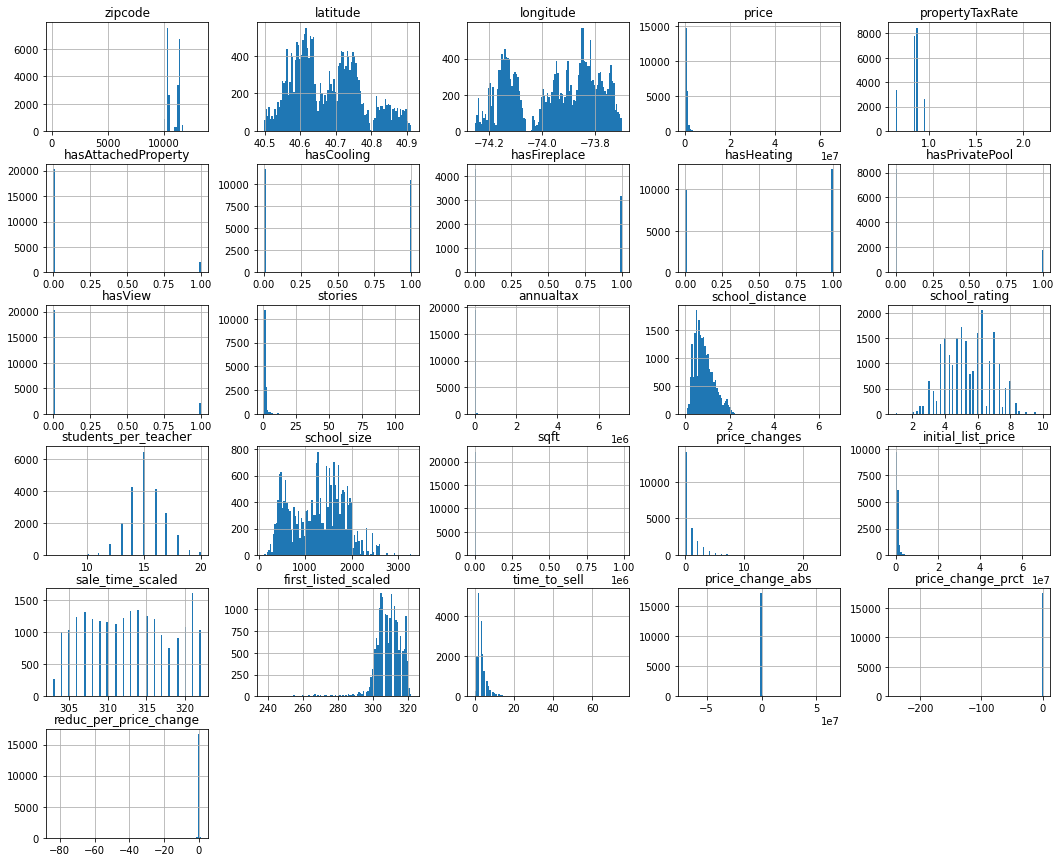

In [78]:
# check how our histograms are looking
df.hist(figsize=(18,15), bins=100);


In [79]:
# looking for outliers in the percentiles

df.describe()

,zipcode,latitude,longitude,price,propertyTaxRate,hasAttachedProperty,hasCooling,hasFireplace,hasHeating,hasPrivatePool,hasView,stories,annualtax,school_distance,school_rating,students_per_teacher,school_size,sqft,price_changes,initial_list_price,sale_time_scaled,first_listed_scaled,time_to_sell,price_change_abs,price_change_prct,reduc_per_price_change
count,22306.000000,22306.000000,22306.000000,2.230600e+04,22304.000000,22306.000000,22200.000000,7465.000000,22280.000000,10111.000000,22306.000000,14699.000000,1.975900e+04,22280.000000,22261.000000,22217.000000,22227.000000,22306.000000,22306.000000,1.767900e+04,22306.000000,17774.000000,17774.000000,1.767900e+04,17679.000000,16898.000000
mean,10829.685017,40.678214,-73.953933,8.495540e+05,0.836132,0.088227,0.472207,0.425720,0.557540,0.180299,0.090828,2.437989,1.630463e+04,0.848094,5.433026,15.193185,1283.536960,2635.126648,0.841881,9.875070e+05,312.827804,308.285754,4.684764,-1.211787e+05,-0.130460,-0.057249
std,528.093732,0.096352,0.153167,1.293589e+06,0.085768,0.283632,0.499238,0.494485,0.496689,0.384455,0.287370,2.260282,1.474889e+05,0.438964,1.400542,1.609731,561.059576,16589.548715,1.587263,1.901197e+06,5.492885,8.877606,7.172434,1.165598e+06,1.964799,0.935730
min,148.000000,40.498634,-74.253983,1.000000e+05,0.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,1.000000,7.000000,115.000000,1.000000,0.000000,1.750000e+02,303.000000,238.000000,0.000000,-6.961000e+07,-240.034483,-83.745763
25%,10309.000000,40.601396,-74.110941,4.820000e+05,0.840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.232000e+03,0.500000,4.300000,14.000000,782.000000,1200.000000,0.000000,5.250000e+05,308.000000,305.000000,2.000000,-8.900000e+04,-0.125012,-0.054167
50%,11001.000000,40.666979,-73.927834,6.250000e+05,0.840000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,5.460000e+03,0.770000,5.300000,15.000000,1310.000000,1536.000000,0.000000,6.690000e+05,313.000000,309.000000,3.000000,-3.490000e+04,-0.056075,0.000000
75%,11365.000000,40.744701,-73.824501,8.500000e+05,0.870000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000,7.193000e+03,1.100000,6.300000,16.000000,1713.000000,2080.000000,1.000000,9.280000e+05,317.000000,314.000000,4.000000,-9.000000e+03,-0.013889,0.000000
max,13277.000000,40.911961,-73.700432,6.546053e+07,2.210000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,112.000000,7.123810e+06,6.630000,10.000000,20.000000,3288.000000,986641.000000,25.000000,6.990000e+07,322.000000,322.000000,75.000000,6.466153e+07,0.999734,0.999060


We see potential outliers in stories, sqft, price_changes, time_to_sell, 

In [80]:
#check what is going on with the sqft outliers 
df.sort_values('sqft', ascending=False).head(10)

# We have a problem where properties are listed with their building square footage rather than unit square footage
# We need to see how big this problem is

,address,zipcode,description,homeStatus,latitude,longitude,price,propertyTaxRate,appliances1,appliances2,appliances3,appliances4,architectural,Lot_size,Basement_type,cityRegion,hasAttachedProperty,hasCooling,hasFireplace,hasHeating,hasPrivatePool,hasView,homeType,specialroom1,specialroom2,stories,style,annualtax,zoning,school_distance,school_rating,students_per_teacher,school_size,school1,school2,school3,sqft,price_changes,initial_list_price,sale_time_scaled,first_listed_scaled,time_to_sell,price_change_abs,price_change_prct,reduc_per_price_change
16104,357-389 Grand St,10002.0,***LOCATION - LOCATION - LOCATION***TOP FLOOR*...,RECENTLY_SOLD,40.716675,-73.989510,1700000.0,0.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New York,0,0.0,NaN,0.0,NaN,0,Condo,NaN,NaN,21.0,NaN,6274394.0,NaN,0.23,5.3,11.0,343.0,Ps 42 Benjamin Altman,University Neighborhood Middle School,Henry Street School For International Studies,986641.0,0,NaN,321.0,NaN,NaN,NaN,NaN,NaN
5101,11115 76th Ave,11375.0,"""Forest Close Townhouse"" \n\n*Contact Listing ...",RECENTLY_SOLD,40.716801,-73.837105,1270000.0,0.84,Dishwasher,Dryer,Microwave,Range / Oven,NaN,"1,729 sqft",Finished,Forest Hills,0,0.0,NaN,0.0,NaN,1,Townhouse,DiningRoom,NaN,3.0,Tudor,9447.0,NaN,1.20,6.7,17.0,1687.0,Ps 101 School In The Gardens,Jhs 190 Russell Sage,Hillcrest High School,882200.0,0,1485000.0,320.0,311.0,9.0,-215000.0,-0.169291,0.000000
4979,150-29 72nd,11367.0,"150-29 72nd, Flushing, NY 11367 is a condo hom...",RECENTLY_SOLD,40.727955,-73.816086,268000.0,0.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Flushing,0,0.0,NaN,0.0,NaN,0,Condo,NaN,NaN,NaN,NaN,NaN,NaN,0.30,7.0,11.0,583.0,Ps 165 Edith K Bergtraum,I.S. 250 the Robert F Kennedy Community Middle...,NaN,850000.0,0,NaN,317.0,NaN,NaN,NaN,NaN,NaN
15937,11 Riverside Dr,10023.0,Enjoy the exceptional sense of freedom and pri...,RECENTLY_SOLD,40.781128,-73.984489,530000.0,0.88,Dishwasher,Microwave,Range / Oven,Refrigerator,NaN,NaN,NaN,New York,0,1.0,NaN,1.0,NaN,1,Condo,LaundryRoom,NaN,1.0,NaN,7123810.0,NaN,0.40,9.0,14.0,313.0,Special Music School,NaN,NaN,689522.0,0,NaN,322.0,NaN,NaN,NaN,NaN,NaN
23246,2940 W 5th St APT 9E,11224.0,Nicely Renovated 9th floor unit features: Kitc...,SOLD,40.577606,-73.972710,370000.0,0.65,Dishwasher,Range / Oven,Refrigerator,NaN,NaN,$851/mo,NaN,Brooklyn,0,0.0,0.0,0.0,0.0,1,Condo,WalkInCloset,NaN,23.0,Other,1820136.0,NaN,0.20,5.5,16.0,715.0,Ps 100 The Coney Island School,Rachel Carson High School For Coastal Studies,NaN,623806.0,0,369000.0,305.0,304.0,1.0,1000.0,0.002703,0.000000
9149,75 Henry St,11201.0,Brooklyn Heights Huge Alcove Studio Located in...,RECENTLY_SOLD,40.698524,-73.992294,625000.0,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Brooklyn,0,0.0,NaN,0.0,NaN,0,Condo,NaN,NaN,33.0,NaN,2771485.0,NaN,0.20,7.0,15.0,697.0,Ps 8 Robert Fulton,Urban Assembly Institute of Math and Science f...,NaN,593599.0,0,NaN,321.0,NaN,NaN,NaN,NaN,NaN
25842,9940 63rd Rd APT 5D,11374.0,Extra Large One Bedroom Which Can Be Used As A...,SOLD,40.732338,-73.855553,139500.0,0.84,Refrigerator,NaN,NaN,NaN,NaN,$929/mo,NaN,Rego Park,0,0.0,NaN,1.0,NaN,0,Condo,DiningRoom,NaN,1.0,NaN,1757133.0,NaN,0.33,7.0,18.0,2075.0,Ps 175 The Lynn Gross Discovery School,Jhs 157 Stephen A Halsey,Forest Hills High School,452905.0,1,315000.0,310.0,304.0,6.0,-175500.0,-1.258065,-1.258065
9166,44 Pineapple St,11201.0,File Photos of a Comparable Unit \n\nThis one ...,RECENTLY_SOLD,40.698185,-73.994102,1200000.0,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Brooklyn,0,0.0,NaN,0.0,NaN,0,Condo,NaN,NaN,30.0,NaN,2135540.0,NaN,0.30,7.0,15.0,697.0,Ps 8 Robert Fulton,Urban Assembly Institute of Math and Science f...,NaN,441063.0,0,NaN,322.0,NaN,NaN,NaN,NaN,NaN
15942,185 W End Ave,10023.0,Lincoln Towers: Two rarely available contiguou...,SOLD,40.777874,-73.986275,480000.0,0.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New York,0,0.0,NaN,0.0,NaN,1,Condo,NaN,NaN,28.0,NaN,3783114.0,NaN,0.30,3.0,12.0,491.0,Ps 191 Amsterdam,"High School for Law, Advocacy and Community Ju...",NaN,418374.0,0,NaN,312.0,NaN,NaN,NaN,NaN,NaN
25563,245 E 54th St,1002

In [81]:
df.loc[(df['sqft']> 15000)]

,address,zipcode,description,homeStatus,latitude,longitude,price,propertyTaxRate,appliances1,appliances2,appliances3,appliances4,architectural,Lot_size,Basement_type,cityRegion,hasAttachedProperty,hasCooling,hasFireplace,hasHeating,hasPrivatePool,hasView,homeType,specialroom1,specialroom2,stories,style,annualtax,zoning,school_distance,school_rating,students_per_teacher,school_size,school1,school2,school3,sqft,price_changes,initial_list_price,sale_time_scaled,first_listed_scaled,time_to_sell,price_change_abs,price_change_prct,reduc_per_price_change
15,4555 Henry Hudson Pkwy,10471.0,Exclusively listed with Sopher Realty. Three ...,RECENTLY_SOLD,40.892624,-73.909126,550000.0,0.95,Dishwasher,Freezer,Microwave,Range / Oven,NaN,"$1,268/mo",NaN,Bronx,0,0.0,0.0,1.0,0.0,0,Condo,WalkInCloset,FamilyRoom,13.0,NaN,540221.0,NaN,0.45,7.5,16.0,1212.0,Ps 24 Spuyten Duyvil,Riverdale Kingsbridge Academy (Ms High School ...,NaN,217360.0,0,NaN,321.0,NaN,NaN,NaN,NaN,NaN
18,25 Indian Rd,10034.0,"25 Indian Rd, New York, NY 10034 is a condo ho...",RECENTLY_SOLD,40.872398,-73.918762,515000.0,0.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New York,0,0.0,NaN,0.0,NaN,0,Condo,NaN,NaN,7.0,NaN,172203.0,NaN,0.55,3.0,12.0,272.0,Ps 18 Park Terrace,High School For Excellence And Innovation,NaN,55296.0,0,NaN,321.0,NaN,NaN,NaN,NaN,NaN
19,270 Seaman Ave,10034.0,Manhattan Two bedroom Prewar elevator residenc...,RECENTLY_SOLD,40.872150,-73.917900,625000.0,0.88,Microwave,Range / Oven,Refrigerator,NaN,NaN,NaN,NaN,New York,0,1.0,NaN,1.0,NaN,0,Condo,DiningRoom,NaN,6.0,NaN,156876.0,NaN,0.53,3.7,12.0,270.0,Ps 18 Park Terrace,Jhs 52 Inwood,High School For Excellence And Innovation,50066.0,0,NaN,321.0,NaN,NaN,NaN,NaN,NaN
29,2734-2736 Independence Ave,10463.0,"2734-2736 Independence Ave, Bronx, NY 10463 is...",RECENTLY_SOLD,40.882610,-73.917336,235000.0,0.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bronx,0,0.0,NaN,0.0,NaN,0,Condo,NaN,NaN,6.0,NaN,171764.0,NaN,0.35,7.5,16.0,1212.0,Ps 24 Spuyten Duyvil,Riverdale Kingsbridge Academy (Ms High School ...,NaN,83880.0,1,149000.0,319.0,258.0,61.0,86000.0,0.365957,0.365957
32,48-58 Park Ter E,10034.0,"*Three Bedroom, two Bath*By far the best value...",RECENTLY_SOLD,40.869957,-73.917023,310000.0,0.88,NaN,NaN,NaN,NaN,NaN,0.38 Acres,NaN,New York,0,0.0,NaN,0.0,NaN,0,Single Family,NaN,NaN,6.0,NaN,356366.0,NaN,0.53,3.7,12.0,270.0,Ps 18 Park Terrace,Jhs 52 Inwood,High School For Excellence And Innovation,106983.0,0,610000.0,320.0,260.0,60.0,-300000.0,-0.967742,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26078,5224 65th Pl,11378.0,Huge Two Bedroom Co-Op Apartment In Maspeth. G...,RECENTLY_SOLD,40.733025,-73.900284,375000.0,0.84,NaN,NaN,NaN,NaN,NaN,3.28 Acres,NaN,Maspeth,0,0.0,0.0,1.0,0.0,0,Single Family,DiningRoom,NaN,6.0,NaN,595587.0,NaN,0.70,6.3,16.0,1732.0,Ps 229 Emanuel Kaplan,Is 73 The Frank Sansivieri Intermediate School,Grover Cleveland H.S.,357000.0,11,299000.0,321.0,304.0,17.0,76000.0,0.202667,0.018424
26305,1911-1929 Madison Ave,10035.0,New York - NY 2 Bedrooms - 1 Full Bath(s) - 0 ...,RECENTLY_SOLD,40.804565,-73.941345,429000.0,0.88,NaN,NaN,NaN,NaN,NaN,1.88 Acres,NaN,New York,0,0.0,NaN,0.0,NaN,0,Single Family,NaN,NaN,8.0,Other,61436.0,NaN,0.57,3.3,12.0,213.0,Ps 30 Hernandez Hughes,Is 286 Renaissance Military Leadership Academy,Harlem Renaissence High School,194030.0,0,NaN,321.0,NaN,NaN,NaN,NaN,NaN
26362,7982 Cooper Ave,11385.0,"All brand new renovated house , close to Atlas...",SOLD,40.708851,-73.870422,659000.0,0.84,Microwave,Range / Oven,Refrigerator,NaN,NaN,"1,524 sqft",Finished,Glendale,0,0.0,0.0,1.0,0.0,1,Single Family,NaN,NaN,NaN,Colonial,3109.0,NaN,1.30,4.5,14.0,1180.0,Ps 87 Middle Village,Grover Cleveland H.S.,NaN,25000.0,4,750000.0,310.0,306.0,4.0,-91000.0,-0.138088,-0.034522
26502,11105 66th Ave APT 1C,11375.0,"11105 66th Ave APT 1C, Forest Hills, NY 11375 ...",SOLD,40.731419,-73.845428,200000.0,0.84,Re

In [82]:
# sort by properties costing under 1mil but over 5,000 sqft
df.loc[(df['sqft']> 5000) & (df['price'] < 1000000)]

# these are all exact examples of the problem we are talking about. We'll drop these and then look again.

,address,zipcode,description,homeStatus,latitude,longitude,price,propertyTaxRate,appliances1,appliances2,appliances3,appliances4,architectural,Lot_size,Basement_type,cityRegion,hasAttachedProperty,hasCooling,hasFireplace,hasHeating,hasPrivatePool,hasView,homeType,specialroom1,specialroom2,stories,style,annualtax,zoning,school_distance,school_rating,students_per_teacher,school_size,school1,school2,school3,sqft,price_changes,initial_list_price,sale_time_scaled,first_listed_scaled,time_to_sell,price_change_abs,price_change_prct,reduc_per_price_change
15,4555 Henry Hudson Pkwy,10471.0,Exclusively listed with Sopher Realty. Three ...,RECENTLY_SOLD,40.892624,-73.909126,550000.0,0.95,Dishwasher,Freezer,Microwave,Range / Oven,NaN,"$1,268/mo",NaN,Bronx,0,0.0,0.0,1.0,0.0,0,Condo,WalkInCloset,FamilyRoom,13.0,NaN,540221.0,NaN,0.45,7.5,16.0,1212.0,Ps 24 Spuyten Duyvil,Riverdale Kingsbridge Academy (Ms High School ...,NaN,217360.0,0,NaN,321.0,NaN,NaN,NaN,NaN,NaN
18,25 Indian Rd,10034.0,"25 Indian Rd, New York, NY 10034 is a condo ho...",RECENTLY_SOLD,40.872398,-73.918762,515000.0,0.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New York,0,0.0,NaN,0.0,NaN,0,Condo,NaN,NaN,7.0,NaN,172203.0,NaN,0.55,3.0,12.0,272.0,Ps 18 Park Terrace,High School For Excellence And Innovation,NaN,55296.0,0,NaN,321.0,NaN,NaN,NaN,NaN,NaN
19,270 Seaman Ave,10034.0,Manhattan Two bedroom Prewar elevator residenc...,RECENTLY_SOLD,40.872150,-73.917900,625000.0,0.88,Microwave,Range / Oven,Refrigerator,NaN,NaN,NaN,NaN,New York,0,1.0,NaN,1.0,NaN,0,Condo,DiningRoom,NaN,6.0,NaN,156876.0,NaN,0.53,3.7,12.0,270.0,Ps 18 Park Terrace,Jhs 52 Inwood,High School For Excellence And Innovation,50066.0,0,NaN,321.0,NaN,NaN,NaN,NaN,NaN
29,2734-2736 Independence Ave,10463.0,"2734-2736 Independence Ave, Bronx, NY 10463 is...",RECENTLY_SOLD,40.882610,-73.917336,235000.0,0.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bronx,0,0.0,NaN,0.0,NaN,0,Condo,NaN,NaN,6.0,NaN,171764.0,NaN,0.35,7.5,16.0,1212.0,Ps 24 Spuyten Duyvil,Riverdale Kingsbridge Academy (Ms High School ...,NaN,83880.0,1,149000.0,319.0,258.0,61.0,86000.0,0.365957,0.365957
32,48-58 Park Ter E,10034.0,"*Three Bedroom, two Bath*By far the best value...",RECENTLY_SOLD,40.869957,-73.917023,310000.0,0.88,NaN,NaN,NaN,NaN,NaN,0.38 Acres,NaN,New York,0,0.0,NaN,0.0,NaN,0,Single Family,NaN,NaN,6.0,NaN,356366.0,NaN,0.53,3.7,12.0,270.0,Ps 18 Park Terrace,Jhs 52 Inwood,High School For Excellence And Innovation,106983.0,0,610000.0,320.0,260.0,60.0,-300000.0,-0.967742,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26078,5224 65th Pl,11378.0,Huge Two Bedroom Co-Op Apartment In Maspeth. G...,RECENTLY_SOLD,40.733025,-73.900284,375000.0,0.84,NaN,NaN,NaN,NaN,NaN,3.28 Acres,NaN,Maspeth,0,0.0,0.0,1.0,0.0,0,Single Family,DiningRoom,NaN,6.0,NaN,595587.0,NaN,0.70,6.3,16.0,1732.0,Ps 229 Emanuel Kaplan,Is 73 The Frank Sansivieri Intermediate School,Grover Cleveland H.S.,357000.0,11,299000.0,321.0,304.0,17.0,76000.0,0.202667,0.018424
26305,1911-1929 Madison Ave,10035.0,New York - NY 2 Bedrooms - 1 Full Bath(s) - 0 ...,RECENTLY_SOLD,40.804565,-73.941345,429000.0,0.88,NaN,NaN,NaN,NaN,NaN,1.88 Acres,NaN,New York,0,0.0,NaN,0.0,NaN,0,Single Family,NaN,NaN,8.0,Other,61436.0,NaN,0.57,3.3,12.0,213.0,Ps 30 Hernandez Hughes,Is 286 Renaissance Military Leadership Academy,Harlem Renaissence High School,194030.0,0,NaN,321.0,NaN,NaN,NaN,NaN,NaN
26362,7982 Cooper Ave,11385.0,"All brand new renovated house , close to Atlas...",SOLD,40.708851,-73.870422,659000.0,0.84,Microwave,Range / Oven,Refrigerator,NaN,NaN,"1,524 sqft",Finished,Glendale,0,0.0,0.0,1.0,0.0,1,Single Family,NaN,NaN,NaN,Colonial,3109.0,NaN,1.30,4.5,14.0,1180.0,Ps 87 Middle Village,Grover Cleveland H.S.,NaN,25000.0,4,750000.0,310.0,306.0,4.0,-91000.0,-0.138088,-0.034522
26502,11105 66th Ave APT 1C,11375.0,"11105 66th Ave APT 1C, Forest Hills, NY 11375 ...",SOLD,40.731419,-73.845428,200000.0,0.84,Re

In [83]:
df.drop(df.loc[(df['sqft']> 5000) & (df['price'] < 1000000)].index, inplace=True)

In [84]:
df.drop(df.loc[(df['sqft']> 15000)].index, inplace=True)

In [85]:
df.sort_values('sqft', ascending=False).head(10)

,address,zipcode,description,homeStatus,latitude,longitude,price,propertyTaxRate,appliances1,appliances2,appliances3,appliances4,architectural,Lot_size,Basement_type,cityRegion,hasAttachedProperty,hasCooling,hasFireplace,hasHeating,hasPrivatePool,hasView,homeType,specialroom1,specialroom2,stories,style,annualtax,zoning,school_distance,school_rating,students_per_teacher,school_size,school1,school2,school3,sqft,price_changes,initial_list_price,sale_time_scaled,first_listed_scaled,time_to_sell,price_change_abs,price_change_prct,reduc_per_price_change
2920,110 E 76th St,10021.0,"Spectacular 36' wide 15,000 s/f mansion! New c...",SOLD,40.773251,-73.961479,40250000.0,0.88,NaN,NaN,NaN,NaN,NaN,"3,678 sqft",NaN,New York,0,0.0,1.0,0.0,NaN,0,Townhouse,NaN,NaN,7.0,Other,289209.0,NaN,1.57,7.3,15.0,586.0,Ps 6 Lillie D Blake,Life Sciences Secondary School,Nyc Lab High School For Collaborative Studies,15000.0,0,51000000.0,307.0,302.0,5.0,-10750000.0,-0.267081,0.000000
3923,53-68 254th,11362.0,"53-68 254th, Little Neck, NY 11362 is a single...",SOLD,40.765011,-73.727715,1520000.0,0.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Little Neck,0,0.0,NaN,0.0,NaN,0,Single Family,NaN,NaN,NaN,NaN,NaN,NaN,1.07,8.0,19.0,1644.0,Ps 94 David D Porter,Jhs 67 Louis Pasteur,Benjamin N Cardozo High School,14500.0,0,NaN,309.0,NaN,NaN,NaN,NaN,NaN
24794,9 E 84th St,10028.0,"9 E 84th St, New York, NY 10028 is a townhome ...",SOLD,40.780064,-73.960419,19000000.0,0.88,Dryer,Washer,NaN,NaN,NaN,"2,554 sqft",NaN,New York,0,0.0,1.0,0.0,1.0,0,Townhouse,NaN,NaN,5.0,NaN,161547.0,NaN,1.53,7.3,15.0,586.0,Ps 6 Lillie D Blake,Life Sciences Secondary School,Nyc Lab High School For Collaborative Studies,14403.0,0,20250000.0,312.0,309.0,3.0,-1250000.0,-0.065789,0.000000
3887,53-68 Thornhill Avenue,11362.0,"53-68 Thornhill Avenue, Little Neck, NY 11362 ...",SOLD,40.764969,-73.727707,1520000.0,0.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Little Neck,0,0.0,NaN,0.0,NaN,0,Single Family,NaN,NaN,NaN,NaN,NaN,NaN,1.07,8.0,19.0,1644.0,Ps 94 David D Porter,Jhs 67 Louis Pasteur,Benjamin N Cardozo High School,14400.0,0,NaN,309.0,NaN,NaN,NaN,NaN,NaN
22088,1761 E 12th St,11229.0,R7A 30x117 LOT - BUILDER/DEVELOPER/INVESTOR OP...,RECENTLY_SOLD,40.606487,-73.960487,2325000.0,0.65,NaN,NaN,NaN,NaN,NaN,"3,500 sqft",NaN,Brooklyn,0,0.0,0.0,0.0,0.0,0,Single Family,NaN,NaN,3.0,NaN,26828.0,R7A,0.73,3.3,13.0,1039.0,Ps 153 Homecrest,Ps 238 Anne Sullivan,Abraham Lincoln High School,14000.0,1,2649000.0,317.0,310.0,7.0,-324000.0,-0.139355,-0.139355
22579,6917 Avenue W,11234.0,BY FAR ONE OF THE LARGEST RESIDENTIAL PROPERTI...,SOLD,40.616066,-73.905037,2200000.0,0.65,NaN,NaN,NaN,NaN,NaN,0.37 Acres,NaN,Brooklyn,0,1.0,0.0,1.0,0.0,0,Single Family,NaN,NaN,NaN,Contemporary,29307.0,R-31,1.23,5.0,16.0,1670.0,Ps 312 Bergen Beach,Jhs 78 Roy H Mann,James Madison High School,14000.0,0,NaN,310.0,NaN,NaN,NaN,NaN,NaN
23539,151-157 Charles St,10014.0,Full Service Building over a park! This beauti...,RECENTLY_SOLD,40.734188,-74.008804,2367500.0,0.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New York,0,0.0,NaN,0.0,NaN,0,Condo,NaN,NaN,2.0,NaN,164572.0,NaN,1.97,6.0,14.0,607.0,Ps 3 Charrette School,Life Sciences Secondary School,Nyc Lab High School For Collaborative Studies,13156.0,0,NaN,321.0,NaN,NaN,NaN,NaN,NaN
2902,4 E 74th St #5,10021.0,Originally commissioned in 1898 in the Beaux-A...,SOLD,40.773338,-73.965630,31950000.0,0.88,NaN,NaN,NaN,NaN,NaN,"2,529 sqft",NaN,New York,0,1.0,1.0,0.0,NaN,0,Townhouse,NaN,NaN,6.0,mansion,131676.0,NaN,1.60,7.3,15.0,586.0,Ps 6 Lillie D Blake,Life Sciences Secondary School,Nyc Lab High School For Collaborative Studies,12745.0,2,8500.0,308.0,249.0,59.0,31941500.0,0.999734,0.499867
2913,11 E 82nd St,10028.0,Manhattans glorious Gilded Age is beautifully ...,SOLD,40.778713,-73.961151,30139360.0,0.88,Dishwasher,NaN,NaN,NaN,NaN,"2,554 sqft",NaN,New York,0,1.0,NaN,0.0,NaN,0,Single Family,NaN,NaN,6.0,NaN,204571.0,NaN,1.50,7.3,15.0,586.0,Ps 6 Lillie D Blake,Life Sciences Secondary School,Nyc Lab High School For Collaborative Studies,12729.0,3,4400

In [86]:
# check low sqft entries
df.sort_values('sqft', ascending=True).head(10)

# 1 is as useless as 0. We need to drop these.

,address,zipcode,description,homeStatus,latitude,longitude,price,propertyTaxRate,appliances1,appliances2,appliances3,appliances4,architectural,Lot_size,Basement_type,cityRegion,hasAttachedProperty,hasCooling,hasFireplace,hasHeating,hasPrivatePool,hasView,homeType,specialroom1,specialroom2,stories,style,annualtax,zoning,school_distance,school_rating,students_per_teacher,school_size,school1,school2,school3,sqft,price_changes,initial_list_price,sale_time_scaled,first_listed_scaled,time_to_sell,price_change_abs,price_change_prct,reduc_per_price_change
6473,8222 261st St,11004.0,Sits on a large property of 51x100 with 4 bedr...,SOLD,40.740654,-73.708878,727000.0,0.84,Dryer,Range / Oven,Refrigerator,Washer,NaN,"5,100 sqft",Finished,Queens,0,1.0,0.0,1.0,0.0,0,Single Family,SunRoom,NaN,2.0,Cape Cod,6688.0,NaN,0.80,7.0,17.0,971.0,P.S. 115 Glen Oaks,Irwin Altman Middle School 172,Martin Van Buren High School,1.0,0,769000.0,313.0,311.0,2.0,-42000.0,-0.057772,0.000000
13760,243-38 145th Ave,11413.0,"243-38 145th Ave, Rosedale, NY 11413 is a sing...",SOLD,40.677151,-73.734680,385000.0,0.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rosedale,0,0.0,NaN,0.0,NaN,0,Single Family,NaN,NaN,NaN,NaN,NaN,NaN,1.05,5.5,14.0,286.0,Ps 38 Rosedale,Collaborative Arts Middle School,NaN,1.0,0,NaN,309.0,NaN,NaN,NaN,NaN,NaN
6940,9108 211th St,11428.0,"9108 211th St, Jamaica, NY 11428 is a single f...",SOLD,40.718632,-73.751442,599000.0,0.84,Dryer,Refrigerator,Washer,NaN,NaN,"2,800 sqft",NaN,Jamaica,0,0.0,NaN,0.0,NaN,0,Single Family,DiningRoom,NaN,NaN,Colonial,5081.0,NaN,0.60,4.5,16.0,786.0,The Bellaire School,Pathways College Preparatory School A College...,NaN,1.0,0,578000.0,306.0,305.0,1.0,21000.0,0.035058,0.000000
6353,268-24 81st Ave #240B,11040.0,"Well Maintained, Clean and Sunny One Bedroom C...",SOLD,40.744530,-73.702003,239000.0,0.84,Refrigerator,NaN,NaN,NaN,NaN,NaN,NaN,New Hyde Park,0,0.0,NaN,0.0,NaN,0,Condo,DiningRoom,NaN,NaN,NaN,NaN,NaN,1.20,7.0,17.0,971.0,P.S. 115 Glen Oaks,Irwin Altman Middle School 172,Martin Van Buren High School,1.0,0,239000.0,313.0,311.0,2.0,0.0,0.000000,NaN
6463,8412 262nd St,11001.0,"8412 262nd St, Floral Park, NY 11001 is a sing...",SOLD,40.737198,-73.706619,865000.0,0.84,Dryer,Refrigerator,Washer,NaN,NaN,"5,000 sqft",NaN,Floral Park,0,0.0,NaN,1.0,NaN,0,Single Family,DiningRoom,NaN,NaN,NaN,NaN,NaN,0.90,6.3,17.0,852.0,Ps 191 Mayflower,Irwin Altman Middle School 172,Martin Van Buren High School,1.0,0,898000.0,307.0,305.0,2.0,-33000.0,-0.038150,0.000000
5920,7540 Springfield Blvd,11364.0,Fully Renovated Beauty In The Heart Of Bayside...,SOLD,40.739693,-73.750023,355000.0,0.84,Dishwasher,Dryer,Microwave,Range / Oven,NaN,$729/mo,NaN,Bayside,0,1.0,0.0,0.0,0.0,1,Condo,NaN,NaN,2.0,Other,NaN,NaN,0.77,7.0,17.0,886.0,Ps 205 Alexander Graham Bell,Jhs 74 Nathaniel Hawthorne,Martin Van Buren High School,1.0,6,215000.0,308.0,271.0,37.0,140000.0,0.394366,0.065728
14714,10761 130th St,11419.0,"10761 130th St, Jamaica, NY 11419 is a single ...",SOLD,40.685314,-73.813301,480000.0,0.84,Dryer,Refrigerator,Washer,NaN,NaN,"1,955 sqft",NaN,Jamaica,0,0.0,NaN,1.0,NaN,0,Single Family,DiningRoom,NaN,NaN,Colonial,4929.0,NaN,1.23,6.3,16.0,1543.0,Ps 121,Jhs 8 Richard S Grossley,Hillcrest High School,1.0,0,499000.0,307.0,305.0,2.0,-19000.0,-0.039583,0.000000
16328,3069 Heath Ave,10463.0,NaN,SOLD,40.877655,-73.901993,450000.0,0.95,NaN,NaN,NaN,NaN,See Remarks,0.05 Acres,Finished,Bronx,0,1.0,NaN,1.0,NaN,0,Residential,NaN,NaN,NaN,NaN,2207.0,NaN,0.45,2.0,14.0,650.0,Ps 207,In Tech Academy Aka Ms High School 368,NaN,1.0,0,485000.0,316.0,314.0,2.0,-35000.0,-0.077778,0.000000
26415,6535 Yellowstone Blvd APT 6A,11375.0,"Located on queens Blvd., between 69th Drive an...",SOLD,40.730289,-73.850777,425000.0,0.84,Dishwasher,Microwave,Range / Oven,Refrigerator,NaN,$1/mo,Finished,Forest Hills,0,0.0,0.0,0.0,0.0,1,Condo,NaN,NaN,6.0,Other,0.0,NaN,0.23,7.0,18.0,2075.0,Ps 175 The Lynn Gross Discovery School,Jhs 157 Stephen A Halsey,Forest Hills High School,1.0,2,428000.0,304.0,300.0,4.0,-30

In [87]:
df.drop(df.loc[(df['sqft']< 300)].index, inplace=True)

In [88]:
#check what is going on with the stories outliers by sorting descending
df.sort_values('stories', ascending=False).head(5)

# stories is storing the building size rather than the sales unit size.

,address,zipcode,description,homeStatus,latitude,longitude,price,propertyTaxRate,appliances1,appliances2,appliances3,appliances4,architectural,Lot_size,Basement_type,cityRegion,hasAttachedProperty,hasCooling,hasFireplace,hasHeating,hasPrivatePool,hasView,homeType,specialroom1,specialroom2,stories,style,annualtax,zoning,school_distance,school_rating,students_per_teacher,school_size,school1,school2,school3,sqft,price_changes,initial_list_price,sale_time_scaled,first_listed_scaled,time_to_sell,price_change_abs,price_change_prct,reduc_per_price_change
20575,97 Hickory Ave,10305.0,19041H-BEAUTIFUL ALL BRICK ONE FAMILY DETACHED...,SOLD,40.595234,-74.073090,540000.0,0.87,NaN,NaN,NaN,NaN,Cape,"4,000 sqft",Full,Staten Island,0,1.0,NaN,1.0,0.0,0,Residential,Bathroom,Kitchen,112.0,NaN,4869.0,R-3X,1.70,4.0,16.0,1252.0,Ps 39 Francis J Murphy Jr,Is 49 Bertha A Dreyfus,Curtis High School,1300.0,7,729000.0,314.0,305.0,9.0,-189000.0,-0.350000,-0.050000
24941,205 E 68th St #T4H,10065.0,Motivated Seller. This exquisite sun-filled co...,SOLD,40.767067,-73.961800,930000.0,0.88,Dishwasher,Dryer,Washer,NaN,NaN,"$1,273/mo",NaN,New York,0,1.0,NaN,0.0,NaN,1,Condo,NaN,NaN,57.0,Other,9888.0,NaN,1.53,7.3,14.0,489.0,"East Side Elementary School, PS 267",Life Sciences Secondary School,Nyc Lab High School For Collaborative Studies,744.0,2,1195000.0,309.0,308.0,1.0,-265000.0,-0.284946,-0.142473
23448,325 5th Ave,10016.0,This is a rare opportunity to own a stunning d...,RECENTLY_SOLD,40.744591,-73.977966,910000.0,0.88,Garbage disposal,NaN,NaN,NaN,NaN,NaN,NaN,New York,0,0.0,1.0,0.0,NaN,0,Condo,NaN,NaN,47.0,NaN,NaN,NaN,1.53,6.3,14.0,538.0,Ps 116 Mary Lindley Murray,Life Sciences Secondary School,Nyc Lab High School For Collaborative Studies,2940.0,0,16000000.0,317.0,294.0,23.0,-15090000.0,-16.582418,0.000000
24981,200 E 61st St APT 11A,10065.0,Bring your contractor and don't miss this fant...,SOLD,40.762367,-73.965591,1089000.0,0.88,Dishwasher,NaN,NaN,NaN,NaN,"$1,184/mo",NaN,New York,0,0.0,NaN,0.0,NaN,0,Condo,NaN,NaN,43.0,NaN,13626.0,NaN,1.50,7.3,14.0,489.0,"East Side Elementary School, PS 267",Life Sciences Secondary School,Nyc Lab High School For Collaborative Studies,899.0,0,1150000.0,316.0,314.0,2.0,-61000.0,-0.056015,0.000000
26136,474 48th Ave,11109.0,"474 48th Ave, Long Island City, NY 11109 is a ...",RECENTLY_SOLD,40.744282,-73.956993,425000.0,0.84,Dishwasher,NaN,NaN,NaN,NaN,NaN,NaN,Long Island City,0,1.0,NaN,1.0,NaN,1,Condo,WalkInCloset,NaN,42.0,Other,NaN,NaN,1.00,6.0,15.0,1480.0,P.S. 78,Long Island City High School,NaN,833.0,0,NaN,321.0,NaN,NaN,NaN,NaN,NaN


In [89]:
# I will impute stories as 1 if it lists more than 3

df.loc[(df['stories']>3), 'stories'] = 1

In [90]:
#check what is going on with the price_changes outliers by sorting ascending
df.sort_values('price_changes', ascending=False).head(5)

,address,zipcode,description,homeStatus,latitude,longitude,price,propertyTaxRate,appliances1,appliances2,appliances3,appliances4,architectural,Lot_size,Basement_type,cityRegion,hasAttachedProperty,hasCooling,hasFireplace,hasHeating,hasPrivatePool,hasView,homeType,specialroom1,specialroom2,stories,style,annualtax,zoning,school_distance,school_rating,students_per_teacher,school_size,school1,school2,school3,sqft,price_changes,initial_list_price,sale_time_scaled,first_listed_scaled,time_to_sell,price_change_abs,price_change_prct,reduc_per_price_change
19802,40 Tuckahoe Ave,10312.0,18198R:4 Bedrm-4 Bath Custom Colonial w/Garage...,SOLD,40.528507,-74.188553,900000.0,0.87,Dishwasher,Dryer,Microwave,Refrigerator,Colonial,"8,000 sqft",Full,Staten Island,0,1.0,NaN,1.0,1.0,0,Residential,Bathroom,Kitchen,2.0,NaN,8230.0,R-3X,0.23,8.0,15.0,1756.0,Ps 5 Huguenot,Is 7 Elias Bernstein,Tottenville High School,3040.0,25,NaN,310.0,NaN,NaN,NaN,NaN,NaN
14344,489 Christopher Ave,11212.0,Rare original Nehemiah home built in 1986 in f...,SOLD,40.660034,-73.903099,410000.0,0.65,NaN,NaN,NaN,NaN,NaN,"1,742 sqft",NaN,Brooklyn,0,0.0,NaN,0.0,NaN,0,Townhouse,NaN,NaN,2.0,NaN,3544.0,NaN,0.25,3.0,14.0,337.0,Ps 41 Francis White,Brooklyn Democracy Academy,NaN,1128.0,22,335000.0,316.0,314.0,2.0,75000.0,0.182927,0.008315
22788,10755 Watson Pl,11433.0,HOME 4 $ALE ( I DO NOT CO-BROKE)\n*** FHA/VA L...,RECENTLY_SOLD,40.701584,-73.780006,342000.0,0.84,Dishwasher,Freezer,Microwave,Range / Oven,NaN,"2,178 sqft",Finished,Jamaica,0,0.0,0.0,0.0,0.0,0,Single Family,BreakfastNook,FamilyRoom,2.0,NaN,3533.0,NaN,0.35,3.0,14.0,656.0,Ps Is 116 William C Hughley,Eagle Academy for Young Men III,NaN,1600.0,21,NaN,316.0,NaN,NaN,NaN,NaN,NaN
11595,110 Yetman Ave,10307.0,Cape Cod 2 bedroom 1 bath with +/-655 SF to en...,RECENTLY_SOLD,40.513348,-74.247101,240000.0,0.87,NaN,NaN,NaN,NaN,NaN,"2,500 sqft",NaN,Staten Island,0,0.0,NaN,0.0,NaN,0,Single Family,NaN,NaN,2.0,Cape Cod,3673.0,NaN,1.40,8.0,15.0,1786.0,Ps 1 Tottenville,Is 34 Tottenville,Tottenville High School,655.0,19,NaN,321.0,NaN,NaN,NaN,NaN,NaN
15619,5721 Arverne Blvd,11692.0,Opportunity Knocks! Semi-Detached 2 Family Hom...,SOLD,40.592598,-73.787910,395000.0,0.84,Refrigerator,NaN,NaN,NaN,NaN,"2,090 sqft",Unfinished,Far Rockaway,0,0.0,NaN,1.0,NaN,1,Single Family,DiningRoom,NaN,NaN,Contemporary,4739.0,NaN,1.00,4.5,12.0,654.0,Ps Ms 42 R Vernam,Acadey of Medical Technology - A College Board...,NaN,2000.0,17,NaN,322.0,NaN,NaN,NaN,NaN,NaN


In [91]:
#check what is going on with the time_to_sell outliers by sorting ascending
df.sort_values('time_to_sell', ascending=False).head(5)

,address,zipcode,description,homeStatus,latitude,longitude,price,propertyTaxRate,appliances1,appliances2,appliances3,appliances4,architectural,Lot_size,Basement_type,cityRegion,hasAttachedProperty,hasCooling,hasFireplace,hasHeating,hasPrivatePool,hasView,homeType,specialroom1,specialroom2,stories,style,annualtax,zoning,school_distance,school_rating,students_per_teacher,school_size,school1,school2,school3,sqft,price_changes,initial_list_price,sale_time_scaled,first_listed_scaled,time_to_sell,price_change_abs,price_change_prct,reduc_per_price_change
25974,5134 Gorsline St,11373.0,"5134 Gorsline St, Flushing, NY 11373 is a sing...",SOLD,40.736313,-73.885048,845000.0,0.84,NaN,NaN,NaN,NaN,NaN,"2,642 sqft",Finished,Flushing,0,0.0,NaN,0.0,NaN,0,Single Family,NaN,NaN,1.0,NaN,6605.0,NaN,0.60,6.0,16.0,1622.0,Ps 102 Bayview,Newtown High School,NaN,938.0,0,620000.0,313.0,238.0,75.0,225000.0,0.266272,0.000000
17300,195 Balcom Ave,10465.0,2 Family condo,RECENTLY_SOLD,40.813248,-73.823830,400000.0,0.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bronx,0,0.0,NaN,0.0,NaN,0,Condo,NaN,NaN,1.0,NaN,NaN,NaN,1.20,5.3,13.0,593.0,Ps 72 Dr William Dorney,Urban Institute Of Mathematics,Westchester Square Academy,989.0,2,385000.0,321.0,247.0,74.0,15000.0,0.037500,0.018750
22138,2375 Ocean Ave,11229.0,BUILDING – Great building with a wonderful ext...,RECENTLY_SOLD,40.603607,-73.951950,225000.0,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Brooklyn,0,0.0,NaN,0.0,NaN,0,Condo,NaN,NaN,1.0,NaN,NaN,NaN,0.33,7.0,17.0,2165.0,Ps 255 Barbara Reing School,Jhs 234 Arthur W Cunningham,James Madison High School,850.0,1,219000.0,317.0,243.0,74.0,6000.0,0.026667,0.026667
24285,1516 Rosedale Ave,10460.0,"Beautiful and Spacious Three Bedrooms, 2 1/2 B...",SOLD,40.838493,-73.869789,430000.0,0.95,Dryer,Refrigerator,Washer,NaN,NaN,"2,800 sqft",Finished,Bronx,0,1.0,0.0,1.0,0.0,0,Single Family,DiningRoom,NaN,2.0,Contemporary,4929.0,NaN,0.50,3.0,16.0,788.0,Ps 214,Wings Academy,NaN,1872.0,1,429000.0,312.0,241.0,71.0,1000.0,0.002326,0.002326
1466,12046 238th St,11411.0,Great home for couple or family of five - ren...,SOLD,40.684292,-73.727913,666588.0,0.84,Range / Oven,Refrigerator,NaN,NaN,NaN,"4,100 sqft",Finished,Jamaica,0,1.0,NaN,1.0,NaN,0,Single Family,DiningRoom,NaN,1.0,Ranch / Rambler,4864.0,NaN,1.03,4.3,17.0,567.0,Ps 176 Cambria Heights,Is 59 Springfield Gardens,BENJAMIN FRANKLIN HIGH SCHOOL FOR FINANCE AND ...,882.0,0,430000.0,311.0,240.0,71.0,236588.0,0.354924,0.000000


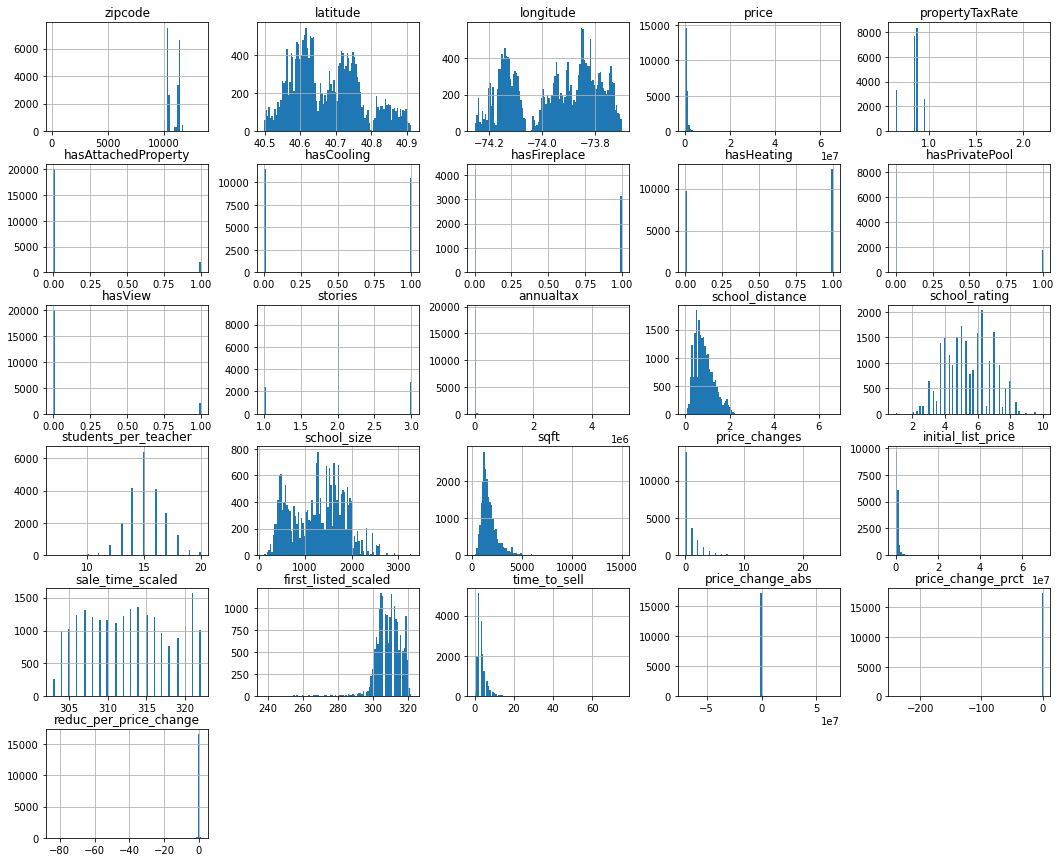

In [92]:
'''# check how our histograms are looking for our columns that seem to have outliers

df.hist(figsize=(18,15), bins=100);'''

For the square footage variables, I ultimately concluded that extremely large houses and lots are so seriously under-represented in the dataset that we won't be able to reliably predict on them anyway and they are better left off.

Ultimately I opt to remove via IQR on these items. 

In order to prevent a lot of data loss in this way, I kept IQR range of 1.6 instead of the standard 1.5

In [93]:
'''# determing our IQR for price, lot size, sq footage and longitude
lotlower,lotupper = iqr_outliers(df.lotSizeSqFt)
sqftlower, sqftupper = iqr_outliers(df.livingAreaSqFt)

# dropping the things outside of our lower and upper range
df.drop(df[ (df.lotSizeSqFt > lotupper) | (df.lotSizeSqFt < lotlower) ].index , inplace=True)
df.drop(df[ (df.livingAreaSqFt > sqftupper) | (df.livingAreaSqFt < sqftlower) ].index , inplace=True)'''

'# determing our IQR for price, lot size, sq footage and longitude\nlotlower,lotupper = iqr_outliers(df.lotSizeSqFt)\nsqftlower, sqftupper = iqr_outliers(df.livingAreaSqFt)\n\n# dropping the things outside of our lower and upper range\ndf.drop(df[ (df.lotSizeSqFt > lotupper) | (df.lotSizeSqFt < lotlower) ].index , inplace=True)\ndf.drop(df[ (df.livingAreaSqFt > sqftupper) | (df.livingAreaSqFt < sqftlower) ].index , inplace=True)'

#### Manually locating price outliers

In [94]:
'''# we're using the median house value for a zip code to determine the zip code's sort, so we can visualize the zip code

# group our dataframe by zipcode on median home price, sorted ascending. 
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1

# function that looks up a segment that a data entry belongs to
def make_group(x, frame, column):
    y = frame.loc[(frame.index == x)][column]
    z = np.array(y)
    z[0]
    return z[0]

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df['zip_rank'] = df['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

# apply the median home price per zip code to the data frame
df['median_zip'] = df['zipcode'].apply(lambda x: round(df.loc[df['zipcode']==x]['price'].median(), 0))'''

''

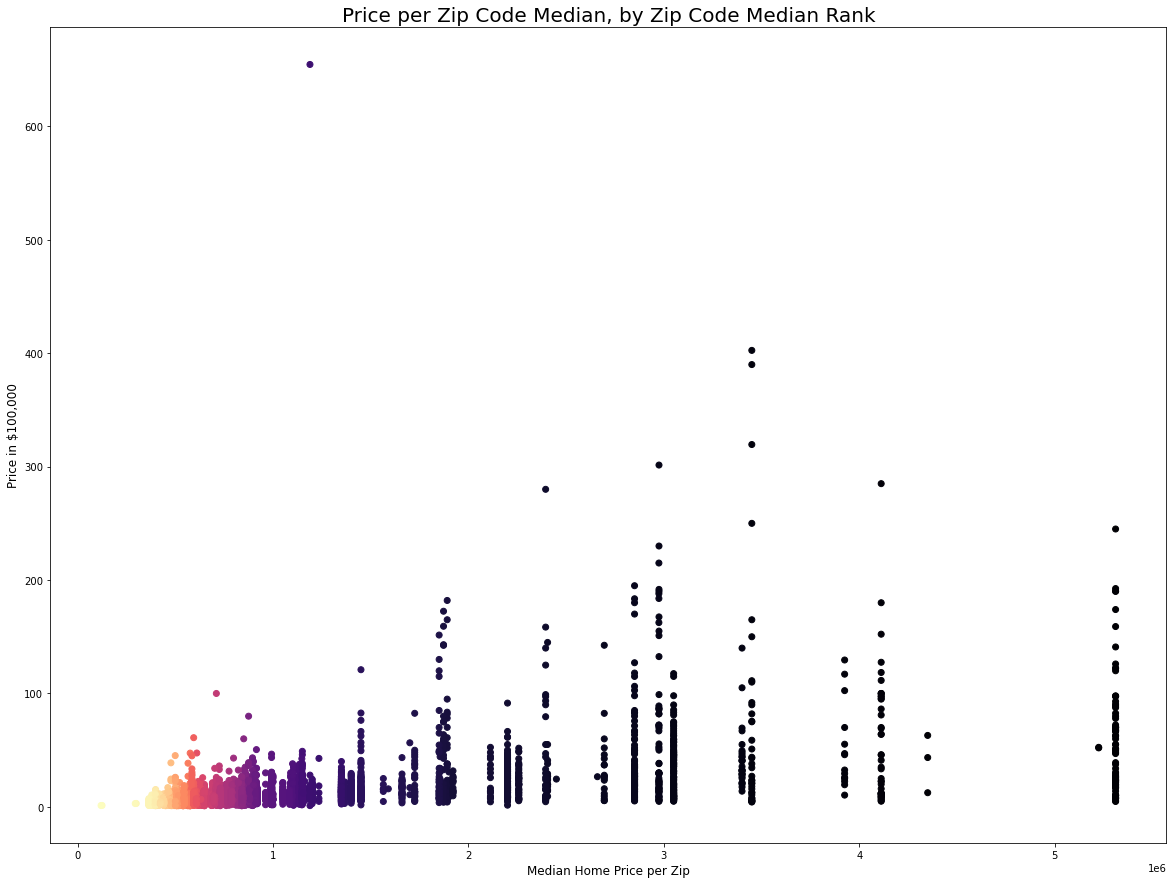

In [95]:
'''# visualize zip code as a color function

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Median Home Price per Zip', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Zip Code Median, by Zip Code Median Rank', fontsize=20)
;'''

We can see some clear outliers in this data set. We'll take care of removing those, and then come back to this visual again later after we've done some cleanup.

In [96]:
# A lot of our variables are not normally shaped, so we can't reliably remove outliers via standard deviation.
# We will use IQR to remove our outliers with the following function

def iqr_outliers(column):
    """return the lower range and upper range for the data based on IQR*1.6"""
    Q1,Q3 = np.percentile(column , [25,75])
    iqr = Q3 - Q1
    lower_range = Q1 - (1.6 * iqr)
    upper_range = Q3 + (1.6 * iqr)
    return lower_range,upper_range  

In [97]:
# Eliminating outliers on a per-zipcode basis using our IQR 1.6

zipcodes = df['zipcode'].unique()

for i in zipcodes:
    lower, upper = iqr_outliers(df[df['zipcode'] == i]['price'])
    df.drop(df[ ( (df.price > upper) & (df['zipcode'] == i) ) | ( (df.price < lower)  & (df['zipcode'] == i) ) ].index , inplace=True)


In [98]:
# anything under 100k is no way a legitimate market value sale. 
# anything in this range is certainly a inter-family sale,
# non-commercial, some weird sale type.
# We are dropping all of those. 
df.drop(df.loc[(df['price'] <= 100000)].index, axis=0, inplace=True)

Redo our zip code visual after outlier removal

In [99]:
# we're using the median house value for a zip code to determine the zip code's sort, so we can visualize the zip code

# group our dataframe by zipcode on median home price, sorted ascending. 
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1

# function that looks up a segment that a data entry belongs to
def make_group(x, frame, column):
    y = frame.loc[(frame.index == x)][column]
    z = np.array(y)
    z[0]
    return z[0]

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df['zip_rank'] = df['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

# apply the median home price per zip code to the data frame
df['median_zip'] = df['zipcode'].apply(lambda x: round(df.loc[df['zipcode']==x]['price'].median(), 0))

''

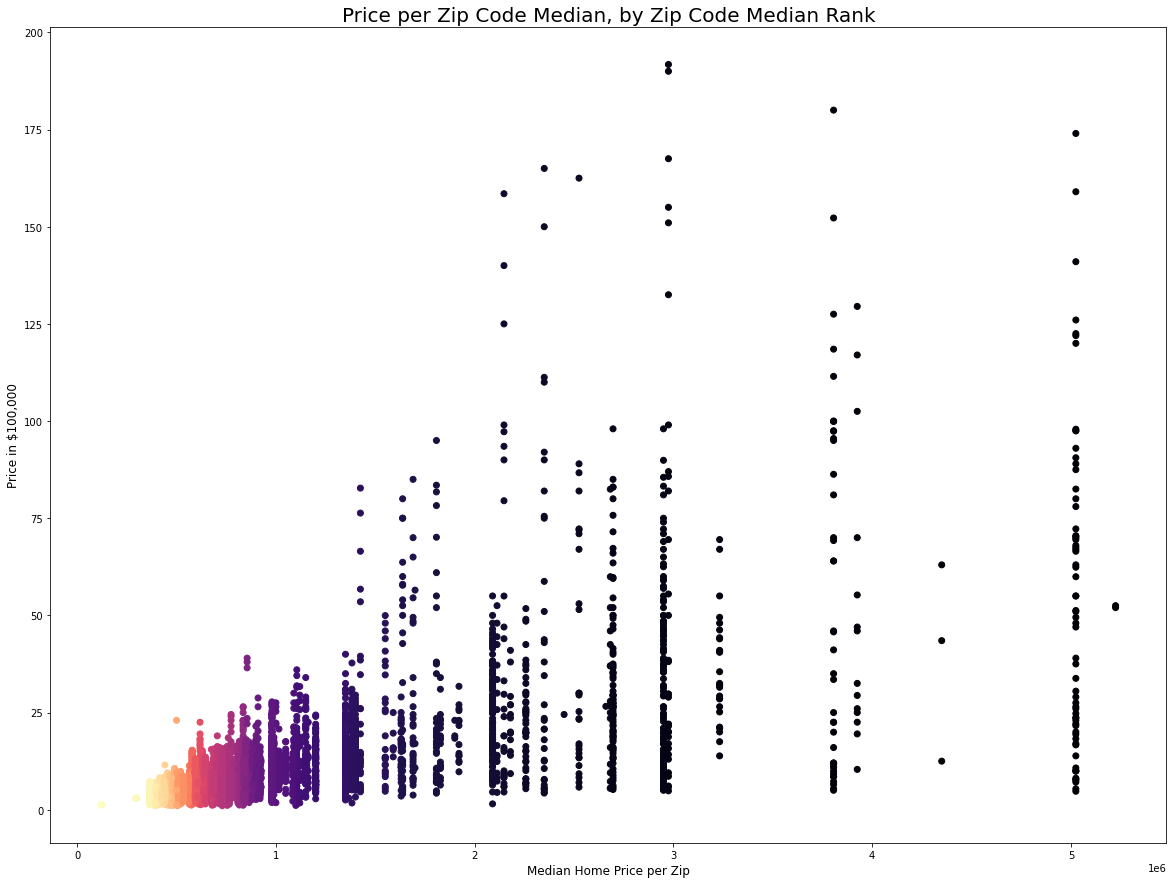

In [100]:
'''# visualize zip code as a color function

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Median Home Price per Zip', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Zip Code Median, by Zip Code Median Rank', fontsize=20)
;'''

In [101]:
# check price stats by zip code and displaying top 30 zip codes by mean
find_zip_outliers = df.groupby('zipcode')['price'].describe()
find_zip_outliers.sort_values('mean', ascending=False).head(35)
# very suspicious values in many zip codes for min

,count,mean,std,min,25%,50%,75%,max
zipcode,,,,,,,,
10028.0,33.0,5.759394e+06,5.782193e+06,485000.0,1700000.0,2975000.0,8575000.0,19175000.0
10014.0,66.0,5.449620e+06,4.044236e+06,475000.0,2174862.5,5025000.0,7656250.0,17400000.0
10065.0,42.0,5.349821e+06,4.657323e+06,500000.0,1181250.0,3806000.0,9537500.0,18000000.0
10007.0,14.0,5.232417e+06,3.836059e+06,1037500.0,2525000.0,3925000.0,6631250.0,12950000.0
10069.0,2.0,5.225000e+06,3.535534e+04,5200000.0,5212500.0,5225000.0,5237500.0,5250000.0
10021.0,33.0,4.397455e+06,4.380706e+06,427500.0,1060000.0,2350000.0,7500000.0,16500000.0
10003.0,30.0,4.343327e+06,4.496475e+06,455000.0,908750.0,2147500.0,7336875.0,15850000.0
10075.0,27.0,4.074631e+06,3.682681e+06,580000.0,1395000.0,2525000.0,6900000.0,16250000.0
10009.0,3.0,3.966333e+06,2.547263e+06,1249000.0,2799500.0,4350000.0,5325000.0,6300000.0


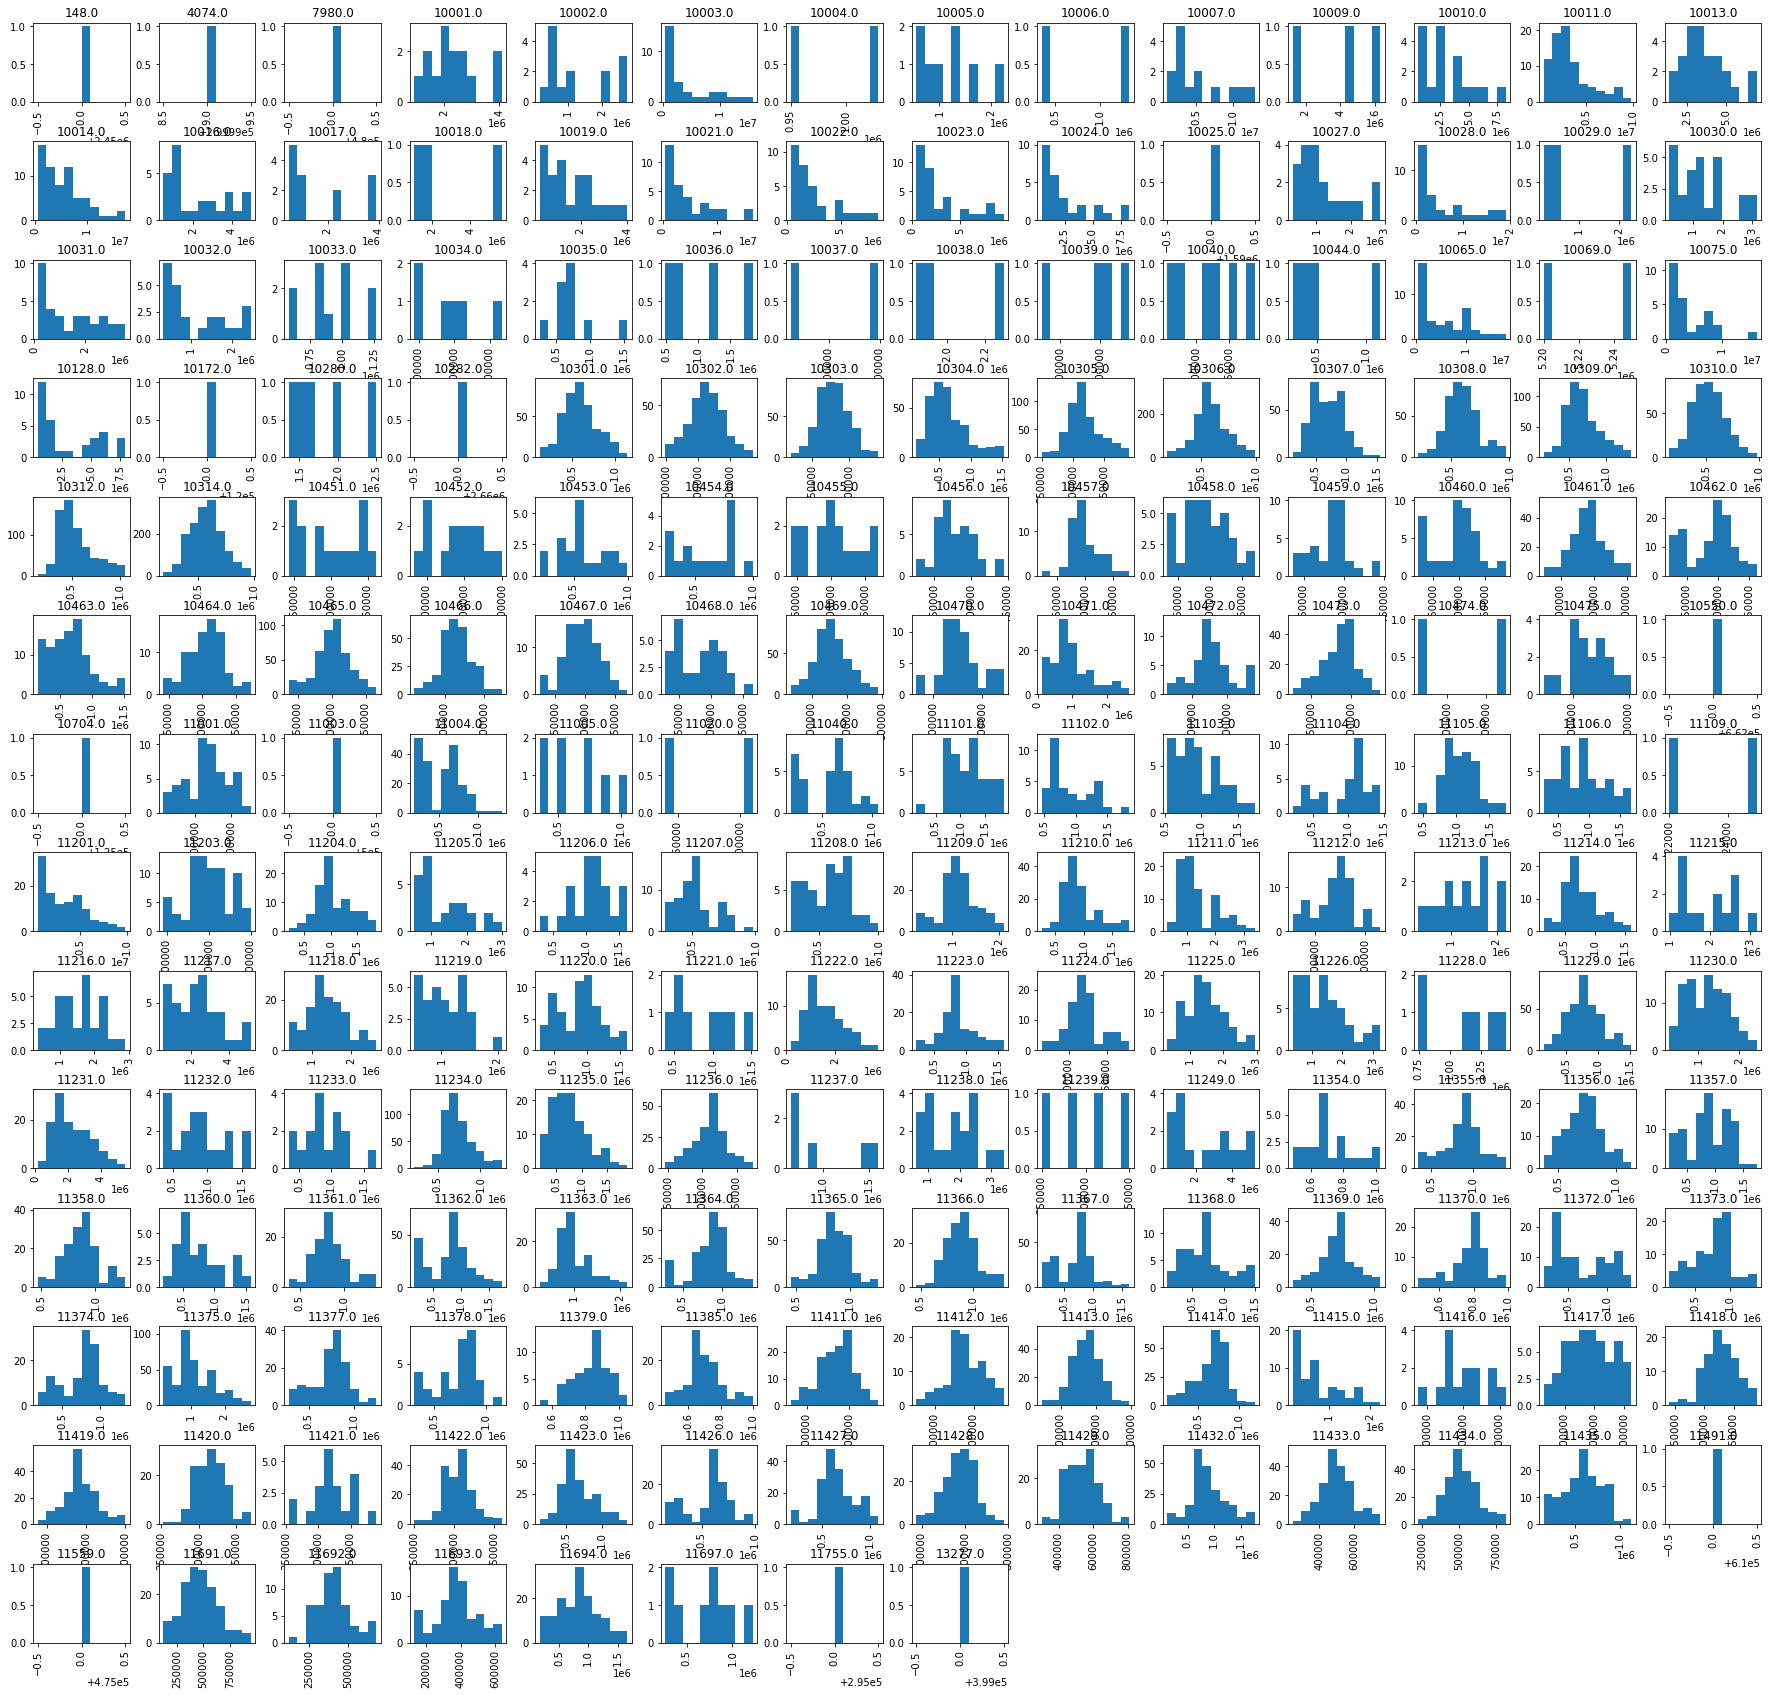

In [102]:
'''#We can check our price per zip code histograms.

df['price'].hist(by=df['zipcode'], figsize=(30,30));    

# some of our zip codes don't have enough sales to give us information'''

In [103]:
# apply the median price per square foot per zip code to the data frame
df['pr_sqft'] = df.apply(lambda x: round( (x['price'] / x['sqft'] ), 0), axis=1 )

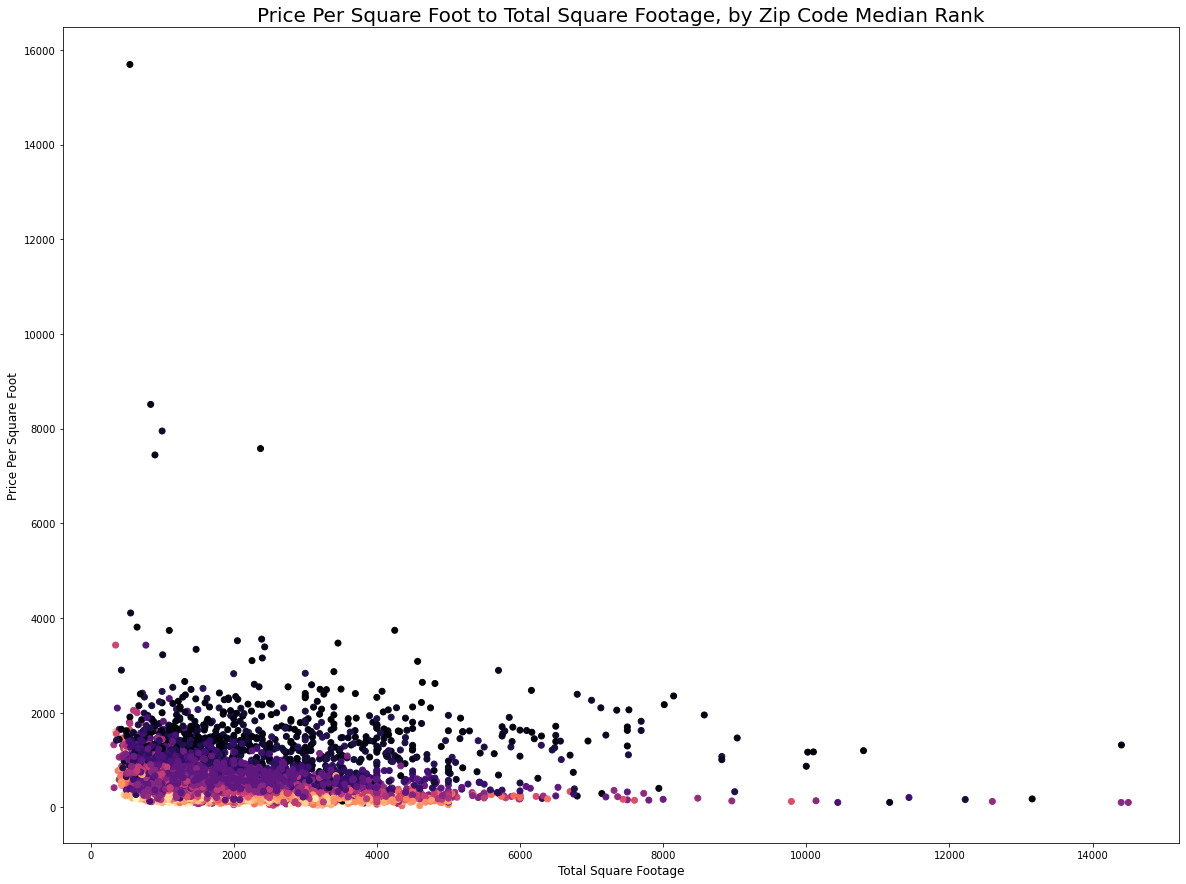

In [104]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['sqft'], df['pr_sqft'], c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Total Square Footage', fontsize=12)
ax.set_ylabel('Price Per Square Foot', fontsize=12)
ax.set_title('Price Per Square Foot to Total Square Footage, by Zip Code Median Rank', fontsize=20);

# save visualization to png
#plt.savefig('images/zip_prices.png')

In [105]:
#dropping irrationally high pr/sqft
df.drop(df[df['pr_sqft']>4000].index, inplace=True)

''

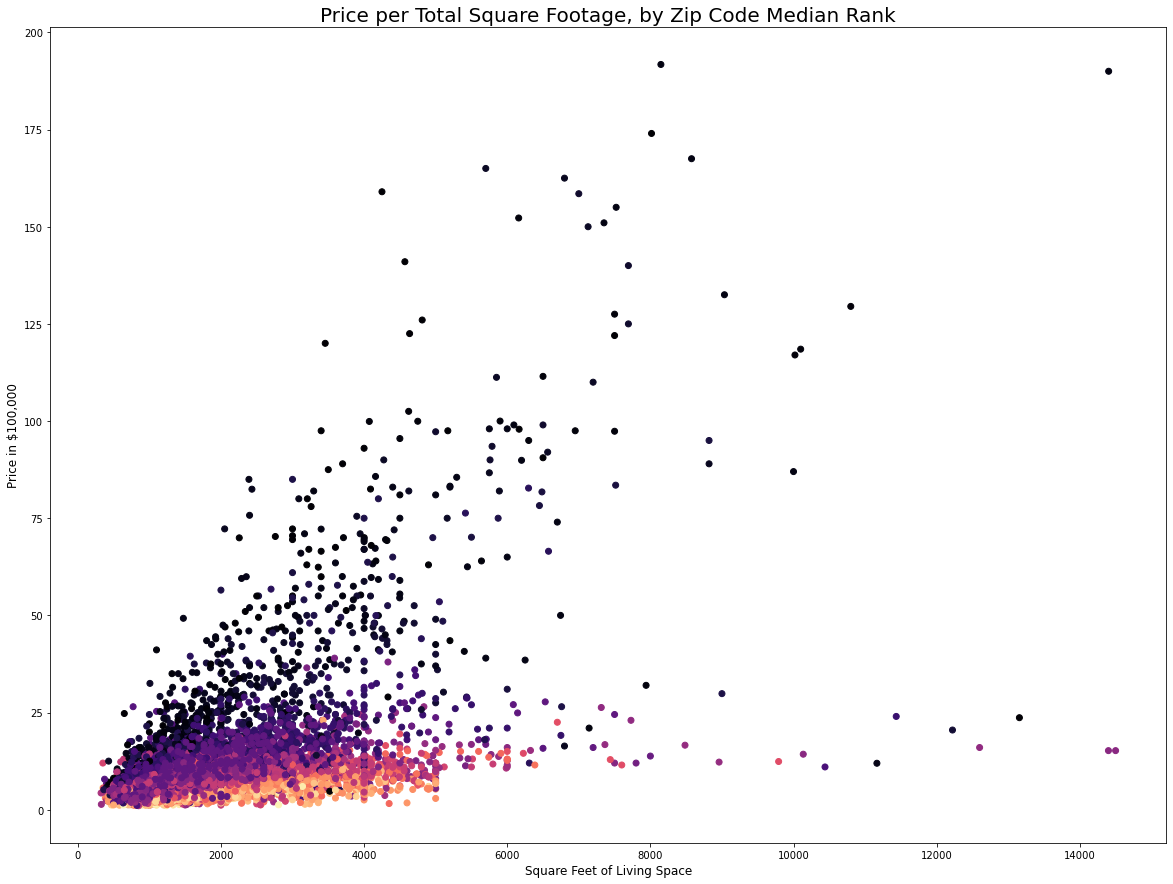

In [106]:
# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['sqft'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Footage, by Zip Code Median Rank', fontsize=20)
;

In [107]:
low_zips = df.loc[df['median_zip']<df['price'].mean()]
high_zips = df.loc[df['median_zip']>=df['price'].mean()]

''

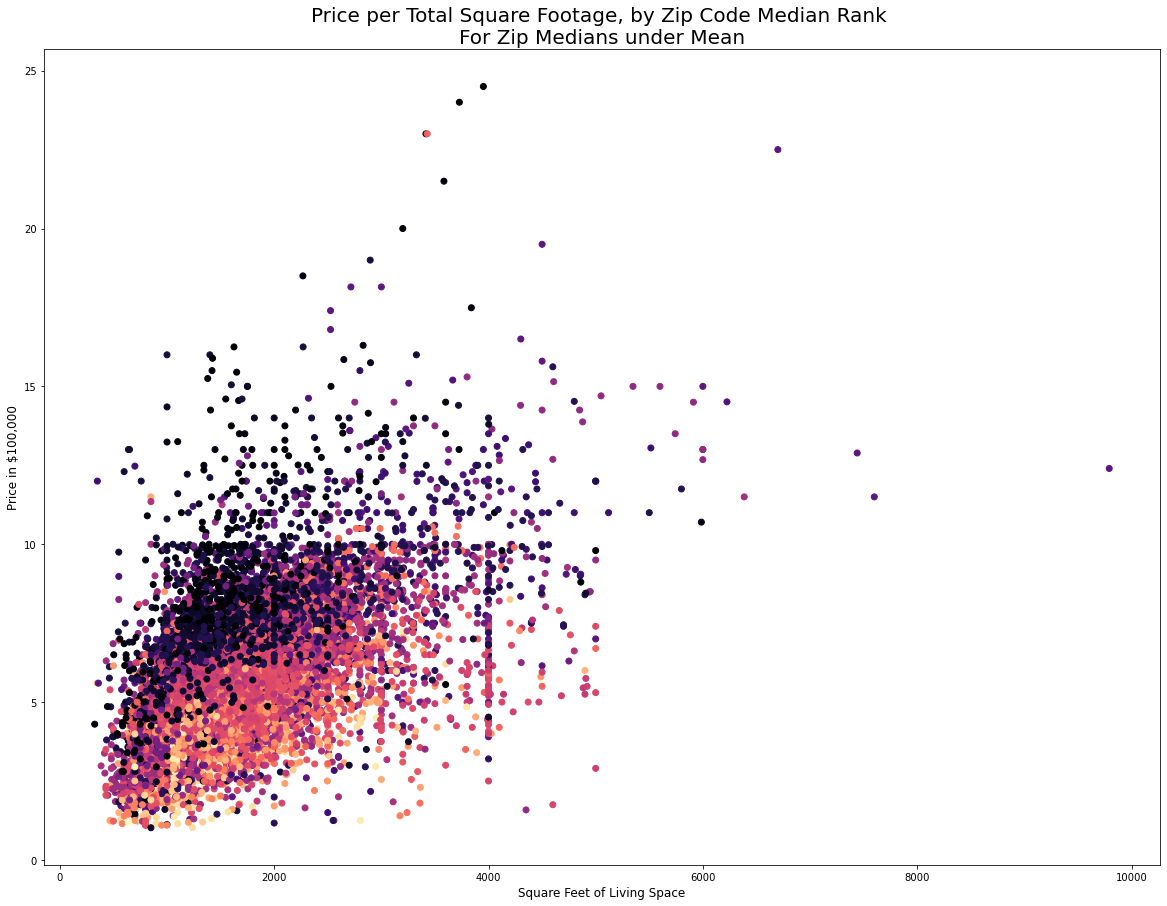

In [108]:
# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(low_zips['sqft'], low_zips['price'] /100000, c=low_zips['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Footage, by Zip Code Median Rank \nFor Zip Medians under Mean', fontsize=20)
;

''

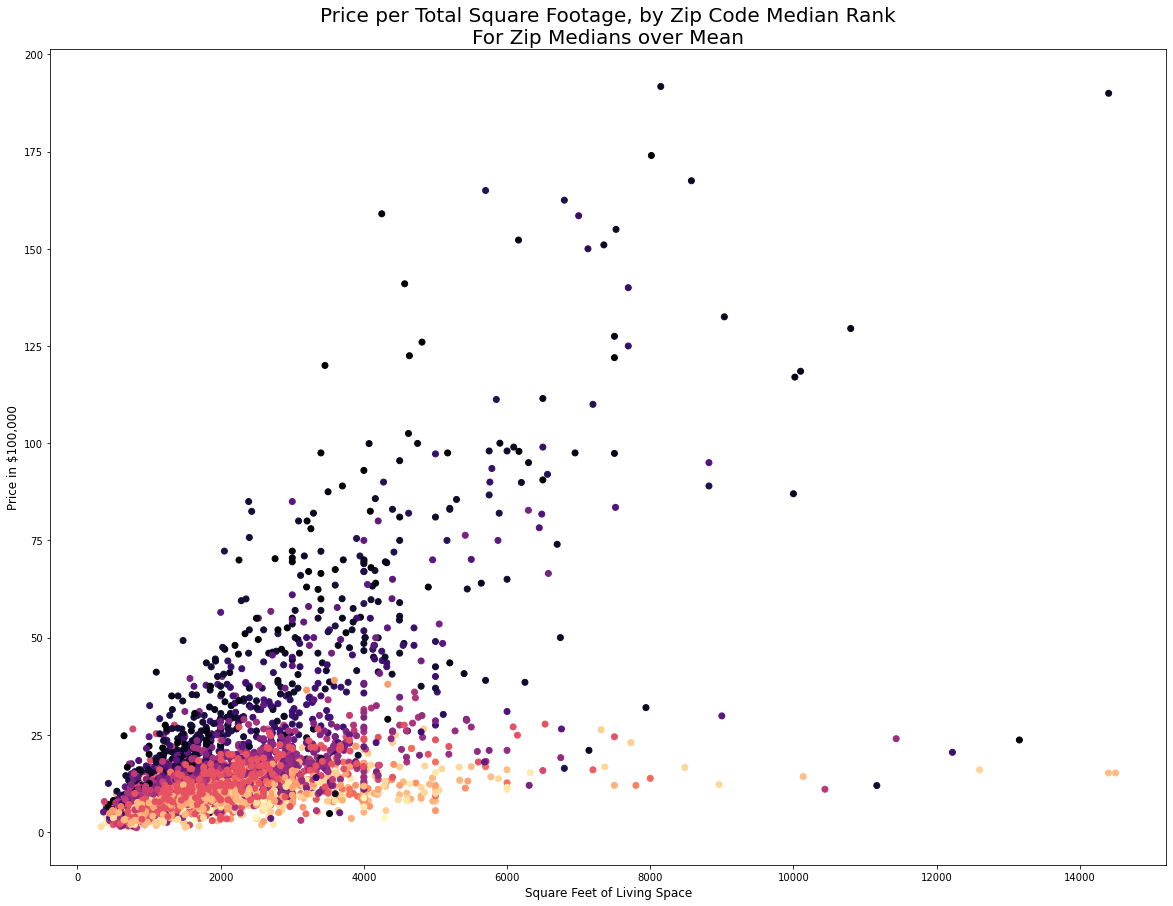

In [109]:
# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(high_zips['sqft'], high_zips['price'] /100000, c=high_zips['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Footage, by Zip Code Median Rank\nFor Zip Medians over Mean', fontsize=20)
;

Here's a fun way to see the improvements to our data quality after we clean outliers! A much deeper color map.

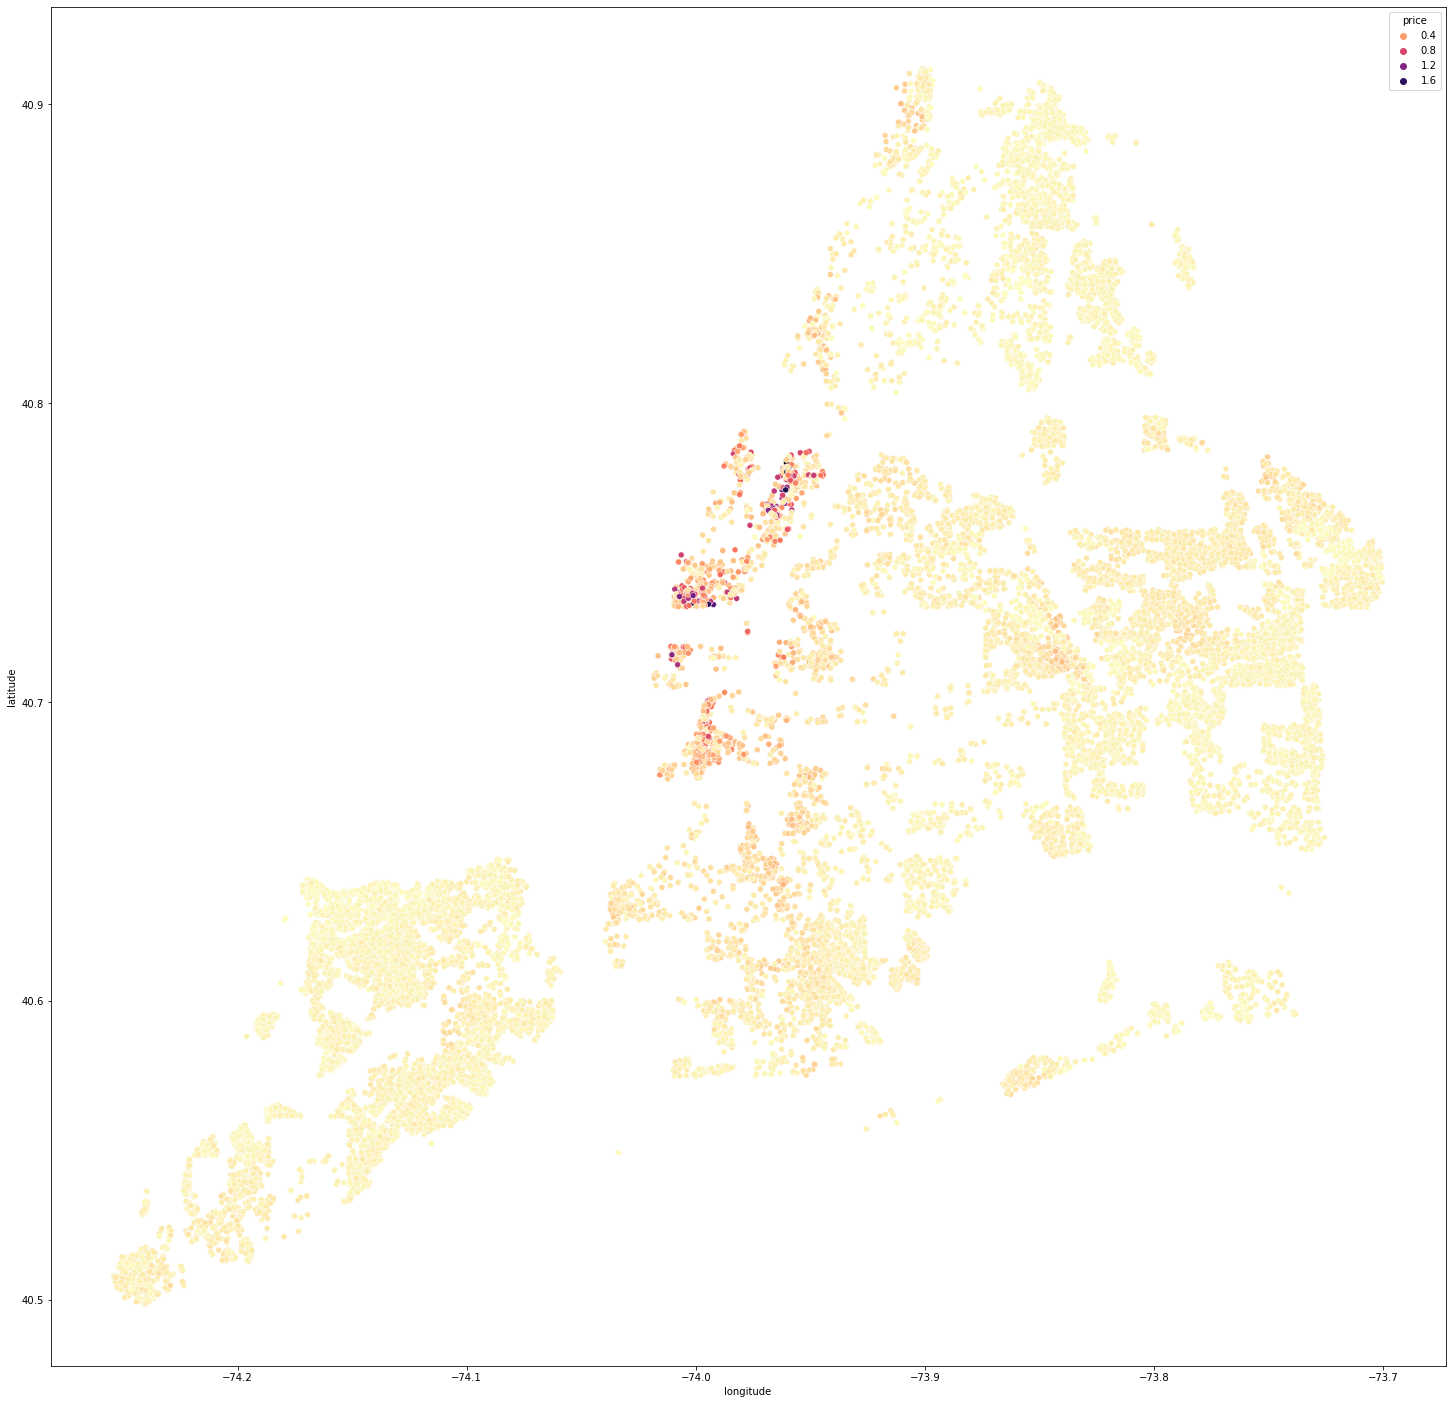

In [110]:
# plotting latitude and longitude as a visual scatter plot. The improved color map actually visually demonstrates
# the removal of extreme price outliers.

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="price", palette="magma_r");

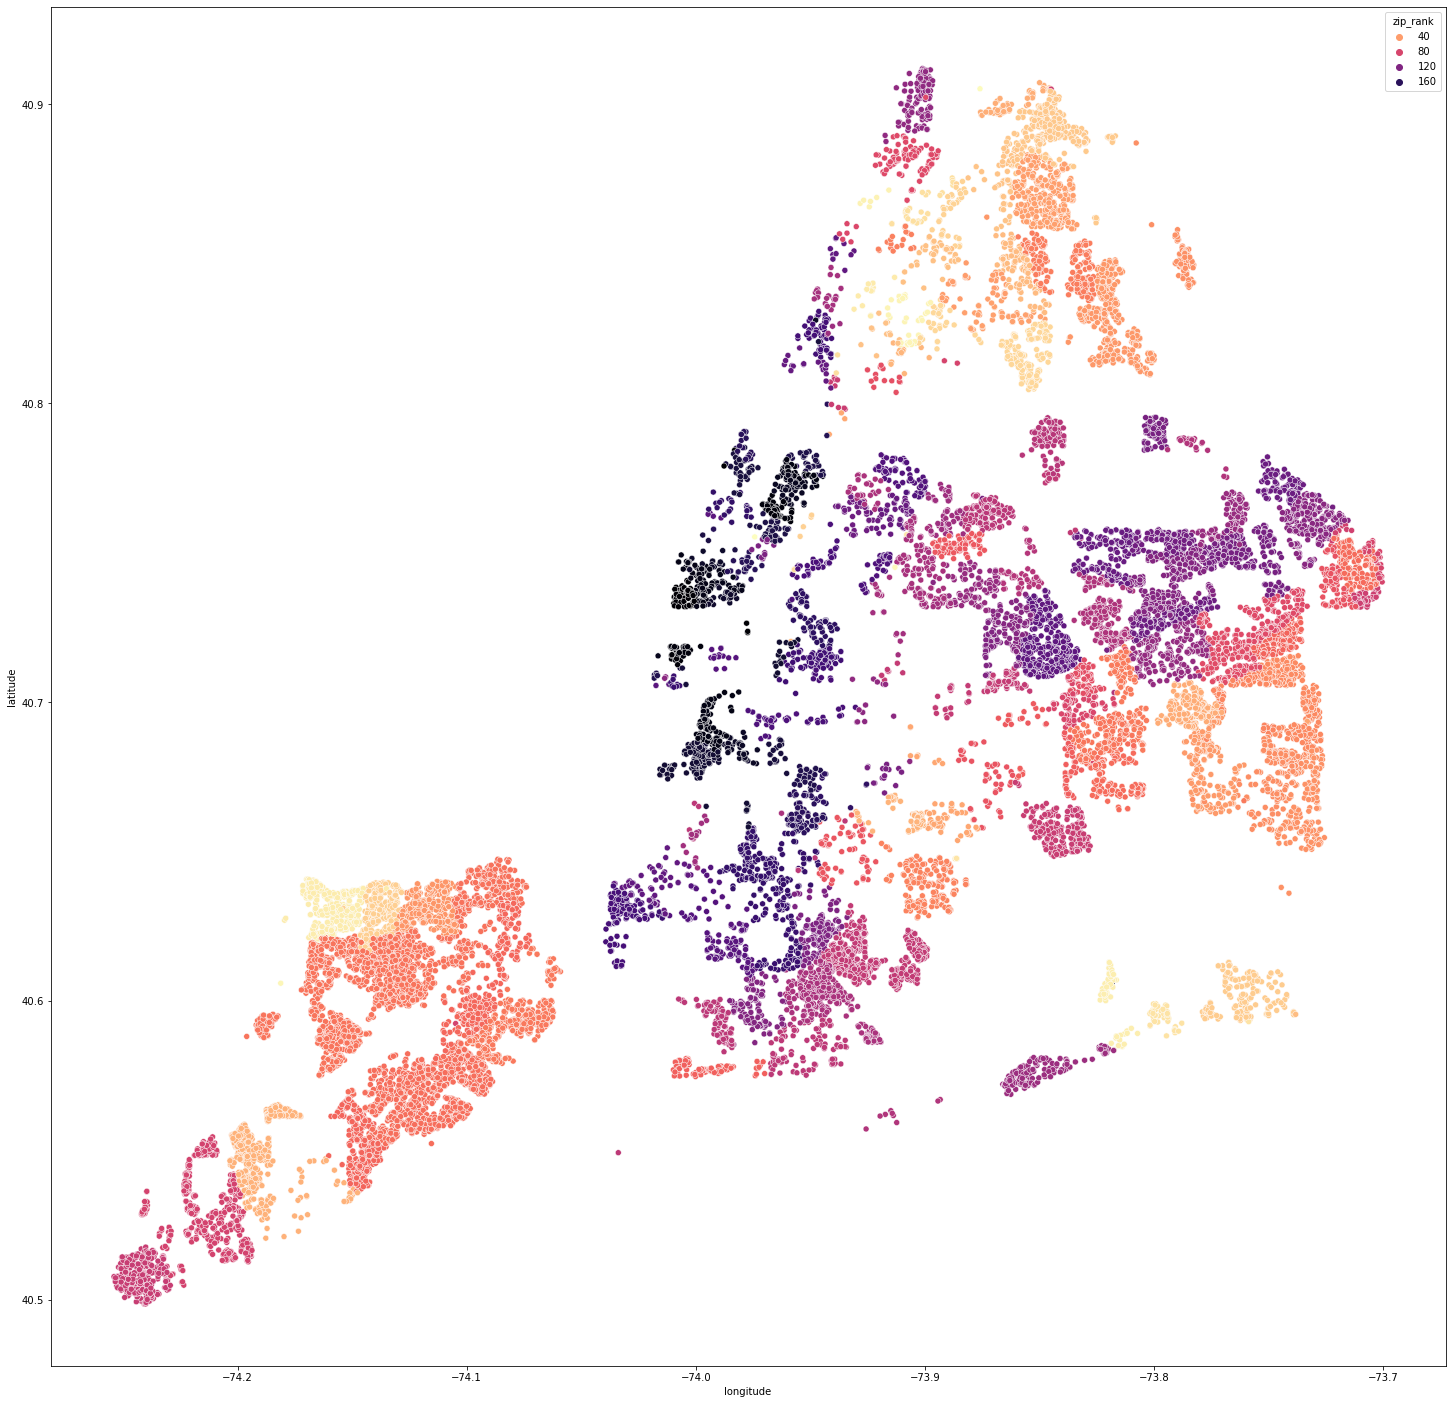

In [111]:
# we can also map our zip codes in this way.

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="zip_rank", palette="magma_r");

### Missing Data

In [133]:
df.isna().sum()

address                       0
zipcode                       0
description                1762
homeStatus                    0
latitude                      0
longitude                     0
price                         0
propertyTaxRate               2
appliances1                6328
appliances2                9016
appliances3               11422
appliances4               15504
architectural             15580
Lot_size                   3303
hasBasement                   0
cityRegion                    0
hasAttachedProperty           0
hasCooling                    0
hasFireplace                  0
hasHeating                    0
hasPrivatePool                0
hasView                       0
homeType                      0
specialroom1               8372
specialroom2              15117
stories                    7229
style                     13357
annualtax                  2397
zoning                    15019
school_distance               0
school_rating                 0
students

In [124]:
df['zoning'].unique()

array([nan, 'R1-2', 'R3X', 'R3-1', 'R-3X', 'R3-X', 'R3-2', 'R-3-2', 'R-2',
       'R-31', 'R2', 'R 3-2', 'R32', 'R-1-2', 'B2', 'RES', 'R31', 'R 2',
       'R3-A', 'R3A', 'R3 A', 'R-3A', 'M1-1', 'R-32', 'R', 'C-3', 'C3-A',
       'R-3', 'A-5', 'A-2', 'R2A', 'R4', 'R5', 'M-2', 'R2-3', 'M2-1',
       'A-9', 'R3', 'M-1', 'M3-1', 'A-1', 'R-1', 'A5', 'C4-2', 'C8-1',
       'R-4', 'R3.2', 'R1-3', 'R3M1', 'R3-4', 'R1', 'A3-1', 'A2',
       'R3-2 / C1', 'R3-1/C1-1', 'R-5', 'R6-B', 'C4-1', 'R5-2', 'A2-1',
       'A9', 'R3-H', 'B-2', 'R-12', 'Rx3, SRD', 'R1-1', 'R2-1', 'R4-1',
       'C', 'R6', 'R5B', 'R 6', 'R4A', 'R 4', 'R41', 'R5D', 'R7-1',
       'MI-1', 'M1', 'R5/C1-2', 'A3-2', 'R-S2', 'R-6', 'R12', 'C-4-2',
       'R6A', 'A5-R3-1', 'R4B', 'R7-A', 'R-4q', 'R3-22', 'C3', 'A5/R3-2',
       'R2-2', 'C1-1', 'C-11', 'S-1', 'B1', 'T3-1', 'A522', 'R517',
       'R5, OP', 'B3', 'R-5B', 'R 4.1', 'A1', '23b', 'RES.', 'res', 'R6B'],
      dtype=object)

In [ ]:
# check data types

df.dtypes

# data types all look correct

### Binary Data

In [ ]:
# we're going to convert some of our ordinal features to binary 0/1
convert_to_bool = ['numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures', 'numOfWaterfrontFeatures', 'numOfWindowFeatures', 'numOfCommunityFeatures']

df_convert_to_bool = df[convert_to_bool]
df_convert_to_bool.describe()

In [ ]:
# Any element that has no features by the 50th percentile is getting converted to a binary 

# change all non-null values > 0 in those columns to 1
df.loc[df['numOfAccessibilityFeatures'] > 0, 'numOfAccessibilityFeatures'] = 1
df.loc[df['numOfPatioAndPorchFeatures'] > 0, 'numOfPatioAndPorchFeatures'] = 1
df.loc[df['numOfSecurityFeatures'] > 0, 'numOfSecurityFeatures'] = 1
df.loc[df['numOfWaterfrontFeatures'] > 0, 'numOfWaterfrontFeatures'] = 1
df.loc[df['numOfWindowFeatures'] > 0, 'numOfWindowFeatures'] = 1
df.loc[df['numOfCommunityFeatures'] > 0, 'numOfCommunityFeatures'] = 1

# now anything that is not a 1 becomes a 0
df.loc[df['numOfAccessibilityFeatures']!= 1, 'numOfAccessibilityFeatures'] = 0
df.loc[df['numOfPatioAndPorchFeatures'] != 1, 'numOfPatioAndPorchFeatures'] = 0
df.loc[df['numOfSecurityFeatures'] != 1, 'numOfSecurityFeatures'] = 0
df.loc[df['numOfWaterfrontFeatures'] != 1, 'numOfWaterfrontFeatures'] = 0
df.loc[df['numOfWindowFeatures'] != 1, 'numOfWindowFeatures'] = 0
df.loc[df['numOfCommunityFeatures'] != 1, 'numOfCommunityFeatures'] = 0

# rename to reflect binary
df.rename(columns={'numOfAccessibilityFeatures' : 'accessibility', 'numOfPatioAndPorchFeatures' : 'patioporch', 'numOfSecurityFeatures': 'security', 
                  'numOfWaterfrontFeatures': 'waterfront', 'numOfWindowFeatures' : 'windowfeatures', 'numOfCommunityFeatures' : 'community'}, inplace=True)

# convert original boolean columns to binary 0/1
boolean = ['hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa', 'hasView']

for item in boolean:
    df[boolean] = df[boolean].astype(int)

### Study Target Variable

In [ ]:
#histogram and normal probability plot
sns.distplot(df['price'], fit=norm);
fig = plt.figure()

res = stats.probplot(df['price'], plot=plt)

# our sales price histogram is positively skewed and has a high peak
# Our QQ-plot shows that we have heavy tails with right skew

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

# price is highly right skewed
# very positive kurtosis, indicating lots in the tails. We can see those tails in the right skew.

In [ ]:
# log transform our target price to improve normality of distribution
df_target_log = np.log(df['price'])

#histogram and normal probability plot
sns.distplot(df_target_log, fit=norm);
fig = plt.figure()
res = stats.probplot(df_target_log, plot=plt)

# Our target price is more normally distributed when log transformed, so we'll be doing that when we make our model


## Natural Language Processing

Our data set includes the listing text for each sale. We're going to use Natural Language Processing methods to extract relevant information from the listing text to boost the effectiveness of our model.

We're using spaCy and after basic package installation, we also need to download the english language pipeline.

In [ ]:
# Load spaCy with English language processor
nlp = spacy.load("en_core_web_sm")

# add real estate related stop words to default stop word list
nlp.Defaults.stop_words |= {"bedroom", "bathroom","bath","home", "austin", "tx", "pron", "sq", "ft", "rent", "mo",
                            "w", "bed", 'single', 'family', 'contain', 'st', 'dr', 'square', 'foot', 'room', 'square', 'feet',
                            '-pron-', 'garage', 'pflugerville', 'story', '1st', '1story', '2car', '2nd',
                            '2story', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', 'street', 'avenue', 'ave', 
                            'sac', 
                            
                           }

nlp.Defaults.stop_words.remove('is')
nlp.Defaults.stop_words.remove('as')

In [ ]:
# text processing functions for NLP

def preprocessor(word):
    '''processes an individual word to remove punctuation, numbers, special characters etc
    Returns processed word, or blank string if character removal resulted in no word
    ARGUMENT:
    word from line of text'''
    if type(word) == str:
        word = re.sub(r'[^\w\s]', '', word)
        word = re.sub('<[^>]*>', '', word)
        word = re.sub('<[0-9]*>', '', word)
        word = re.sub('[\W]+', '', word.lower())
        try:
            word = int(word)
            word = ''
            return word
        except:
            return word

def word_processor(line):
    '''Takes a line of text. Tokenizes each word of sentence. 
    If token is stop word, goes to next token. If not stop word,
    calls preprocessor on word
    Returns processed words from line
    ARGUMENT: 
    line of text'''
    
    tokens = nlp(line) # nlp reads line and creates tokens from each word  
    words = [] # empty list of words for this line
    
    for token in tokens:
        if token.is_stop == False: # only continues if token is not stop word
            token_preprocessed = preprocessor(token.lemma_) # calls preprocessor on word
            if token_preprocessed != '': # only continues if returned word is not empty
                words.append(token_preprocessed) # appends word to list of words
    return(words) # return list of words for this line

def text_block_processor(text):
    '''Takes a block of text. Divides block into sentences with words lemmatized.
    Sends each sentence to word processor. Concatenates all words into one string
    If the string contains "zestimate", returns a DEFAULT listing note
    Otherwise returns string of cleaned and processed words from text block
    ARGUMENTS:
    block of text
    '''
    
    make_sentences = nlp(text)
    
    sentences_lemmata_list = [sentence.lemma_.lower() for sentence in make_sentences.sents]
    
    these_processed_sentences = ''

    
    for item in sentences_lemmata_list:
        words = word_processor(item)
        line = ' '.join(words)
        these_processed_sentences += (' ' + line)
        
    if 'zestimate' in these_processed_sentences:
        return 'DEFAULT'
    else:
        return these_processed_sentences

In [ ]:
# reset indices on original data frame before making a copy
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [ ]:
'''# copy the description column to a new data frame for text processing
listing_text = pd.DataFrame(df['description'])
listing_text

# cleaning all of the text in our listing_text description field and adding it to the listing_text data frame 
sentences = []

listing_text['sentences'] = None

for row in listing_text.index:
    thistext = listing_text['description'][row]
    the_sentences = text_block_processor(thistext)
    listing_text['sentences'][row] = the_sentences
    sentences += the_sentences

# drop the description field and save our listing_text to file so we don't have to run it again
listing_text.drop('description', axis=1, inplace=True)

listing_text.to_pickle("listing_text.pkl")'''

In [ ]:
# loading our cleaned listing descriptions from file and saving those to a data frame
listing_desc = pd.read_pickle("listing_text.pkl")
listing_desc

In [ ]:
# append our listing text to our original data frame
df = pd.concat([df, listing_desc], axis=1)

df

## Create Holdout Set

We need to create our holdout data before any further processing.

The reasons for this are:
   * We will standardize our continuous variables, and you should standardize only on your train set and apply that to your test set.
   * We will be feature engineering on our train set, and applying that later to our test set. We cannot have our test set data leak into our engineered features.
   * We'll be doing some natural language processing, fitting on our train set and applying to our test set. We don't want data leakage for the same reasons as above.
    

In [ ]:
# set our random seed for the notebook. We could randomize this each time the notebook is run,
# but ultimately we want all of our train/test splits to use the same data
randomstate = 2

y = pd.DataFrame(df['price'])
x = df.drop('price', axis=1,)

# creating our train/validation sets and our test sets
train_data, holdout, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=randomstate)

# reset indices to prevent any index mismatches
train_data.reset_index(inplace=True)
train_data.drop('index', axis=1, inplace=True)

holdout.reset_index(inplace=True)
holdout.drop('index', axis=1, inplace=True)

y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

## Feature Engineering

In [ ]:
# Adding target encoding, which we will opt to try instead of one-hot with a few models

# smooth mean function by MAx Halford at https://maxhalford.github.io/blog/target-encoding/

def calc_smooth_mean(df, by, on, m, target_df):
    '''input a pandas.DataFrame, a categorical column name, the name of the target column, and a weight .'''
    # Compute the global mean
    mean = df[on].mean() 

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])  
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return round(target_df[by].map(smooth), 0) 

num_of_samples = train_data.shape[0]
zip_samples = num_of_samples/train_data['zipcode'].unique().shape[0]
month_samples = num_of_samples/train_data['latest_salemonth'].unique().shape[0]


# create smooth additive encoded variables for zipcode, year built, and monthsold
train_data['zip_smooth'] = calc_smooth_mean(train_data, 'zipcode', 'price', zip_samples, train_data)
train_data['year_smooth'] = calc_smooth_mean(train_data, 'yearBuilt', 'price', 300, train_data)
train_data['month_smooth'] = calc_smooth_mean(train_data, 'latest_salemonth', 'price', month_samples, train_data)

# Create a wider lat and long zone to calculate an area mean
train_data['lat_zone'] = round(train_data['latitude'], 2)
train_data['long_zone'] = round(train_data['longitude'], 2)

lat_samples = num_of_samples/train_data['lat_zone'].unique().shape[0]
long_samples = num_of_samples/train_data['long_zone'].unique().shape[0]

# calculate smooth mean variables for lat and long, then create an interactive variable describing both together
train_data['lat_smooth'] = calc_smooth_mean(train_data, 'lat_zone', 'price', lat_samples, train_data)
train_data['long_smooth'] = calc_smooth_mean(train_data, 'long_zone', 'price', long_samples, train_data)
train_data['lat_long'] = round(np.sqrt(train_data['lat_smooth']) + np.sqrt(train_data['long_smooth']), 0)

## Correlations/Multicollinearity

In [ ]:
# look for multicollinearity of features
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(train_data.corr(), center=0,  
           vmin=-1, vmax=1,  square=True)

# title
plt.title('PEARSON CORRELATION MATRIX', fontsize=18)

plt.show()

In [ ]:
train_data.corr()

In [ ]:
#Get our list of highly correlated feature pairs with following steps:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
df_correlations = train_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 75% correlation and below 90% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.95)]


In [ ]:
# Check out our variables correlationg with price
df_correlations = train_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_correlations.loc[df_correlations['level_0'] == 'price'].sort_values(0, ascending=False)

We'll not use:

* parkingSpaces, hasGarage, numOfParkingFeatures and keep garageSpaces (higher relationship with Price)
* numOfElementarySchools, and keep numOfPrimarySchools (higher relationship with Price)
* MedianStudentsPerTeacher, keeping avgSchoolRating
* numOfBathrooms correlates with square footage, but I'm not dropping either

We can get a sense of the most important features to our price from our correlation table. Zipcode as a plain variable does not correlate, which makes sense, because without some sort of transformation it is an arbitrary unordered number. We can see how transformed as median_zip or zip_rank it becomes the MOST important contributor to price. We can see here that big contributors to price include
    
    * Lat/long in a target encoded form
    * zip code (in some altered form, not as arbitrary number)
    * livingAreaSqFt
    * numBathrooms
    * avgSchoolRating
    * lotSizeSqFt

In [ ]:
# combine all school counts into a single field
train_data['numOfSchools'] = train_data['numOfPrimarySchools'] + train_data['numOfElementarySchools'] + train_data['numOfMiddleSchools'] + train_data['numOfHighSchools']
holdout['numOfSchools'] = holdout['numOfPrimarySchools']  + holdout['numOfElementarySchools'] + holdout['numOfMiddleSchools'] + holdout['numOfHighSchools']

## EDA and Processing Train Set

### Categoricals

In [ ]:
categories = ['zipcode', 'yearBuilt', 'hasAssociation', 'hasCooling', 'hasHeating', 'hasSpa', 'hasView', 'accessibility', 'patioporch', 'security',
          'waterfront', 'windowfeatures', 'community', 'latest_salemonth', 'numOfSchools', 'garageSpaces', 'propertyTaxRate', ]

df_categoricals = train_data[categories]

In [ ]:
# adding price to our dataframe so that we can do some visualizations    

df_categoricals['price'] = train_data['price']

# plot our categoricals as box plots vs price
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
f = pd.melt(df_categoricals, id_vars=['price'], value_vars=categories)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")

df_categoricals.drop('price', axis=1, inplace=True)

In [ ]:
# there is only ONE listing with 5 schools, so we will change that one to 4
df_categoricals.loc[df_categoricals['numOfSchools']==5, 'numOfSchools'] = 4

# binning our year built bins

num_bins = 30
labels = np.array(range(1,num_bins+1))
df_categoricals["year_block"] = pd.qcut(df_categoricals['yearBuilt'], q=num_bins, labels=labels)

df_categoricals.drop('yearBuilt', axis=1, inplace=True)

# telling Pandas that these columns are categoricals
for item in df_categoricals.columns:
    df_categoricals[item] = df_categoricals[item].astype('category')
    
# make a processed bins file for use with linear regression
# We're making TWO categorical sets. One is high one hot encoding. One is low one hot encoding, and the 
# categoricals in that one will be target encoded as continuous instead

high_one_hot_cat =  ['zipcode', 'year_block', 'hasAssociation', 
                 'hasCooling', 'hasHeating', 'hasSpa', 'hasView', 
                 'accessibility', 'patioporch', 'security', 'numOfSchools',
              'waterfront', 'windowfeatures', 'community', 'latest_salemonth',
                    'garageSpaces', 'propertyTaxRate', ]
low_one_hot_cat =  ['hasAssociation', 
                'hasCooling', 'hasHeating', 'hasSpa', 
                'hasView', 'accessibility', 'patioporch', 'numOfSchools',
                'security', 'waterfront', 'windowfeatures', 'community', 'garageSpaces', 'propertyTaxRate', ]

df_cats_high_one_hot = pd.get_dummies(df_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=True)
df_cats_low_one_hot = pd.get_dummies(df_categoricals[low_one_hot_cat], prefix=low_one_hot_cat, drop_first=True)

### Continuous

In [ ]:
continuous = ['numPriceChanges', 
              'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 
              'avgSchoolRating', 'avgSchoolSize', 'numOfBedrooms', 
              'numOfStories', 'numOfPhotos', 
              'numOfAppliances', 'latest_salemonth',
             'zip_smooth', 'year_smooth', 'month_smooth', 'lat_long'] 

x_continuous = train_data[continuous]
x_continuous['price'] = train_data['price']

In [ ]:
small_cont = ['numPriceChanges', 
              'avgSchoolRating', 'numOfBedrooms', 
              'numOfStories', 'numOfAppliances', 
              'latest_salemonth']
# plot our continuous as box plots vs price
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(x_continuous, id_vars=['price'], value_vars=small_cont)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")


In [ ]:
large_cont = ['lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 
              'avgSchoolRating', 'avgSchoolSize', 'numOfPhotos',
             'zip_smooth', 'year_smooth', 'month_smooth', 'lat_long']

# check linearity of continuous predictors

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,25), sharey=True)

for ax, column in zip(axes.flatten(), large_cont):
    ax.scatter(x_continuous[column], x_continuous['price']/100000, label=column, alpha=.1)
    ax.set_title(f'Sale Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()

Positive relationship observed with:
* lot size
* square footage
* school rating
* number of bedrooms
* lat/long

Negative relationship observed with:
* number of price changes

Others seem neutral/uncertain

In [ ]:
# Checking out our mean sales price for year built scattered versus price shows a polynomial relationship

yearly_prices = train_data.groupby('latest_salemonth')['price'].mean()

plt.scatter(yearly_prices.index, yearly_prices)
plt.title("Linearity check")
plt.xlabel('year built')
plt.ylabel('sales price')
plt.show()

Our average per month looks polynomial.

In [ ]:
# Checking out our mean sales price for latitude  scattered versus price shows a polynomial relationship
lat_prices = train_data.groupby('livingAreaSqFt')['price'].mean()

plt.scatter(lat_prices.index, lat_prices)
plt.title("Linearity check")
plt.xlabel('lat')
plt.ylabel('sales price')
plt.show()

This looks linear

In [ ]:
# Checking out our mean sales price for lot size scattered versus price shows a polynomial relationship
lat_prices = train_data.groupby('lotSizeSqFt')['price'].mean()

plt.scatter(lat_prices.index, lat_prices)
plt.title("Linearity check")
plt.xlabel('lat')
plt.ylabel('sales price')
plt.show()

This looks somewhat linear

In [ ]:
# Checking out our mean sales price for average school size, scattered versus price shows a polynomial relationship
lat_prices = train_data.groupby('avgSchoolSize')['price'].mean()

plt.scatter(lat_prices.index, lat_prices)
plt.title("Linearity check")
plt.xlabel('lat')
plt.ylabel('sales price')
plt.show()

This looks meaningless

#### Finding Interactions

I wrote a function which finds all of the feature combinations possible in our dataset. Then for each combination, the function runs a linear regression with cross validation on 5 folds and gets the r^2 score for the regression including that feature combination. All scores are recorded and r^2 score improvement is assessed, with the resulting table giving the increase in model improvement from a feature combo. 

In [ ]:
def test_feature_combinations(price, variables):
    
    """Function takes in target price and a dataframe of independent variables, and 
    tests model improvement for each combination of variables
    ARGUMENTS:
    Y of target values
    X-dataframe of continuous features
    Returns dataframe of score improvements over base score for each interaction combination"""
    
    # select our estimator and our cross validation plan
    regression = LinearRegression()
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
    
    # prepare our scoring dataframe
    scoring_df = pd.DataFrame()
    
    # prepare our lists to store our features and scores as we iterate
    scores = []
    feature1 = []
    feature2 = []
    
    # Get a list of all of our features, and remove our target variable 'price' from the list
    features = list(variables.columns)

    # make a list of all of our possible feature combinations
    feature_combos = itertools.combinations(features, 2)
    feature_combos = list(feature_combos)
    
    # set our y-value as our target variable
    y = price
    
    # prepare our x-value with our independent variables. We do an initial split here in order to run a 
    # linear regression to get a base r^2 on our basic model without interactions
    X = variables
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)
    base_score = round(np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=cv)), 4)   
    print("Model base score is ",base_score)
    
    # now we run the regression on each feature combo
    for feature in feature_combos:
        feat1, feat2 = feature[0], feature[1]
        
        # create the test interaction on our data set
        variables['test_interaction'] = variables[feat1] * variables[feat2]
        # create a new X which includes the test interaction and drops our target value
        X = variables
        # make a new split so that our x-splits include the test interaction
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)
        
        # Run a linear regression with cross-val just like our base model, and append the score to our scores list
        new_score = round(np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=cv)), 4)
        scores.append(new_score)
        # put feature 1 on a list
        feature1.append(feat1)
        # put feature 2 on a list
        feature2.append(feat2)
        print(feat1, feat2, new_score)
        
        
    
    # load all of our lists into the scoring dataframe
    scoring_df['feature1'] = feature1
    scoring_df['feature2'] = feature2
    scoring_df['scores'] = scores
    scoring_df['improvement'] = scoring_df['scores'] - base_score
    variables.drop('test_interaction', axis=1, inplace=True)
    
    # return our scoring dataframe to the function
    return scoring_df

In [ ]:
# running our function on our continuous variables to look for improvement
# our R2 is much lower for model base score because we aren't including our categorical variables in this improvement assessment

scoring_df = test_feature_combinations(y_train, x_continuous)

In [ ]:
# showing our improvement scores for our interactions

scoring_df.sort_values('improvement', ascending=False)

We see there might be a relationship between square footage and our zip code. This makes sense because the size of the house is differently priced depending on location, as we saw in our visualizations earlier.

####  Transform and Standardize

In [ ]:
# check out our histograms

x_continuous.hist(figsize=(18,15), bins='auto');

In [ ]:
x_continuous.describe()

In [ ]:
x_continuous['sqft-zip'] = np.sqrt(x_continuous['livingAreaSqFt']) + np.sqrt(x_continuous['zip_smooth'])

In [ ]:
# don't need price in there anymore
x_continuous.drop('price', axis=1, inplace=True)

# We're going to log transform our continuous variables, so we need to add a slight number to our zero values
x_continuous.loc[x_continuous['numOfAppliances']==0, 'numOfAppliances'] = .1

# log transform
log_continuous = np.log(x_continuous)

# standardize all of our values with scikit-learn StandardScaler
scaler = StandardScaler()

#transformed_scaled_continuous = pd.DataFrame(scaler.fit_transform(x_train_cont_log),columns = x_train_cont_log.columns)
scaled_continuous = pd.DataFrame(scaler.fit_transform(log_continuous),columns = log_continuous.columns)
scaled_continuous.head(5)

# make a processed bins file for use with linear regressiona
# We're making TWO continuous sets. One is high one hot encoding. One is low one hot encoding, and includes the 
# categoricals that are target encoded as continuous instead

high_one_hot_cont =  ['numPriceChanges', 
              'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 
              'avgSchoolRating', 'avgSchoolSize', 'numOfBedrooms', 
              'numOfStories', 'numOfPhotos', 
              'numOfAppliances', 'sqft-zip']
low_one_hot_cont =  ['numPriceChanges', 
              'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 
              'avgSchoolRating', 'avgSchoolSize', 'numOfBedrooms', 
              'numOfStories', 'numOfPhotos', 
              'numOfAppliances',  
             'zip_smooth', 'year_smooth', 'month_smooth', 'lat_long', 'sqft-zip']

df_cont_high_one_hot = scaled_continuous[high_one_hot_cont]
df_cont_low_one_hot = scaled_continuous[low_one_hot_cont]

#### Add polynomial features

In [ ]:
def plot_polys(y, xlabel, title):
    '''Takes in a y-axis, x-axis label, and title and plots with various polynomial levels
    ARGUMENTS:
    y axis variable values
    x-axis label
    visualization title'''
    x = y.index
    
    # express numbers as arrays and reshape
    y = np.array(y)
    x = np.array(x)
    x = x.reshape(-1, 1)
    
    # make sure indices match up
    y = y[x[:,0].argsort()]
    x = x[x[:, 0].argsort()]

    # plot figure
    plt.figure(figsize=(16, 8))

    # standard linear regression
    linreg = LinearRegression()
    linreg.fit(x, y)

    # 2nd degree polynomial regression
    poly2 = PolynomialFeatures(degree=2)
    x_poly2 = poly2.fit_transform(x)
    poly_reg2 = LinearRegression()
    poly_reg2.fit(x_poly2, y)

    # third degree polynomial regression 
    poly3 = PolynomialFeatures(degree=3)
    x_poly3 = poly3.fit_transform(x)
    poly_reg3 = LinearRegression()
    poly_reg3.fit(x_poly3, y)

    # predict on x values
    pred = linreg.predict(x)
    pred2 = poly_reg2.predict(x_poly2)
    pred3 = poly_reg3.predict(x_poly3)

    # plot regression lines
    plt.scatter(x, y)
    plt.yscale('log')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Average')
    plt.plot(x, pred, c='red', label='Linear regression line')
    plt.plot(x, pred2, c='yellow', label='Polynomial regression line 2')
    plt.plot(x, pred3, c='#a3cfa3', label='Polynomial regression line 3');

In [ ]:
# group by average month sold mean to see relationship
y = train_data.groupby('latest_salemonth')['price'].mean()
plot_polys(y, "Month", "Month Sold Mean")

In [ ]:
# adding our chosen polynomial features

def create_polynomial_array(data, column, num_features):
    values = data[column]
    poly_array = np.array(values)
    poly_array = poly_array.reshape(-1,1)
    poly_fit = PolynomialFeatures(degree=num_features, include_bias=False)
    fit_features = poly_fit.fit_transform(poly_array)
    poly_df = pd.DataFrame(fit_features)
    return poly_df

month_poly = create_polynomial_array(df_cont_low_one_hot, 'month_smooth',2)

df_cont_low_one_hot['month1'] = month_poly[1]


### NLP 

We're now going to use natural language processing on our listing descriptions, which we cleaned earlier in the notebook using SpaCy.

In [ ]:
# make a new dataframe with just the descriptions from our train data
nlp = ['sentences']
nlp_train = train_data[nlp]
nlp_train.head(10)

We're going to pull relevant information from the listing descriptions with the following parameters:
   * sublinear_tf = True: A weight scaler that reduces the bias of assuming that an ngram that appears x times more frequently is x times more important
   * use_idf = True: use Inverse Document Frequency, so that ngrams that appear very frequently to the extent they appear in most document (i.e., a bad indicator) get weighted less compared to ngrams that appear less frequently but they appear in specific documents only (i.e., a good indicator)(citation: https://stackoverflow.com/questions/34435484/tfidfvectorizer-normalisation-bias) 
   * max_df: the maximum % of documents where an ngram can appear to be utilized
   * min_df: the minimum % of documents where an ngram must appear to be utilized
   * ngram_range=(x,y): the types of ngrams we will create, from x to y
   * max_features: the maximum number of features that will be created
   
TfidfVectorizer then creates a binary array for all of the features selected, and assigns the word a weight based on its frequency and importance.

In [ ]:
# prepare the vectorizer with the chosen parameters
processor = TfidfVectorizer(sublinear_tf=True, use_idf=True, max_df=0.9, min_df=.005, ngram_range=(1,4), max_features=1000)
# fit the vectorizer to the data
x = processor.fit_transform(nlp_train['sentences'])

# cast the vector array to a data frame with columns named by the features selected by the vectorizer
train_word_vectors = pd.DataFrame(x.toarray(), columns=processor.get_feature_names())

In [ ]:
# run a test model using the word vectors
predictors_train = sm.add_constant(train_word_vectors)
model = sm.OLS(y_train, predictors_train).fit()
model.summary()

Now we will use permutation importance to determine which of these words is actually relevant to our model. This is a great model-agnostic method that you can use with any model type, and the way it works is very easy to understand. After fitting the model, it calculates a baseline R^2 score. Then for each feature, it scrambles the inputs of that feature, turnings its contribution into noise. The model is evaluated again with the feature scrambled, and the change in overall R^2 is logged as the importance for that feature. After scrambling all features, each feature has been assigned an importance based on the R^2 reduction. You can then select the features that had an effect on R^2 based on your own threshold (I kept anything >= .001) and throw out the remaining features.

You can learn more about this underrated feature selection method here: https://explained.ai/rf-importance/ The article focuses on Random Forest, but discusses permutation importance as an excellent feature selection method for any model type.

In [ ]:
'''model = LinearRegression()
model.fit(train_word_vectors, y_train)

from sklearn.inspection import permutation_importance
r = permutation_importance(model, train_word_vectors, y_train,
                           n_repeats=10,
                            random_state=0,
                          n_jobs=-1)

importances = {}

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] >= 0.001:
        importances[train_word_vectors.columns[i]] = r.importances_mean[i]
    else: continue
        
importances

important_ngrams = list(importances.keys())
print(important_ngrams)'''

In [ ]:
important_ngrams = ['quiet cul de', 'quiet cul', 'sys yes', 'sprinkler sys yes', 'en suite', 'en', 'de', 'cul de', 'de lot', 'cul de lot', 'pool', 'default', 'zilker', 'mid century', 'cul', 'main', 'natural light', 'large corner lot', 'washer dryer', 'barton', 'stainless steel', 'large corner', 'natural', 'award win', 'steel', 'wine', 'design', 'curb', 'brand new', 'century', 'heart', 'floor', 'vault ceiling', 'vault', 'luxury', 'brand', 'washer', 'view', 'dryer', 'ton natural light', 'minute', 'isd', 'condo', 'easy access', 'finish', 'hill', 'floor plan', 'steiner ranch', 'community', 'lake', 'level', 'gourmet kitchen', 'counter stainless', 'park pool', 'tub separate', 'steel appliance', 'walnut creek', 'south', 'award', 'classic', 'walk closet', 'swimming', 'chef kitchen', 'hill country', 'lot natural light', 'marble', 'appliance', 'walnut', 'corner', 'congress', 'laminate', 'country', 'main floor', 'flat', 'guest', 'courtyard', 'walkable', 'lot natural', 'conveniently locate', 'ut', 'year old', 'ton natural', 'space', 'addition', 'old', 'green space', 'garden tub separate', 'convenient', 'hardwood', 'hike bike', 'tub separate shower', 'main living', 'curb appeal', 'living', 'open floor plan', 'yes', 'garden tub separate shower', 'formal', 'gas fireplace', 'corner lot', 'tile', 'tennis court', 'soak tub', 'ground', 'double', 'open floor', 'formal dining', 'character', 'recess lighting', 'great', 'community pool', 'city', 'hike', 'sport', 'west', 'i35', 'office', 'parking', 'main level', 'airport', 'storage building', 'build', 'conveniently', 'quartz', 'investment', 'garden tub', 'entertainer', 'restaurant', 'living area', 'round rock', 'vinyl', 'solar panel', 'sport court', 'car', 'downstairs', 'gas', 'nest', 'mid', 'east', 'medium', 'minute away', 'detach', 'building', 'new', 'large walk closet', 'upgrade', 'south congress', 'northwest', 'outdoor', 'builder', 'central', 'open concept', 'original', 'adorable', 'north', 'concrete floor', 'travis', 'large backyard', 'indoor', 'tennis', 'counter stainless steel', 'spa like', 'vanity', 'away', 'creek greenbelt', 'height', 'access', 'elementary school', 'paint', 'contemporary', 'replace', 'branch', 'stone fireplace', 'easy access mopac', 'quality', 'fan', 'outdoor living', 'recess', 'miss', 'like', 'price', 'bamboo', 'elementary', 'energy', 'southpark', 'bike trail', 'ih35', 'amenity', 'steiner', 'outdoor kitchen', 'freshly paint']

In [ ]:
len(important_ngrams)

The feature selector designated 191 of the 1000 ngrams that it created as important. The remaining ngrams will be discarded.

These are copied just below so that the selector code does not need to be run every time.

In [ ]:
train_word_vectors_refined = train_word_vectors[important_ngrams]

# run a test model using the word vectors
predictors_train = sm.add_constant(train_word_vectors_refined)
model = sm.OLS(y_train, predictors_train).fit()
model.summary()

Our word vectors have some multicollinearity, which is not unexpected. Let's take a look and see if we can refine our terms list more.

In [ ]:
#Get our list of highly correlated feature pairs with following steps:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
df_correlations = train_word_vectors_refined.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 75% correlation and below 90% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.95)]


There is a problem here which is a problem with NLP, where we have to be careful what we eliminate because a term might show up in one listing but not another even if they mean the same thing. So we must be very careful with term deletion and certain that if we remove a term it's certainly because the OTHER term is present as well.

It's easy enough if it is a trigram and a bigram correlated, because we can safely remove the trigram. Same situation for a bigram to a unigram.

In [ ]:
important_ngrams

In [ ]:
remove = ['dryer', 'conveniently locate', 'tub separate shower', 'steel appliance', 'stainless steel', 'garden tub separate shower',
                'mid century', 'corner lot', 'natural light', 'recess lighting', 'hike bike', 'sport court', 'walnut creek',
                'hill country', 'south congress', 'sys yes', 'quiet cul de', 'garden tub separate']

for item in remove:
    important_ngrams.remove(item)

train_word_vectors_refined = train_word_vectors[important_ngrams]

## Process Test Set

### Categoricals

In [ ]:
holdout_categoricals = holdout[categories]

# binning our year built bins
holdout_categoricals["year_block"], year_bins = pd.qcut(holdout_categoricals['yearBuilt'], q=num_bins, retbins=True, labels=labels)

holdout_categoricals.drop('yearBuilt', axis=1, inplace=True)

# telling Pandas that these columns are categoricals
for item in holdout_categoricals.columns:
    holdout_categoricals[item] = holdout_categoricals[item].astype('category')

# make a processed bins file for use with linear regression
df_cats_high_one_hot_holdout = pd.get_dummies(holdout_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=True)
df_cats_low_one_hot_holdout = pd.get_dummies(holdout_categoricals[low_one_hot_cat], prefix=low_one_hot_cat, drop_first=True)

### Continuous

In [ ]:
# apply target encoding to test data, using train data to map

# create smooth additive encoded variables for zipcode, year built, and monthsold
holdout['zip_smooth'] = calc_smooth_mean(train_data, 'zipcode', 'price', zip_samples, holdout)
holdout['year_smooth'] = calc_smooth_mean(train_data, 'yearBuilt', 'price', 300, holdout)
holdout['month_smooth'] = calc_smooth_mean(train_data, 'latest_salemonth', 'price', month_samples, holdout)

# Create a wider lat and long zone to calculate an area mean
holdout['lat_zone'] = round(holdout['latitude'], 2)
holdout['long_zone'] = round(holdout['longitude'], 2)

# calculate smooth mean variables for lat and long, then create an interactive variable describing both together
holdout['lat_smooth'] = calc_smooth_mean(train_data, 'lat_zone', 'price', lat_samples, holdout)
holdout['long_smooth'] = calc_smooth_mean(train_data, 'long_zone', 'price', long_samples, holdout)
holdout['lat_long'] = round(np.sqrt(holdout['lat_smooth']) + np.sqrt(holdout['long_smooth']), 0)



In [ ]:
holdout['year_smooth'].isna().sum()
# a few listings weren't able to create year smooth information, so we just impute it

In [ ]:
# a few listings weren't able to create year smooth information, so we just impute it
holdout.loc[holdout['year_smooth'].isna(), 'year_smooth'] = train_data['year_smooth'].mean()

holdout_continuous = holdout[continuous]

holdout_continuous['sqft-zip'] = np.sqrt(holdout_continuous['livingAreaSqFt']) + np.sqrt(holdout_continuous['zip_smooth'])

# We're going to log transform our continuous variables, so we need to add a slight number to our zero values
holdout_continuous.loc[holdout_continuous['numOfAppliances']==0, 'numOfAppliances'] = .1

# log transform
log_continuous = np.log(holdout_continuous)

scaled_holdout_continuous = pd.DataFrame(scaler.transform(log_continuous),columns = log_continuous.columns)

# making our two continuous sets
df_cont_high_one_hot_holdout = scaled_holdout_continuous[high_one_hot_cont]
df_cont_low_one_hot_holdout = scaled_holdout_continuous[low_one_hot_cont]

# adding polynomial features
month_poly = create_polynomial_array(df_cont_low_one_hot_holdout, 'month_smooth',2)
df_cont_low_one_hot_holdout['month1'] = month_poly[1]

In [ ]:
holdout_continuous

### NLP

In [ ]:
# create our data frame of descriptions for the holdout set
nlp_holdout = holdout[nlp]

# transform our holdout set using the same vectorizer as our train set (it will make the same set of ngrams)
x = processor.transform(nlp_holdout['sentences'])

# cast our word vectors to data frame
holdout_word_vectors = pd.DataFrame(x.toarray(), columns=processor.get_feature_names())

# refine the holdout words to the same as the train set
holdout_word_vectors_refined = holdout_word_vectors[important_ngrams]

## Create Train/Test Final Set

In [ ]:
# make our train sets for one-hot encoded and target-encoded categoricals
X_train_onehot = pd.concat([df_cont_high_one_hot, df_cats_high_one_hot, train_word_vectors_refined], axis=1)
X_train_encoded = pd.concat([df_cont_low_one_hot, df_cats_low_one_hot, train_word_vectors_refined], axis=1)

# make our test sets for one-hot encoded and target-encoded categoricals
X_test_onehot = pd.concat([df_cont_high_one_hot_holdout, df_cats_high_one_hot_holdout, holdout_word_vectors_refined], axis=1)
X_test_encoded = pd.concat([df_cont_low_one_hot_holdout, df_cats_low_one_hot_holdout, holdout_word_vectors_refined], axis=1)

# make our target variable train and test sets, after log transforming our target variable
target = 'price' # target variable
y = np.log(df[target]) # our log-transformed target variable

y_train, y_test = train_test_split(y, test_size=0.2, random_state=randomstate) #
test_actual = np.exp(y_test)

y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

### Data Sets Reference

Our final data sets include:

* X_train_onehot, X_test_onehot - train/test split predictors for one-hot sets
* X_train_encoded, X_test_encoded - train/test split predictors for encoded sets
* y_train, y_test - target values for all sets
* y - log transformed price
* test_actual - exponentiated y_test prices

# Model Explorations

We're going to evaluate a few different variations of our linear regression model, as well as a few more complex model types. In order to keep track of our results, we'll be making a dictionary to store our model accuracy results.

In [ ]:
# prepare dictionary to store results
models = {}
models['Models'] = []
models['r2'] = []
models['mae'] = []
models['rmse'] = []

Our final data sets include:

* x_final_one_hot - Predictors with one-hot encoding for zipcode, month and year
* x_final_encoded - Predictors with additive smoothed encoding for zipcode, month and year
* y - log transformed price


* X_train_onehot, X_test_onehot - train/test split predictors for one-hot sets
* X_train_encoded, X_test_encoded - train/test split predictors for encoded sets
* y_train, y_test - target values for all sets
* test_actual - exponentiated y_test prices

## Picking our Base Features

We can use residuals plots to determine if features are important enough to add to our model. If we regress our target on a predictor, and then plot those residuals against a DIFFERENT predictor, our plot will tell us if the new feature might add to our model.

We're planning to one-hot encode our zips, but we'll use our zip_median continuous variable for now to start on.

We're going to add features in order of their correlation with price on our correlation heat map, so our base feature is zip code because it has the strongest correlation.

We regress our target on zip code, then we plot our residuals against total square footage.

In [ ]:
x, y = np.array(df['median_zip']).reshape(-1,1), df['price']
z = np.array(df['livingAreaSqFt']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Total Square Footage')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Square Footage - Response is Median_Zip')


plt.scatter(z, residuals, label="sample");

In [ ]:
x, y = np.array(df['median_zip']).reshape(-1,1), df['price']
z = np.array(df['avgSchoolRating']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Average School Rating')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Average School Rating - Response is Median Zip Code')


plt.scatter(z, residuals, label="sample");

Regression on median zip, this time residuals plotted against school rating. This may not have the strong relationship we expected.

In [ ]:
x, y = np.array(df['median_zip']).reshape(-1,1), df['price']
z = np.array(df['lotSizeSqFt']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Lot Size Square Feet')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Lot Size Square Feet - Response is Median_Zip')

plt.scatter(z, residuals, label="sample");

Interesting how past a certain lot size, larger rounded numbers are used instead of specific numbers. There does seem to be a relationship here.

In [ ]:
x, y = np.array(df['median_zip']).reshape(-1,1), df['price']
z = np.array(df['numOfBedrooms']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Number of Bedrooms')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Number of Bedrooms - Response is Median_Zip')

plt.scatter(z, residuals, label="sample");

If we can see a pattern when we plot residuals vs a different predictor, it can tell us if a feature might add value to our model.

## Linear Regressions

### Basic Model Top Features Only

We're going to build our most baseline model using only the top three features -
    
    * zipcode
    * avgSchoolRating
    * livingAreaSqFt
    * numOfBathrooms
    * lotSizeSqFt

We can identify top features from our correlation heat map. Here's a reminder of the top:

#### One-Hot Encoded Categoricals

In [ ]:
# put together our basic feature set and preprocess

# one-hot encode categorical
base_cat = pd.DataFrame()
base_cat['zipcode'] = df['zipcode']
base_cat['zipcode'] = base_cat['zipcode'].astype('category')
base_cat_processed = pd.get_dummies(base_cat['zipcode'], prefix='zipcode', drop_first=True)
base_cat_processed.reset_index(inplace=True)
base_cat_processed.drop('index', axis=1, inplace=True)

# log transform and standard scale our continuous
base_cont = df[['avgSchoolRating', 'livingAreaSqFt', 'numOfBathrooms', 'lotSizeSqFt']]
base_cont = np.log(base_cont)
scaler = StandardScaler()
base_cont_processed = pd.DataFrame(scaler.fit_transform(base_cont),columns = base_cont.columns)

#join cat and cont into predictor data frame
x_base_set = base_cont_processed.join([base_cat_processed], how='inner') 

# train/test split
x_base_train, x_base_test = train_test_split(x_base_set, test_size=0.2, random_state=randomstate)

In [ ]:
# run model for R^2 score

model = LinearRegression()
model.fit(x_base_train, y_train)
cv_5 = cross_val_score(model, x_base_train, y_train, cv=5)
r2 = cv_5.mean()
r2

In [ ]:
# apply our model to our test set and get predicted values
test_predictions = model.predict(x_base_test)
test_predictions

# reverse log transform our predicted values
test_predictions_unscaled = np.exp(test_predictions).astype(int)
test_predictions_unscaled = test_predictions_unscaled.flatten()

# get residuals
residuals = test_actual - test_predictions_unscaled

fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_unscaled, residuals);
# Residuals plot

In [ ]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_unscaled)), 2)

# append our results to our lists

models['Models'].append('Bare Bones Features LR - One-Hot Zip')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

Our baseline model has an R^2 of 71.3% on only a few features. Our MAE is pretty high. We will see if we can improve on that with some other feature selection methods, and even some other model types.

#### Target Encoded Categoricals

In [ ]:
# put together our basic feature set and preprocess

# log transform and standard scale our continuous
base_cont = train_data[['avgSchoolRating', 'livingAreaSqFt', 'numOfBathrooms', 'lotSizeSqFt', 'zip_smooth']]
base_cont = np.log(base_cont)
scaler = StandardScaler()
x_base_train = pd.DataFrame(scaler.fit_transform(base_cont),columns = base_cont.columns)


test_cont = holdout[['avgSchoolRating', 'livingAreaSqFt', 'numOfBathrooms', 'zip_smooth', 'zip_smooth']]
test_cont = np.log(test_cont)
scaler = StandardScaler()
x_base_test = pd.DataFrame(scaler.fit_transform(test_cont),columns = test_cont.columns)

In [ ]:
# run model for R^2 score

model = LinearRegression()
model.fit(x_base_train, y_train)
cv_5 = cross_val_score(model, x_base_train, y_train, cv=5)
r2 = cv_5.mean()
r2

Our R-squared of 62% is much lower than when we used our zip code as categoricals.

In [ ]:
# apply our model to our test set and get predicted values
test_predictions = model.predict(x_base_test)
test_predictions

# reverse log transform our predicted values
test_predictions_unscaled = np.exp(test_predictions).flatten().astype(int)

# get residuals
residuals = test_actual - test_predictions_unscaled

fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_unscaled, residuals);
# Residuals plot

In [ ]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_unscaled)), 2)

# append our results to our lists

models['Models'].append('Bare Bones Features LR - Target Encoded')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

### Linear Regression Model - ALL Features

#### One Hot Set

Run a base model with no cross-validation or specific feature selection with ALL possible features. We're going to use our one-hot encoded set which performed better in our first test.

In [ ]:
predictors_train = sm.add_constant(X_train_onehot)
model = sm.OLS(y_train, predictors_train).fit()
model.summary()

There is a multicollinearity of features in our feature set somewhere. Let's check.

In [ ]:
#Get our list of highly correlated feature pairs with following steps:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
df_correlations = X_train_onehot.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 75% correlation and below 90% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.95)]


The correlations it picked up are not circumstancial. However they are all NLP terms, and this is a problem with NLP.

There are a good number of features included in this model with a p-value over .05, meaning there is a greater than 5% chance that the results are due to randomness of the sample rather than the feature. A lot of our features have a very low p-value which indicates a very low chance that these results are not affected by the feature. 

Now we perform cross-validation with our base model over 5 splits and get our mean R^2.

In [ ]:
model = LinearRegression()
model.fit(X_train_onehot, y_train)
cv_5 = cross_val_score(model, X_train_onehot, y_train, cv=5)
r2 = cv_5.mean()
r2

In [ ]:
# How many predictors are in our base model?
print("{} predictors used for this model".format(X_train_onehot.shape[1]))

In [ ]:
# apply our model to our test set and get predicted values
test_predictions = model.predict(X_test_onehot)
test_predictions

# reverse log transform our predicted values
test_predictions_unscaled = np.exp(test_predictions)
test_predictions_unscaled = test_predictions_unscaled.flatten().astype(int)

# get residuals
residuals = test_actual - test_predictions_unscaled

fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_unscaled, residuals);

# Residuals plot

In [ ]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_unscaled)), 2)

# append our results to our lists

models['Models'].append('Basic LR - One-Hot')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

##### Study Residuals

In [ ]:
# We need our statsmodels model again to plot residuals
predictors_train = sm.add_constant(X_train_onehot)
model = sm.OLS(y_train, predictors_train).fit()

In [ ]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "livingAreaSqFt", fig=fig)
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "avgSchoolRating", fig=fig)
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "lotSizeSqFt", fig=fig)
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "numOfBedrooms", fig=fig)
plt.show()

#### Target Encoded Categoricals

Run a base model with no cross-validation or specific feature selection with ALL possible features. We're using our target categorical encoded set which performed worse in our first test.

In [ ]:
predictors_train = sm.add_constant(X_train_encoded)
model = sm.OLS(y_train, predictors_train).fit()
model.summary()

In [ ]:
model = LinearRegression()
model.fit(X_train_encoded, y_train)
r2 = model.score(X_train_encoded, y_train)
r2

In [ ]:
# How many predictors are in our base model?
print("{} predictors used for this model".format(X_train_encoded.shape[1]))

In [ ]:
# apply our model to our test set and get predicted values
test_predictions = model.predict(X_test_encoded)
test_predictions

# reverse log transform our predicted values
test_predictions_unscaled = np.exp(test_predictions)
test_predictions_unscaled = test_predictions_unscaled.flatten().astype(int)

# get residuals
residuals = test_actual - test_predictions_unscaled

fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_unscaled, residuals);

# Residuals plot

In [ ]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_unscaled)), 2)

# append our results to our lists

models['Models'].append('Basic LR - Encoded')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

## Linear Regression - Feature Selectors

Feature selectors are different methods to help us pick which features we want to use in our model. In our example above where we used ALL predictors in our linear regression, several of our features had a p-value over .05, which indicates that there is more than a 5% chance that the changes attributed to that feature were actually by random chance. We want features where our p-value is below a threshold that we specify where we are reasonably confident that the feature is contributing to the model and not by random chance.

### Permutation Importance

We're running permutation importance again, this time using the entire model predictors.

In [ ]:
'''model = LinearRegression()
model.fit(X_train_onehot, y_train)

from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_train_onehot, y_train,
                           n_repeats=15,
                            random_state=0,
                          n_jobs=-1)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] >= 0.001:
        print(f"{X_train_onehot.columns[i]:<8} "
            f"\t\tImportance: {r.importances_mean[i]:.3f} ")
        
importances = {}

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] >= 0.001:
        importances[X_train_onehot.columns[i]] = r.importances_mean[i]
    else: continue
        
importances

important_features_again = list(importances.keys())
print(important_features_again)'''

In [ ]:
important_features_again  = ['livingAreaSqFt', 'zipcode_78704', 'zipcode_78703', 'zipcode_78731', 'zipcode_78757', 'zipcode_78745', 'zipcode_78702', 'zipcode_78717', 'zipcode_78723', 'zipcode_78759', 'zipcode_78749', 'zipcode_78746', 'zipcode_78729', 'zipcode_78739', 'zipcode_78756', 'zipcode_78748', 'zipcode_78750', 'zipcode_78751', 'propertyTaxRate_2.21', 'zipcode_78735', 'zipcode_78732', 'zipcode_78721', 'zipcode_78727', 'numPriceChanges', 'zipcode_78758', 'zipcode_78733', 'zipcode_78722', 'avgSchoolRating', 'zipcode_78705', 'zipcode_78730', 'zipcode_78741', 'zipcode_78752', 'zipcode_78737', 'year_block_13', 'hasAssociation_1', 'zipcode_78726', 'zipcode_78753', 'latest_salemonth_11', 'latest_salemonth_12', 'year_block_11', 'year_block_18', 'year_block_16', 'year_block_8', 'zipcode_78736', 'year_block_15', 'year_block_9', 'year_block_6', 'zipcode_78728', 'year_block_7', 'year_block_10', 'latest_salemonth_10', 'zipcode_78744', 'year_block_20', 'year_block_4', 'year_block_21', 'lotSizeSqFt', 'year_block_14', 'latest_salemonth_9', 'year_block_12', 'default', 'zipcode_78724', 'zipcode_78701', 'year_block_17', 'year_block_23', 'latest_salemonth_8', 'year_block_24', 'year_block_19', 'latest_salemonth_7', 'year_block_22', 'avgSchoolSize', 'year_block_5', 'cul de', 'vault', 'numOfStories', 'year_block_3', 'open floor plan', 'numOfPhotos', 'de', 'year_block_26', 'open floor', 'patioporch_1', 'vault ceiling', 'condo', 'year_block_25', 'propertyTaxRate_2.01', 'design', 'numOfSchools_3', 'quartz', 'zipcode_78747', 'latest_salemonth_6', 'year_block_2', 'curb', 'pool', 'numOfSchools_2', 'outdoor', 'floor', 'garageSpaces_3', 'numOfAppliances', 'great', 'curb appeal']

In [ ]:
permutation_x_train = X_train_onehot[important_features_again]
permutation_x_test = X_test_onehot[important_features_again]

model = LinearRegression()
model.fit(permutation_x_train, y_train)
cv_5 = cross_val_score(model, permutation_x_train, y_train, cv=5)
r2 = cv_5.mean()
r2

In [ ]:
# apply our model to our test set and get predicted values
test_predictions = model.predict(permutation_x_test)
test_predictions

# reverse log transform our predicted values
test_predictions_unscaled = np.exp(test_predictions)
test_predictions_unscaled = test_predictions_unscaled.flatten().astype(int)

# get residuals
residuals = test_actual - test_predictions_unscaled

fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_unscaled, residuals);

# Residuals plot

In [ ]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_unscaled)), 2)

# append our results to our lists

models['Models'].append('LR - Permutation Importance')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

### Forward-Backward Selector

Now we'll try a simple forward-backward feature selection model based on p-value, using a statsmodel OLS linear regression model. This selector starts with zero features, internally runs the model for each feature individually, and adds the lowest p-value feature to its list to include. It then runs the model again with the original feature included and tries adding each other feature individually. It will either add the next best feature under the threshold or remove an existing feature if it is no longer within the threshold. This process iterates until all features in the model are under the p-value threshold.

This model takes quite some time to run, so is commented out with the results replicated in markdown following.

In [ ]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = included[pvalues.argmax()]
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


In [ ]:
#result = stepwise_selection(X_train_onehot, y_train, verbose=True)

#print('resulting features:', result)


result = ['avgSchoolRating', 'zipcode_78704', 'livingAreaSqFt', 'hasAssociation_1', 'zipcode_78703', 'avgSchoolSize', 'numPriceChanges', 'zipcode_78731', 'zipcode_78754', 'propertyTaxRate_2.21', 'propertyTaxRate_2.01', 'zipcode_78753', 'zipcode_78746', 'zipcode_78757', 'zipcode_78756', 'zipcode_78747', 'zipcode_78735', 'zipcode_78702', 'zipcode_78751', 'zipcode_78723', 'zipcode_78705', 'lotSizeSqFt', 'zipcode_78722', 'design', 'patioporch_1', 'zipcode_78759', 'zipcode_78745', 'zipcode_78721', 'great', 'zipcode_78733', 'zipcode_78750', 'zipcode_78730', 'quartz', 'year_block_29', 'year_block_30', 'year_block_28', 'zipcode_78744', 'zipcode_78725', 'zipcode_78701', 'numOfStories', 'latest_salemonth_12', 'latest_salemonth_11', 'hasSpa_1', 'latest_salemonth_10', 'zipcode_78752', 'zipcode_78741', 'condo', 'year_block_27', 'numOfPhotos', 'latest_salemonth_9', 'latest_salemonth_8', 'latest_salemonth_7', 'outdoor', 'zipcode_78724', 'default', 'numOfAppliances', 'view', 'zipcode_78739', 'congress', 'year_block_26', 'zipcode_78749', 'garageSpaces_3', 'garageSpaces_4', 'latest_salemonth_6', 'washer', 'wine', 'price', 'avgSchoolDistance', 'zipcode_78728', 'convenient', 'living', 'luxury', 'zipcode_78758', 'accessibility_1', 'walkable', 'appliance', 'latest_salemonth_5', 'parking', 'detach', 'zipcode_78660', 'lake', 'hill', 'classic', 'community pool', 'pool', 'guest', 'floor', 'laminate', 'counter stainless', 'investment', 'zipcode_78727', 'year_block_13', 'year_block_11', 'year_block_15', 'height']

In [ ]:
# Run our linear regression again, using only the features recommended by our feature selector

X_train_refined = X_train_onehot[result]
X_test_refined = X_test_onehot[result]

predictors_int = sm.add_constant(X_train_refined)
model = sm.OLS(y_train, predictors_int).fit()
model.summary()

In [ ]:
print("{} predictors used".format(len(result)))

In [ ]:
model = LinearRegression()
model.fit(X_train_refined, y_train)
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

cv_5 = cross_val_score(model, X_train_refined, y_train, cv=cv)
r2 = cv_5.mean()
r2

In [ ]:
# apply our model to our test set and get predicted values
test_predictions_refined = model.predict(X_test_refined)

# reverse log transform our predicted values
test_predictions_refined_unscaled = np.exp(test_predictions_refined)
test_predictions_refined_unscaled=test_predictions_refined_unscaled.flatten()

# get residuals
residuals = test_actual - test_predictions_refined_unscaled

# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_refined_unscaled, residuals)

In [ ]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, test_predictions_refined_unscaled), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_refined_unscaled)), 2)

# append our results to our lists

models['Models'].append('Forw-Back Selector')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

### Recursive Feature Elimination with Cross Validation - Linear Regression

RFECV is a reverse forward-backward selector. It starts the model with all features in use then removes the weakest one, and iterates until the best feature set is found. It uses integrated cross-validation to determine the optimal set of features in the model with the best cross-validated score. We score on mean absolute error.

In [ ]:
# Using sklearn RFECV to perform integrated CV while picking the number of features
# picks the number of features itself

model = LinearRegression(n_jobs=-4)
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-4)

# fit model to train set
rfecv.fit(X_train_onehot, y_train)

# print optimal number of features
print('Optimal number of features: {}'.format(rfecv.n_features_))

In [ ]:
dset = pd.DataFrame()
dset['attr'] = X_train_onehot.columns
dset['used'] = rfecv.support_

# make a list of the features used in the rfecv
rfecv_result = list(dset[(dset['used'] == True)]['attr'])

# Show the features that RFECV did not use
dset[dset['used']==False]

In [ ]:
# Run our linear regression again in statsmodels, using the features recommended by our feature selector

X_train_rfecv = X_train_onehot[rfecv_result]
X_test_rfecv = X_test_onehot[rfecv_result]

predictors_int = sm.add_constant(X_train_rfecv)
model = sm.OLS(y_train, predictors_int).fit()
model.summary()

In [ ]:
# getting the r2 score of our best feature set
r2 = model.rsquared
r2

RFECV still includes features with a p-value over .05. Overall though, accuracy is higher than other feature selection methods.


In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('R2', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [ ]:
# predict on new data
rfecv_predictions = rfecv.predict(X_test_onehot)

rfecv_predictions_unscaled = np.exp(rfecv_predictions)
rfecv_predictions_unscaled = rfecv_predictions_unscaled.flatten().astype(int)

# get residuals
residuals = test_actual - rfecv_predictions_unscaled

#plot residuals 
fig = plt.figure(figsize=(20,15))
plt.scatter(rfecv_predictions_unscaled, residuals);

In [ ]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, rfecv_predictions_unscaled), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, rfecv_predictions_unscaled)), 2)

# append our results to our lists

models['Models'].append('RFECV')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

## K-Nearest Neighbors Model

K-Nearest Neighbors is more commonly used for classification. Its basic premise is to determine "what is this like" in making a prediction, by looking at other things that are close in value/type. We can pick how many neighbors it assesses to make a classification. As we will see, it doesn't work very well for this type of application (or, I've not tuned the hyperparameters properly and/or don't know how to use it well).

We're using our target encoded data set on this.

In [ ]:
mae_val = [] #to store mae values for different k

# checks mean absolute error scores on k from 1 to 20
for K in range(20):
    K = K+1
    
    # set up the KNN regressor
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_encoded, y_train)  #fit the model
    pred=model.predict(X_test_encoded) #make prediction on test set
    error = mean_absolute_error(y_test,pred) #calculate rmse
    mae_val.append(error) #store mae values
    print('MAE value for k= ' , K , 'is:', error)
    
# gets optimal k-value based on score minimum
index_min = np.argmin(mae_val) + 1

# makes model and fits using optimal k
model = neighbors.KNeighborsRegressor(n_neighbors = index_min)
model.fit(X_train_encoded, y_train)  #fit the model

# Get R^2 with cv
scores = cross_val_score(model, X_train_encoded, y_train, scoring='r2', cv=5, n_jobs=-1, error_score='raise')
r2 = np.mean(scores)
r2

In [ ]:
#make prediction on test set
pred_knn = model.predict(X_test_encoded)
pred_knn = np.exp(pred_knn).flatten().astype(int)

# get residuals
residuals = test_actual - pred_knn

# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(pred_knn, residuals)

In [ ]:
# Calculate our mean absolute error
mae = round(mean_absolute_error(test_actual, pred_knn), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, pred_knn)), 2)

# append our results to our lists
models['Models'].append('KNN')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

## Support Vector Regression

Support vector regression is a form of regression that allows us to define the acceptable error in our model and then finds the line that best fits the data, according to our specifications. This is really useful with something like housing price predictions, where we are ok with our prediction being within a certain dollar amount. SVR will attempt to get all of the predictions within that dollar amount when possible. This will result in a fit line that is different than a linear regression would have produced, but should result in a lower absolute error, which is a reasonable scoring metric for housing price predictions.

We're going to use sklearn's GridSearchCV to find the optimal hyperparameters to use with our SVM! Here are the parameters we are trying out:

* kernel: linear is parametric, and rbf is non-parametric. One of these should perform better. Our data is not totally normal, so it might be rbf.
* epsilon: This value is how much error we're ok with accepting without assigning a penalty to the model
* C: The error that we will accept from a point outside our epsilon

Our C and epsilon need to be in scale with our output variable, which is our log-transformed price.


In [ ]:
'''# Parameter Tuning

param_grid = {'kernel' : ['linear', 'rbf'],
              'gamma' : ['scale', 'auto'],
              'C':[3,6,10],
              'epsilon':[.05, .1]
              }

svr = SVR(tol=.005, verbose=True)
grid_search = GridSearchCV(svr, param_grid, verbose=10, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

grid_search.fit(X_train_onehot, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))'''

Best parameters set found on train set: 

    {'C': 10, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'rbf'}

    Grid scores on train set:

    -0.141 (+/-0.004) for {'C': 3, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'linear'}
    -0.144 (+/-0.004) for {'C': 3, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.141 (+/-0.004) for {'C': 3, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'linear'}
    -0.139 (+/-0.003) for {'C': 3, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    -0.147 (+/-0.004) for {'C': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
    -0.140 (+/-0.002) for {'C': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
    -0.141 (+/-0.004) for {'C': 6, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'linear'}
    -0.149 (+/-0.004) for {'C': 6, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.141 (+/-0.004) for {'C': 6, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'linear'}
    -0.136 (+/-0.003) for {'C': 6, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 6, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    -0.150 (+/-0.004) for {'C': 6, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 6, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
    -0.138 (+/-0.002) for {'C': 6, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
    -0.141 (+/-0.004) for {'C': 10, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'linear'}
    -0.151 (+/-0.004) for {'C': 10, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.141 (+/-0.004) for {'C': 10, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'linear'}
    -0.135 (+/-0.003) for {'C': 10, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    -0.152 (+/-0.004) for {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 10, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
    -0.136 (+/-0.002) for {'C': 10, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}

In [ ]:
# setting up estimator with our optimal parameters
params = {'kernel' : 'rbf', 'C' : 10, 'epsilon' : .05, 'gamma':'auto'}
svr = SVR(**params, verbose=True, tol=.005)

# fitting our estimator to train data
svr.fit(X_train_onehot, y_train)

# getting R^2 with cv
cv_5 = cross_val_score(svr, X_train_onehot, y_train, cv=5, n_jobs=-1)
r2 = cv_5.mean()
r2

In [ ]:
# make new predictions on test
predictions_SVR = svr.predict(X_test_onehot)
predictions_SVR_unscaled = np.exp(predictions_SVR)

# get residuals
residuals = test_actual - predictions_SVR_unscaled

# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(predictions_SVR_unscaled, residuals)

In [ ]:
# Calculate our mean absolute error
mae = round(mean_absolute_error(test_actual, predictions_SVR_unscaled), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, predictions_SVR_unscaled)), 2)

# append our results to our lists
models['Models'].append('SVR')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

## XGBoost

We're now going to work with some different model types that are entirely different from linear regression.

There's conflicting information on whether we should use one-hot encoding, or target encoding. We'll solve this by trying both and figuring out what works best for our data set.

### One Hot

We need to slightly redo our one-hot encodings to not drop the first entry. We'll also make year_built into total one-hot encodings rather than bins.

In [ ]:
# categoricals with first not dropped for tree
boost_train_cats = pd.get_dummies(df_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=False)
boost_test_cats= pd.get_dummies(holdout_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=False)

# continuous not transformed or standardized
boost_train_continuous = x_continuous[high_one_hot_cont]
boost_holdout_continuous = holdout_continuous[high_one_hot_cont]

# decision tree regression train and test sets
x_train_boost = pd.concat([boost_train_continuous, boost_train_cats, train_word_vectors_refined], axis=1)
x_test_boost = pd.concat([boost_holdout_continuous, boost_test_cats, holdout_word_vectors_refined], axis=1)

# redoing our y_train and y_test as non-log transformed
y = df[target] # our target variable

# creating our train/validation sets and our test sets
y_train, y_test = train_test_split(y, test_size=0.2, random_state=randomstate)

# reset indices to avoid index mismatches
y_train = pd.DataFrame(y_train)
y_train.reset_index(inplace=True)
y_train.drop('index', axis=1, inplace=True)

y_test = pd.DataFrame(y_test)
y_test.reset_index(inplace=True)
y_test.drop('index', axis=1, inplace=True)

This model is entirely different than linear regression. Gradient boosting uses decision trees to learn about outcomes, with trees being added to the model one at a time and existing trees in the model are not changed. Each successive tree tries to improve upon the predictions of the first one, with the weights of the various decision points being updated each time. Gradient boosting uses the residuals to improve its next tree prediction. Overall much more opaque of a process than linear regression.

Gradient Boosting performs best with optimal parameter tuning. We're going to use sklearn's GridSearchCV to find the optimal hyperparameters to use with our gradient booster! Here are the parameters we are trying out:

* n_estimators: Number of boosts to perform. Gradient boosting is pretty robust to over-fitting so more is usually better
* max_depth: This determines how many tree nodes the estimator looks at before making a prediction. We don't know what is best here, so we are trying things from 2-4 to see what works the best
* min_child_weight: Min sum of instance weight needed in a child
* gamma: Minimum loss reduction to make another partition on a leaf node. Higher results in more conservative algorithm.
* subsample: Ratio of training sets. .5 means that it will sample half the training data before making trees. Occurs with each boosting iteration.
* colsample_by_tree: ratio of columns when making a tree
* alpha: L1 regularization. Higher will make model more conservative.
* learning_rate: Tuning this setting alters how much the model corrects after it runs a boost. .1 is a common rate and we will test a lower and higher rate as well.

Our parameter tuning for XGBoost is in the APPENDIX

In [ ]:
best_xgb_model = xgb.XGBRegressor(
                n_estimators=500,
                max_depth=4,
                min_child_weight=8,
                gamma=.1,
                colsample_bytree = .6,
                alpha=500,
                reg_lambda = 100,
                seed=42,
                missing=0,
                eval_metric='mae')

best_xgb_model.fit(x_train_boost, y_train)

cv_5 = cross_val_score(best_xgb_model, x_train_boost, y_train, cv=5)
r2 = cv_5.mean()
r2

In [ ]:
# make prediction
preds = best_xgb_model.predict(x_test_boost)

#log residuals
residuals = test_actual - preds

# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(preds, residuals)

In [ ]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, preds), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, preds)), 2)

# append our results to our lists

models['Models'].append('XGBoost - One Hot')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

### Target Encoding

In [ ]:
# categoricals with first not dropped for tree
boost_train_cats = pd.get_dummies(df_categoricals[low_one_hot_cat], prefix=low_one_hot_cat, drop_first=False)
boost_test_cats= pd.get_dummies(holdout_categoricals[low_one_hot_cat], prefix=low_one_hot_cat, drop_first=False)

# continuous not transformed or standardized
boost_train_continuous = x_continuous[low_one_hot_cont]
boost_holdout_continuous = holdout_continuous[low_one_hot_cont]

# decision tree regression train and test sets
x_train_boost_encoded = pd.concat([boost_train_continuous, boost_train_cats, train_word_vectors_refined], axis=1)
x_test_boost_encoded = pd.concat([boost_holdout_continuous, boost_test_cats, holdout_word_vectors_refined], axis=1)

# redoing our y_train and y_test as non-log transformed
y = df[target] # our target variable

# creating our train/validation sets and our test sets
y_train, y_test = train_test_split(y, test_size=0.2, random_state=randomstate)

# reset indices to avoid index mismatches
y_train = pd.DataFrame(y_train)
y_train.reset_index(inplace=True)
y_train.drop('index', axis=1, inplace=True)

y_test = pd.DataFrame(y_test)
y_test.reset_index(inplace=True)
y_test.drop('index', axis=1, inplace=True)

Our parameter tuning for XGBoost is in the APPENDIX

In [ ]:
best_xgb_model = xgb.XGBRegressor(
                n_estimators=500,
                max_depth=4,
                min_child_weight=8,
                gamma=.1,
                colsample_bytree = .8,
                alpha=25,
                reg_lambda = 250,
                seed=42,
                missing=0,
                eval_metric='mae')

best_xgb_model.fit(x_train_boost_encoded, y_train)

cv_5 = cross_val_score(best_xgb_model, x_train_boost_encoded, y_train, cv=5)
r2 = cv_5.mean()
r2

In [ ]:
# make prediction
preds = best_xgb_model.predict(x_test_boost_encoded)

#log residuals
residuals = test_actual - preds

# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(preds, residuals)

In [ ]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, preds), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, preds)), 2)

# append our results to our lists

models['Models'].append('XGBoost - Target Encoded')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

# Model Selection

We ran several different types of models, and logged the r^squared and mean absolute error for each model type. Which model performed the best for us?

In [ ]:
# make data frame from our models dictionary
model_types = pd.DataFrame(models)

# sort data frame by mae and reset index
model_types = model_types.sort_values('mae', ascending=True).reset_index()
model_types.drop('index',axis=1, inplace=True)
model_types.set_index('Models', inplace=True)

model_types

In [ ]:
# plot model mae

plt.figure(figsize=(15,10))
plt.plot(model_types['mae'])
plt.title("Mean Average Error")
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel("MAE");

Ultimately we will select the sklearn SVM method for our model. Support Vector Machine's explicit goal to minimize absolute error coordinates nicely with price predictions.

## Analysis

> Our final model utilizes a combination of continuous variables and one-hot-encoded categoricals to produce a support vector machine regression with R^2 of 79.1%, a mean absolute error of 64k, and a root mean squared error of 105k. I tried several different zip code transformations including polynomial features, mean target encoding, lower-granularity binning, and median rank as a continuous, and ALL of these efforts resulted in a lower R^2 and higher mean absolute error, leading to a final decision to one-hot encode all zip codes individually. Similar efforts on other categoricals such as age and month sold also did not improve the model over one-hot encoding. This resulted in the greatest accuracy despite a model that is more "messy" with a large number of features.

### What are the primary factors influencing housing prices in the Austin metro area?

> Square footage is, unsurprisingly, a key player in house pricing. And as they say, location is everything, and it is the primary influencing factor for a home price in the Austin metro area. Number of bathrooms, school rating, and lot size all contributed a large amount as well.

> These five features alone explain 71% of the price variance.

### Can we effectively use a regression model based system for realtors to determine a proper list price?
> Our model, while explaining about 80% of the price variance with our features, was nonetheless far from accurate in absolute terms. A mean average error of 64k in either direction is a huge variance to a home price - one that is so large that it renders the prediction much less meaningful and useful. Other models need to be explored, better data needs to be sourced, or easy-to-use features that an average realtor is capable of evaluating/acquiring should be added to the model to improve its predictive quality. The model is providing at best a baseline starting point.

### What are the features missing?
> I believe this data set to be missing some key features that have high influence in other housing sets, foremost among them reasonable metrics of home condition, home quality, and neighborhood quality. We attempted to pick up some of the quality and condition metrics via NLP. While the NLP did contribute a significant amount of improvement to the model, it was insufficient to explain all of these missing metrics.


# Visualizations

## Feature Visualizations

In [ ]:
# refresh on our original data frame
df

In [ ]:
# get the columns we are going to make visualizations from
viz_df = df[['price', 'livingAreaSqFt', 'median_zip', 'zip_rank', 'avgSchoolRating']]
viz_df['pr_sf'] = round(viz_df['price']/viz_df['livingAreaSqFt'], 2)
viz_df

In [ ]:
# make simpler variables for our visualiation variables
viz_target = viz_df['price']/100000
viz_sqft = viz_df['livingAreaSqFt']
viz_grade = viz_df['avgSchoolRating']
viz_zip = viz_df['zip_rank'] 
viz_zip2 = viz_df['median_zip']
viz_pr_sf = viz_df['pr_sf']

In [ ]:
# prepare figure
fig, ax = plt.subplots(figsize=(20, 15))

#scatter our data
scatter3 = sns.scatterplot(x=viz_sqft, y="price", data=viz_df, hue='zip_rank', palette='magma_r')
#ax.scatter(viz_sqft, viz_target, c=viz_zip, cmap='magma_r')

# label our axes and title
ax.set_xlabel('Total Square Footage', fontsize=16)
ax.set_ylabel('Price in $100,000', fontsize=16)
ax.set_title("Price per Total Square Footage\nby Zip Code Median Value Rank", fontsize=20);

# save visualization to png
#plt.savefig('images/sqft.png');

In [ ]:
# prepare figure
fig, ax = plt.subplots(figsize=(20, 15))

#scatter our data
scatter3 = sns.scatterplot(x=viz_sqft, y="pr_sf", data=viz_df, hue='zip_rank', palette='magma_r')
#ax.scatter(viz_sqft, viz_target, c=viz_zip, cmap='magma_r')

# label our axes and title
ax.set_xlabel('Total Square Footage', fontsize=16)
ax.set_ylabel('Price per Square Foot', fontsize=16)
ax.set_title("Price per per Square Foot to Total Square Footage\nby Zip Code Median Value Rank", fontsize=20);

# save visualization to png
#plt.savefig('images/pr_sf_zip.png');

In [ ]:
viz_y = viz_df['price']
viz_x = viz_df.drop('price', axis=1)

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(viz_sqft, viz_grade, viz_target, c=viz_zip, cmap='magma_r')
#ax.scatter(viz_sqft, viz_grade, viz_target, c='red', label="Predictions")
#ax.scatter(viz_sqft, viz_grade, end_z/100000, c='green', label="Actuals")

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('School Rating', fontsize=12)
ax.set_zlabel('Price', fontsize=12)

ax.set_title("Price per Square Footage and School Rating, by Zip Median Rank", fontsize=20)

# first num is tilt angle, second num is turn angle
# default is about 30,305
# 0, 270 creates side view of pr/sqft
# 0, 360 creates side view of pr/grade
ax.view_init(30, 305)


# save visualization to png
#plt.savefig('images/3d_feats.png');

In [ ]:
break

# APPENDIX

## XGBoost - One Hot Tuning

In [ ]:
# visualize changes to model score as it is tried on different max depths from 10 to 80, to get a starting point for max depth

from sklearn.model_selection import validation_curve
def ValidationCurve(estimator, predictors, target, param_name, hyperparam):
    
    train_score, test_score = validation_curve(estimator, predictors, target, 
                                               param_name, np.arange(1,20,2), 
                                               cv=5, scoring='r2', n_jobs=-4)
    Rsqaured_train = train_score.mean(axis=1)
    Rsquared_test= test_score.mean(axis=1)
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(1,20,2), Rsqaured_train, color='r', linestyle='-', marker='o', label='Training Set')
    plt.plot(np.arange(1,20,2), Rsquared_test, color='b', linestyle='-', marker='x', label='Testing Set')
    plt.legend(labels=['Training Set', 'Testing Set'])
    plt.xlabel(hyperparam)
    plt.ylabel('R_squared')
    plt.title("R^squared for Max Depth on Train/Test")
    
ValidationCurve(xgb.XGBRegressor(), x_train_boost, y_train, 'max_depth', 'Maximum Depth')

In [ ]:
# Parameter Tuning max_depth

param_grid = {"max_depth": [4,5,6,]
                          
              }

model = xgb.XGBRegressor(
                 n_estimators=250,                                                                    
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-4)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'max_depth': 4}

    Grid scores on train set:

    0.786 (+/-0.019) for {'max_depth': 4}
    0.785 (+/-0.020) for {'max_depth': 5}
    0.785 (+/-0.021) for {'max_depth': 6}

In [ ]:
# Parameter Tuning max_depth and min_child_weight

param_grid = {"min_child_weight" : [6, 8, 10]            
              }

model = xgb.XGBRegressor(
                 n_estimators=250,
                 max_depth=4,
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'min_child_weight': 8}

    Grid scores on train set:
    
    0.783 (+/-0.028) for {'min_child_weight': 6}
    0.786 (+/-0.024) for {'min_child_weight': 8}
    0.782 (+/-0.024) for {'min_child_weight': 10}

In [ ]:
# Parameter Tuning max_depth and min_child_weight

param_grid = {"min_child_weight" : [7, 8, 9]            
              }

model = xgb.XGBRegressor(
                 n_estimators=250,
                 max_depth=4,
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'min_child_weight': 8}

    Grid scores on train set:

    0.784 (+/-0.023) for {'min_child_weight': 7}
    0.786 (+/-0.024) for {'min_child_weight': 8}
    0.782 (+/-0.026) for {'min_child_weight': 9}

In [ ]:
# Parameter Tuning gamma

param_grid = {'gamma':[.1, .3, .5, .7, .9]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                min_child_weight=8,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'gamma': 0.1}

    Grid scores on train set:

    0.786 (+/-0.024) for {'gamma': 0.1}
    0.786 (+/-0.024) for {'gamma': 0.3}
    0.786 (+/-0.024) for {'gamma': 0.5}
    0.786 (+/-0.024) for {'gamma': 0.7}
    0.786 (+/-0.024) for {'gamma': 0.9}

In [ ]:
# Parameter Tuning subsample

param_grid = {
 'subsample':[.2, .4, .6, .8, 1],
 
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                min_child_weight=8,
                gamma=.1,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

{'subsample': 1}

    Grid scores on train set:

    0.714 (+/-0.039) for {'subsample': 0.2}
    0.759 (+/-0.024) for {'subsample': 0.4}
    0.775 (+/-0.024) for {'subsample': 0.6}
    0.781 (+/-0.019) for {'subsample': 0.8}
    0.786 (+/-0.024) for {'subsample': 1}

In [ ]:
# Parameter Tuning colsample_by_tree

param_grid = {
 'colsample_bytree':[.2, .4, .6, .8, 1]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                min_child_weight=8,
                gamma=.1,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'colsample_bytree': 0.6}

    Grid scores on train set:

    0.778 (+/-0.009) for {'colsample_bytree': 0.2}
    0.780 (+/-0.015) for {'colsample_bytree': 0.4}
    0.786 (+/-0.022) for {'colsample_bytree': 0.6}
    0.783 (+/-0.014) for {'colsample_bytree': 0.8}
    0.786 (+/-0.024) for {'colsample_bytree': 1}

In [ ]:
# Parameter Tuning alpha

param_grid = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10, 100]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                min_child_weight=8,
                gamma=.1,
                colsample_bytree = .6,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'reg_alpha': 100}

    Grid scores on train set:

    0.786 (+/-0.022) for {'reg_alpha': 1e-05}
    0.786 (+/-0.022) for {'reg_alpha': 0.01}
    0.785 (+/-0.021) for {'reg_alpha': 0.1}
    0.785 (+/-0.021) for {'reg_alpha': 1}
    0.785 (+/-0.021) for {'reg_alpha': 10}
    0.786 (+/-0.017) for {'reg_alpha': 100}

In [ ]:
# Parameter Tuning alpha

param_grid = {
    'reg_alpha':[75, 100, 125, 250, 500, 750, 1000]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                min_child_weight=8,
                gamma=.1,
                colsample_bytree = .6,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'reg_alpha': 500}

    Grid scores on train set:
    
    0.785 (+/-0.021) for {'reg_alpha': 75}
    0.786 (+/-0.017) for {'reg_alpha': 100}
    0.786 (+/-0.017) for {'reg_alpha': 125}
    0.785 (+/-0.019) for {'reg_alpha': 250}
    0.787 (+/-0.016) for {'reg_alpha': 500}
    0.785 (+/-0.019) for {'reg_alpha': 750}
    0.785 (+/-0.021) for {'reg_alpha': 1000}

In [ ]:
# Parameter Tuning lambda

param_grid = {'lambda':[0.1, 1, 10, 100, 500, 1000, 2500]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                min_child_weight=8,
                gamma=.1,
                colsample_bytree = .6,
                alpha=500,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'lambda': 100}

    Grid scores on train set:

    0.782 (+/-0.024) for {'lambda': 0.1}
    0.787 (+/-0.016) for {'lambda': 1}
    0.788 (+/-0.021) for {'lambda': 10}
    0.795 (+/-0.017) for {'lambda': 100}
    0.785 (+/-0.023) for {'lambda': 500}
    0.782 (+/-0.019) for {'lambda': 1000}
    0.772 (+/-0.021) for {'lambda': 2500}

In [ ]:
# Parameter Tuning lambda

param_grid = {'lambda':[75, 100, 125, 250, 500, 750]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                min_child_weight=8,
                gamma=.1,
                colsample_bytree = .6,
                alpha=500,
                seed=42,
                missing=0,
                eval_metric='mae') 

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'lambda': 100}

    Grid scores on train set:

    0.793 (+/-0.025) for {'lambda': 75}
    0.795 (+/-0.017) for {'lambda': 100}
    0.792 (+/-0.020) for {'lambda': 125}
    0.790 (+/-0.022) for {'lambda': 250}
    0.785 (+/-0.023) for {'lambda': 500}
    0.785 (+/-0.022) for {'lambda': 750}

In [ ]:
# Parameter Tuning num_estimators

param_grid = {'n_estimators':[250, 500, 1000, 5000]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                min_child_weight=8,
                gamma=.1,
                colsample_bytree = .6,
                alpha=500,
                reg_lambda = 100,
                seed=42,
                missing=0,
                eval_metric='mae') 

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'n_estimators': 500}

    Grid scores on train set:

    0.795 (+/-0.017) for {'n_estimators': 250}
    0.799 (+/-0.018) for {'n_estimators': 500}
    0.799 (+/-0.019) for {'n_estimators': 1000}
    0.790 (+/-0.018) for {'n_estimators': 5000}

## XGBoost - Target Encoded Tuning

In [ ]:
# visualize changes to model score as it is tried on different max depths from 10 to 80, to get a starting point for max depth

from sklearn.model_selection import validation_curve
def ValidationCurve(estimator, predictors, target, param_name, hyperparam):
    
    train_score, test_score = validation_curve(estimator, predictors, target, 
                                               param_name, np.arange(1,20,2), 
                                               cv=5, scoring='r2', n_jobs=-4)
    Rsqaured_train = train_score.mean(axis=1)
    Rsquared_test= test_score.mean(axis=1)
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(1,20,2), Rsqaured_train, color='r', linestyle='-', marker='o', label='Training Set')
    plt.plot(np.arange(1,20,2), Rsquared_test, color='b', linestyle='-', marker='x', label='Testing Set')
    plt.legend(labels=['Training Set', 'Testing Set'])
    plt.xlabel(hyperparam)
    plt.ylabel('R_squared')
    plt.title("R^squared for Max Depth on Train/Test")
    
ValidationCurve(xgb.XGBRegressor(), x_train_boost_encoded, y_train, 'max_depth', 'Maximum Depth')

In [ ]:
# Parameter Tuning max_depth

param_grid = {"max_depth": [4,5,6,]
                          
              }

model = xgb.XGBRegressor(
                 n_estimators=250,                                                                    
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-4)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'max_depth': 4}

    Grid scores on train set:

    0.803 (+/-0.028) for {'max_depth': 4}
    0.800 (+/-0.026) for {'max_depth': 5}
    0.796 (+/-0.038) for {'max_depth': 6}

In [ ]:
# Parameter Tuning max_depth and min_child_weight

param_grid = {"min_child_weight" : [6, 8, 10]            
              }

model = xgb.XGBRegressor(
                 n_estimators=250,
                 max_depth=4,
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'min_child_weight': 8}

    Grid scores on train set:

    0.803 (+/-0.036) for {'min_child_weight': 6}
    0.805 (+/-0.032) for {'min_child_weight': 8}
    0.804 (+/-0.035) for {'min_child_weight': 10}

In [ ]:
# Parameter Tuning max_depth and min_child_weight

param_grid = {"min_child_weight" : [7, 8, 9]            
              }

model = xgb.XGBRegressor(
                 n_estimators=250,
                 max_depth=4,
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'min_child_weight': 8}

    Grid scores on train set:

    0.804 (+/-0.036) for {'min_child_weight': 7}
    0.805 (+/-0.032) for {'min_child_weight': 8}
    0.803 (+/-0.032) for {'min_child_weight': 9}

In [ ]:
# Parameter Tuning gamma

param_grid = {'gamma':[.1, .3, .5, .7, .9]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                min_child_weight=8,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'gamma': 0.1}

    Grid scores on train set:

    0.805 (+/-0.032) for {'gamma': 0.1}
    0.805 (+/-0.032) for {'gamma': 0.3}
    0.805 (+/-0.032) for {'gamma': 0.5}
    0.805 (+/-0.032) for {'gamma': 0.7}
    0.805 (+/-0.032) for {'gamma': 0.9}

In [ ]:
# Parameter Tuning subsample

param_grid = {
 'subsample':[.2, .4, .6, .8, 1],
 
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                min_child_weight=8,
                gamma=.1,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'subsample': 1}

    Grid scores on train set:

    0.731 (+/-0.038) for {'subsample': 0.2}
    0.769 (+/-0.034) for {'subsample': 0.4}
    0.785 (+/-0.034) for {'subsample': 0.6}
    0.794 (+/-0.045) for {'subsample': 0.8}
    0.805 (+/-0.032) for {'subsample': 1}

In [ ]:
# Parameter Tuning colsample_by_tree

param_grid = {
 'colsample_bytree':[.2, .4, .6, .8, 1]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                min_child_weight=8,
                gamma=.1,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'colsample_bytree': 0.8}

    Grid scores on train set:

    0.790 (+/-0.035) for {'colsample_bytree': 0.2}
    0.796 (+/-0.031) for {'colsample_bytree': 0.4}
    0.795 (+/-0.036) for {'colsample_bytree': 0.6}
    0.806 (+/-0.036) for {'colsample_bytree': 0.8}
    0.805 (+/-0.032) for {'colsample_bytree': 1}

In [ ]:
# Parameter Tuning alpha

param_grid = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10, 100]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                min_child_weight=8,
                gamma=.1,
                colsample_bytree = .8,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'reg_alpha': 10}

    Grid scores on train set:

    0.806 (+/-0.036) for {'reg_alpha': 1e-05}
    0.806 (+/-0.036) for {'reg_alpha': 0.01}
    0.806 (+/-0.036) for {'reg_alpha': 0.1}
    0.806 (+/-0.036) for {'reg_alpha': 1}
    0.806 (+/-0.036) for {'reg_alpha': 10}
    0.804 (+/-0.035) for {'reg_alpha': 100}


In [ ]:
# Parameter Tuning alpha

param_grid = {
    'reg_alpha':[5, 10, 15, 25, 50]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                min_child_weight=8,
                gamma=.1,
                colsample_bytree = .8,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

Best parameters set found on train set: 

    {'reg_alpha': 25}

    Grid scores on train set:

    0.806 (+/-0.036) for {'reg_alpha': 5}
    0.806 (+/-0.036) for {'reg_alpha': 10}
    0.806 (+/-0.036) for {'reg_alpha': 15}
    0.806 (+/-0.036) for {'reg_alpha': 25}
    0.805 (+/-0.035) for {'reg_alpha': 50}

In [ ]:
# Parameter Tuning lambda

param_grid = {'lambda':[0.1, 1, 10, 100, 250, 500, 1000, 2500]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                min_child_weight=8,
                gamma=.1,
                colsample_bytree = .8,
                alpha=25,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'lambda': 250}

    Grid scores on train set:

    0.803 (+/-0.034) for {'lambda': 0.1}
    0.806 (+/-0.036) for {'lambda': 1}
    0.803 (+/-0.023) for {'lambda': 10}
    0.803 (+/-0.029) for {'lambda': 100}
    0.808 (+/-0.020) for {'lambda': 250}
    0.807 (+/-0.023) for {'lambda': 500}
    0.806 (+/-0.022) for {'lambda': 1000}
    0.802 (+/-0.020) for {'lambda': 2500}

In [ ]:
# Parameter Tuning num_estimators

param_grid = {'n_estimators':[250, 500, 1000, 5000]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                min_child_weight=8,
                gamma=.1,
                colsample_bytree = .8,
                alpha=25,
                reg_lambda = 250,
                seed=42,
                missing=0,
                eval_metric='mae') 

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'n_estimators': 500}

    Grid scores on train set:

    0.808 (+/-0.020) for {'n_estimators': 250}
    0.811 (+/-0.022) for {'n_estimators': 500}
    0.810 (+/-0.025) for {'n_estimators': 1000}
    0.803 (+/-0.027) for {'n_estimators': 5000}